In [1]:
import torch
import os
import json
import numpy as np
from typing import Tuple, Dict, List

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    # Load hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    # Load final results
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data"""
    # Get input dimension from hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    # Extract model parameters
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    
    # Construct model prefix
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    # Load final model
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode)
    model.load_state_dict(torch.load(model_path))
    
    # Load training data
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    X_train = train_data['X']
    y_train = train_data['y']
    
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard'):
        super().__init__()
        
        torch.set_default_dtype(torch.float32)
        
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            
            layers.extend([
                linear,
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, timestamp: str, target_lr=None):
    """Analyze metrics across different dataset sizes and model widths"""
    input_dim = hyperparams['d']
    
    if target_lr is not None:
        results = [r for r in results if r['learning_rate'] == target_lr]
    
    # Group results by hidden_size
    width_groups = {}
    for result in results:
        hidden_size = result['hidden_size']
        if hidden_size not in width_groups:
            width_groups[hidden_size] = []
        width_groups[hidden_size].append(result)
    
    all_metrics = {}
    for hidden_size, group_results in width_groups.items():
        sorted_results = sorted(group_results, key=lambda x: x['n_train'])
        
        metrics = {
            'n_train': [],
            'layers': []
        }
        
        for result in sorted_results:
            print(f"Processing result: n_train={result['n_train']}, hidden_size={hidden_size}, lr={result['learning_rate']}")
            
            model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
            layer_metrics = analyze_dimensionality_by_layer(model, X_train)
            
            metrics['n_train'].append(result['n_train'])
            metrics['layers'].append(layer_metrics)
        
        all_metrics[hidden_size] = metrics
    
    return all_metrics

def compute_lesswrong_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float]:
    """Compute LessWrong's fractional dimensionality metrics using SVD"""
    with torch.no_grad():
        # Normalize hidden representations
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        
        # Compute SVD for hidden representations
        _, S_hidden, _ = torch.svd(normalized_hidden)
        hidden_dim = torch.sum(S_hidden) / (torch.max(S_hidden) * S_hidden.shape[0] + 1e-8)
        
        # Normalize features
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        
        # Compute SVD for features
        _, S_features, _ = torch.svd(normalized_features)
        feature_dim = torch.sum(S_features) / (torch.max(S_features) * S_features.shape[0] + 1e-8)
        
        return float(hidden_dim), float(feature_dim)

def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics for each layer of the model"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            # Get layer weights
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue  # Skip layers without weights (e.g., activation functions)
            
            # Forward pass through this layer
            current_activation = layer(current_activation)
            
            # Compute both metrics for this layer
            anth_sample_dim, anth_feature_dim = compute_anthropic_dimensionality(
                current_activation, features)
            lw_hidden_dim, lw_feature_dim = compute_lesswrong_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': anth_sample_dim,
                    'feature_dim': anth_feature_dim
                },
                'lesswrong': {
                    'hidden_dim': lw_hidden_dim,
                    'feature_dim': lw_feature_dim
                }
            })
    
    return layer_metrics


def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float]:
    """Compute Anthropic's dimensionality metrics for both samples and features with standard deviations."""
    with torch.no_grad():
        # Sample dimensionality (DXi)
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        # Calculate mean and std for sample dimensions
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality (DXi)
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        # Calculate mean and std for feature dimensions
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std

# Modified analyze_dimensionality_by_layer function
def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics and their standard deviations for each layer"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue
            
            current_activation = layer(current_activation)
            
            sample_mean, sample_std, feature_mean, feature_std = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': sample_mean,
                    'sample_dim_std': sample_std,
                    'feature_dim': feature_mean,
                    'feature_dim_std': feature_std
                }
            })
    
    return layer_metrics

# Modified extract_metrics_array function
def extract_metrics_array(all_metrics: Dict, hidden_size: int) -> np.ndarray:
    """Extract metrics into a 3D numpy array [dim_type, layer, datapoint]
    where dim_type is [sample_dim, sample_dim_std, feature_dim, feature_dim_std]
    
    Returns:
        np.ndarray: Array of shape (4, n_layers, n_datapoints) containing dimensionality metrics
    """
    if hidden_size not in all_metrics:
        raise ValueError(f"Hidden size {hidden_size} not found in metrics")
        
    metrics = all_metrics[hidden_size]
    n_layers = len(metrics['layers'][0])  # Number of layers from first datapoint
    n_datapoints = len(metrics['layers'])  # Number of different dataset sizes
    n_dim_types = 4  # sample_dim, sample_dim_std, feature_dim, feature_dim_std
    
    # Initialize array
    result = np.zeros((n_dim_types, n_layers, n_datapoints))
    
    # Fill array
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            # Sample dimension and std at index 0, 1
            result[0, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim']
            result[1, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim_std']
            # Feature dimension and std at index 2, 3
            result[2, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim']
            result[3, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim_std']
    
    print(f"Array shape: {result.shape}")
    print(f"- Number of dimension types: {n_dim_types}")
    print(f"- Number of layers: {n_layers}")
    print(f"- Number of datapoints: {n_datapoints}")
            
    return result


results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0102_shuffled_mup_true"
data_dir = results_dir
timestamp = "20250103_052807"

# Load data
results, hyperparams = load_experiment_data(results_dir, timestamp)

# Analyze metrics
all_metrics = analyze_by_dataset_size(results, hyperparams, data_dir, results_dir, timestamp, target_lr=0.001)

# Extract arrays for hidden sizes 50 and 400
hidden_size50 = extract_metrics_array(all_metrics, 50)
hidden_size400 = extract_metrics_array(all_metrics, 400)

print("Hidden size 50 array shape:", hidden_size50.shape)
print("Hidden size 50 array:")
print(hidden_size50)
print("\nHidden size 400 array shape:", hidden_size400.shape)
print("Hidden size 400 array:")
print(hidden_size400)



Processing result: n_train=10, hidden_size=400, lr=0.001


/tmp/ipykernel_1577088/393173824.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_1577088/393173824.py:50: F

Processing result: n_train=50, hidden_size=400, lr=0.001
Processing result: n_train=100, hidden_size=400, lr=0.001
Processing result: n_train=200, hidden_size=400, lr=0.001
Processing result: n_train=300, hidden_size=400, lr=0.001
Processing result: n_train=400, hidden_size=400, lr=0.001
Processing result: n_train=500, hidden_size=400, lr=0.001
Processing result: n_train=800, hidden_size=400, lr=0.001
Processing result: n_train=1000, hidden_size=400, lr=0.001
Processing result: n_train=2500, hidden_size=400, lr=0.001
Processing result: n_train=5000, hidden_size=400, lr=0.001
Processing result: n_train=8000, hidden_size=400, lr=0.001
Processing result: n_train=10000, hidden_size=400, lr=0.001
Processing result: n_train=15000, hidden_size=400, lr=0.001
Processing result: n_train=20000, hidden_size=400, lr=0.001
Processing result: n_train=10, hidden_size=50, lr=0.001
Processing result: n_train=50, hidden_size=50, lr=0.001
Processing result: n_train=100, hidden_size=50, lr=0.001
Processing

In [2]:
import torch
import numpy as np
from typing import Dict, List, Tuple


def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load results and hyperparameters from experiment"""
    # Load results
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
        
    # Load hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
        
    return results, hyperparams

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'special'):
        super().__init__()
        
        torch.set_default_dtype(torch.float32)
        
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            layers.extend([
                linear,
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        # Final layer
        final_layer = torch.nn.Linear(prev_dim, 1)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def load_model_and_data(data_dir: str, results_dir: str, result: Dict) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load model and its training data with new saving format"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load training data
    train_data_path = os.path.join(results_dir, result['train_data_path'])
    train_data = torch.load(train_data_path, weights_only=True)
    X_train, y_train = train_data['X'].to(device), train_data['y'].to(device)
    
    # Initialize model with same architecture
    model = DeepNN(
        d=X_train.shape[1],
        hidden_size=result['hidden_size'],
        depth=result['depth'],
        mode=result['mode']
    ).to(device)
    
    # Load model state dict with weights_only=True
    model_path = os.path.join(results_dir, result['final_model_path'])
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    
    return model, X_train, y_train
def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float]:
    """Compute Anthropic's dimensionality metrics for both samples and features with standard deviations."""
    with torch.no_grad():
        # Sample dimensionality (DXi)
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        # Calculate sample dimension mean and std
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality (DXi)
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        # Calculate feature dimension mean and std
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std

def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> List[Dict]:
    """Compute dimensionality metrics for each layer of the model"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            # Get layer weights
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue  # Skip layers without weights
            
            # Forward pass through this layer
            current_activation = layer(current_activation)
            
            # Compute metrics for this layer
            sample_mean, sample_std, feature_mean, feature_std = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'sample_dim': sample_mean,
                'sample_dim_std': sample_std,
                'feature_dim': feature_mean,
                'feature_dim_std': feature_std
            })
    
    return layer_metrics

def extract_metrics_array(all_metrics: Dict, hidden_size: int) -> np.ndarray:
    """Extract metrics into a 4D numpy array [dim_type, layer, datapoint]
    where dim_type is [sample_dim, sample_dim_std, feature_dim, feature_dim_std]
    
    Returns:
        np.ndarray: Array of shape (4, n_layers, n_datapoints) containing dimensionality metrics
    """
    if hidden_size not in all_metrics:
        raise ValueError(f"Hidden size {hidden_size} not found in metrics")
        
    metrics = all_metrics[hidden_size]
    n_layers = len(metrics['layers'][0])  # Number of layers from first datapoint
    n_datapoints = len(metrics['layers'])  # Number of different dataset sizes
    n_dim_types = 4  # sample_dim, sample_dim_std, feature_dim, feature_dim_std
    
    # Initialize array
    result = np.zeros((n_dim_types, n_layers, n_datapoints))
    
    # Fill array
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            # Sample dimension mean at index 0
            result[0, layer_idx, dp_idx] = layer_metrics[layer_idx]['sample_dim']
            # Sample dimension std at index 1
            result[1, layer_idx, dp_idx] = layer_metrics[layer_idx]['sample_dim_std']
            # Feature dimension mean at index 2
            result[2, layer_idx, dp_idx] = layer_metrics[layer_idx]['feature_dim']
            # Feature dimension std at index 3
            result[3, layer_idx, dp_idx] = layer_metrics[layer_idx]['feature_dim_std']
    
    return result

def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str):
    """Analyze metrics across different dataset sizes and model widths"""
    # Group results by hidden_size
    width_groups = {}
    for result in results:
        hidden_size = result['hidden_size']
        if hidden_size not in width_groups:
            width_groups[hidden_size] = []
        width_groups[hidden_size].append(result)
    
    all_metrics = {}
    for hidden_size, group_results in width_groups.items():
        sorted_results = sorted(group_results, key=lambda x: x['n_train'])
        
        metrics = {
            'n_train': [],
            'layers': []
        }
        
        for result in sorted_results:
            print(f"Processing result: n_train={result['n_train']}, hidden_size={hidden_size}")
            
            # Load model and data
            model, X_train, y_train = load_model_and_data(data_dir, results_dir, result)
            
            # Compute dimensionality metrics for all layers
            layer_metrics = analyze_dimensionality_by_layer(model, X_train)
            
            # Store metrics
            metrics['n_train'].append(result['n_train'])
            metrics['layers'].append(layer_metrics)
        
        all_metrics[hidden_size] = metrics
    
    return all_metrics


results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_3012_antro2"
data_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_3012_antro2"
timestamp = "20250101_185613"

# Load data
results, hyperparams = load_experiment_data(results_dir, timestamp)

# Analyze metrics for all layers and model widths
all_metrics = analyze_by_dataset_size(results, hyperparams, data_dir, results_dir)

# Extract metrics arrays for hidden sizes 50 and 400

metrics_50 = extract_metrics_array(all_metrics, 50)
print("\nHidden Size 50 metrics shape:", metrics_50.shape)
    

metrics_400 = extract_metrics_array(all_metrics, 2000)
print("\nHidden Size 400 metrics shape:", metrics_400.shape)




Processing result: n_train=10, hidden_size=2000
Processing result: n_train=50, hidden_size=2000
Processing result: n_train=100, hidden_size=2000
Processing result: n_train=200, hidden_size=2000
Processing result: n_train=300, hidden_size=2000
Processing result: n_train=400, hidden_size=2000
Processing result: n_train=500, hidden_size=2000
Processing result: n_train=800, hidden_size=2000
Processing result: n_train=1000, hidden_size=2000
Processing result: n_train=2500, hidden_size=2000
Processing result: n_train=5000, hidden_size=2000
Processing result: n_train=8000, hidden_size=2000
Processing result: n_train=10000, hidden_size=2000
Processing result: n_train=15000, hidden_size=2000
Processing result: n_train=20000, hidden_size=2000
Processing result: n_train=10, hidden_size=50
Processing result: n_train=50, hidden_size=50
Processing result: n_train=100, hidden_size=50
Processing result: n_train=200, hidden_size=50
Processing result: n_train=300, hidden_size=50
Processing result: n_tra

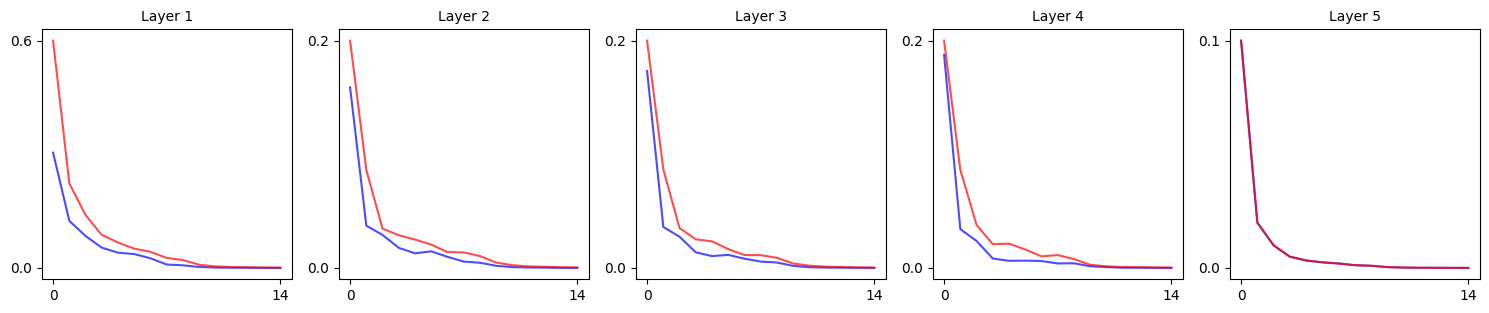

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_dimensionality_comparison(metrics50, hidden_size50):
    # Set figure size and style
    
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    fig.subplots_adjust(wspace=0.3)
    
    # Sample dimensionality is at index 0
    sample_dim = metrics50[0]  # Shape: (5, 15)
    sample_dim_shuffled = hidden_size50[0]  # Shape: (5, 15)
    
    # X values (assuming 15 datapoints)
    x = np.arange(15)
    
    for layer in range(5):
        ax = axs[layer]
        
        # Plot regular and shuffled data
        ax.plot(x, sample_dim[layer], color='blue', alpha=0.7)
        ax.plot(x, sample_dim_shuffled[layer], color='red', alpha=0.7)
        
        # Set title and remove box
        ax.set_title(f'Layer {layer+1}', fontsize=10)
        
        # Set only 2 x and y ticks
        x_ticks = [0, 14]
        y_min = min(sample_dim[layer].min(), sample_dim_shuffled[layer].min())
        y_max = max(sample_dim[layer].max(), sample_dim_shuffled[layer].max())
        y_ticks = [y_min, y_max]
        
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        
        # Format tick labels to be concise
        ax.set_xticklabels([f'{int(val)}' for val in ax.get_xticks()])
        ax.set_yticklabels([f'{val:.1f}' for val in ax.get_yticks()])
        
        # Set square aspect ratio
        ax.set_box_aspect(1)
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_sample_dimensionality_comparison(metrics_50, hidden_size50)

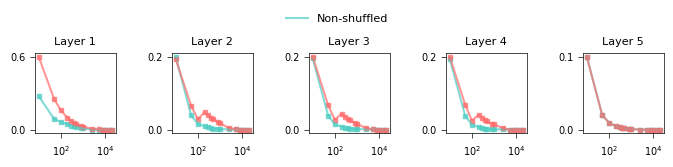

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_dimensionality_comparison(metrics50, hidden_size50, 
                                        figsize=(7.0, 1.4),  
                                        marker_size=10,      
                                        linewidth=1.5,       
                                        title_size=8,        
                                        tick_size=7,         
                                        legend_size=8):      
    # Define x values from the processing results
    x = np.array([10, 50, 100, 200, 300, 400, 500, 800, 1000, 2500, 
                  5000, 8000, 10000, 15000, 20000])
    
    # Set figure size for single column of two-column paper
    fig, axs = plt.subplots(1, 5, figsize=figsize)
    fig.subplots_adjust(wspace=0.01)
    
    # Sample dimensionality is at index 0
    sample_dim = metrics50[0]  # Shape: (5, 15)
    sample_dim_shuffled = hidden_size50[0]  # Shape: (5, 15)
    
    for layer in range(5):
        ax = axs[layer]
        
        # Plot lines and scatter points
        ax.plot(x, sample_dim[layer], color='#4ECDC4', alpha=0.7, linewidth=linewidth)
        ax.plot(x, sample_dim_shuffled[layer], color='#FF6B6B', alpha=0.7, linewidth=linewidth)
        
        # Add scatter points with square markers
        ax.scatter(x, sample_dim[layer], color='#4ECDC4', marker='s', s=marker_size, alpha=0.7)
        ax.scatter(x, sample_dim_shuffled[layer], color='#FF6B6B', marker='s', s=marker_size, alpha=0.7)
        
        # Set title
        ax.set_title(f'Layer {layer+1}', fontsize=title_size)
        
        # Show all spines and make them thin
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
        
        # Set x and y ticks
        x_ticks = [10, 20000]
        y_min = min(sample_dim[layer].min(), sample_dim_shuffled[layer].min())
        y_max = max(sample_dim[layer].max(), sample_dim_shuffled[layer].max())
        y_ticks = [y_min, y_max]
        
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        
        # Format tick labels to be concise
        ax.set_xticklabels([f'{int(val)}' for val in ax.get_xticks()], fontsize=tick_size)
        ax.set_yticklabels([f'{val:.1f}' for val in ax.get_yticks()], fontsize=tick_size)
        
        # Set square aspect ratio
        ax.set_box_aspect(1)
        
        # Make tick marks thinner
        ax.tick_params(width=0.5)
        
        # Set x-axis to log scale
        ax.set_xscale('log')
        
    # Add legend with both line and scatter
    lines = axs[0].get_lines()[::2]
    fig.legend(lines, ['Non-shuffled', 'Shuffled'], 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.2),
              ncol=2,
              fontsize=legend_size,
              frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    plt.show()

# Example usage:
plot_sample_dimensionality_comparison(metrics_400, hidden_size400)

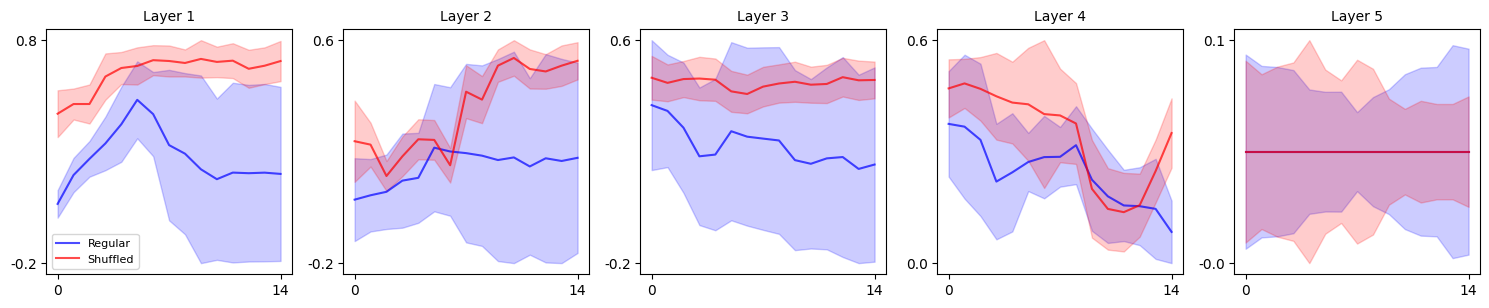

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_dimensionality_comparison(metrics50, hidden_size50):
    # Set figure size and style
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    fig.subplots_adjust(wspace=0.3)
    
    # Sample dimensionality mean is at index 0, std at index 1
    sample_dim_mean = metrics50[2]  # Shape: (5, 15)
    sample_dim_std = metrics50[3]   # Shape: (5, 15)
    
    # Shuffled data mean and std
    sample_dim_shuffled_mean = hidden_size50[2]  # Shape: (5, 15)
    sample_dim_shuffled_std = hidden_size50[3]   # Shape: (5, 15)
    
    # X values (assuming 15 datapoints)
    x = np.arange(15)
    
    for layer in range(5):
        ax = axs[layer]
        
        # Plot regular data with std ribbon
        ax.plot(x, sample_dim_mean[layer], color='blue', alpha=0.7, label='Regular')
        ax.fill_between(x, 
                       sample_dim_mean[layer] - sample_dim_std[layer],
                       sample_dim_mean[layer] + sample_dim_std[layer],
                       color='blue', alpha=0.2)
        
        # Plot shuffled data with std ribbon
        ax.plot(x, sample_dim_shuffled_mean[layer], color='red', alpha=0.7, label='Shuffled')
        ax.fill_between(x,
                       sample_dim_shuffled_mean[layer] - sample_dim_shuffled_std[layer],
                       sample_dim_shuffled_mean[layer] + sample_dim_shuffled_std[layer],
                       color='red', alpha=0.2)
        
        # Set title and remove box
        ax.set_title(f'Layer {layer+1}', fontsize=10)
        
        # Set only 2 x and y ticks
        x_ticks = [0, 14]
        y_values = [
            sample_dim_mean[layer] - sample_dim_std[layer],
            sample_dim_mean[layer] + sample_dim_std[layer],
            sample_dim_shuffled_mean[layer] - sample_dim_shuffled_std[layer],
            sample_dim_shuffled_mean[layer] + sample_dim_shuffled_std[layer]
        ]
        y_min = min([arr.min() for arr in y_values])
        y_max = max([arr.max() for arr in y_values])
        y_ticks = [y_min, y_max]
        
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        
        # Format tick labels to be concise
        ax.set_xticklabels([f'{int(val)}' for val in ax.get_xticks()])
        ax.set_yticklabels([f'{val:.1f}' for val in ax.get_yticks()])
        
        # Set square aspect ratio
        ax.set_box_aspect(1)
        
        # Add legend to first subplot only
        if layer == 0:
            ax.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_sample_dimensionality_comparison(metrics_50, hidden_size50)

In [ ]:
#####

In [12]:
import torch
import os
import json
import numpy as np
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt
import numpy as np

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    # Load hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    # Load final results
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams


def compute_lesswrong_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float]:
    """Compute LessWrong's fractional dimensionality metrics using SVD"""
    with torch.no_grad():
        # Normalize hidden representations
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        
        # Compute SVD for hidden representations
        _, S_hidden, _ = torch.svd(normalized_hidden)
        hidden_dim = torch.sum(S_hidden) / (torch.max(S_hidden) * S_hidden.shape[0] + 1e-8)
        
        # Normalize features
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        
        # Compute SVD for features
        _, S_features, _ = torch.svd(normalized_features)
        feature_dim = torch.sum(S_features) / (torch.max(S_features) * S_features.shape[0] + 1e-8)
        
        return float(hidden_dim), float(feature_dim)

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data"""
    # Get input dimension from hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    # Extract model parameters
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    
    # Construct model prefix
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    # Load final model
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode)
    model.load_state_dict(torch.load(model_path))
    
    # Load training data
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    X_train = train_data['X']
    y_train = train_data['y']
    
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard'):
        super().__init__()
        
        torch.set_default_dtype(torch.float32)
        
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            
            layers.extend([
                linear,
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, timestamp: str, target_lr=None):
    """Analyze metrics across different dataset sizes and model widths"""
    input_dim = hyperparams['d']
    
    if target_lr is not None:
        results = [r for r in results if r['learning_rate'] == target_lr]
    
    # Group results by hidden_size
    width_groups = {}
    for result in results:
        hidden_size = result['hidden_size']
        if hidden_size not in width_groups:
            width_groups[hidden_size] = []
        width_groups[hidden_size].append(result)
    
    all_metrics = {}
    for hidden_size, group_results in width_groups.items():
        sorted_results = sorted(group_results, key=lambda x: x['n_train'])
        
        metrics = {
            'n_train': [],
            'layers': []
        }
        
        for result in sorted_results:
            print(f"Processing result: n_train={result['n_train']}, hidden_size={hidden_size}, lr={result['learning_rate']}")
            
            model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
            layer_metrics = analyze_dimensionality_by_layer(model, X_train)
            
            metrics['n_train'].append(result['n_train'])
            metrics['layers'].append(layer_metrics)
        
        all_metrics[hidden_size] = metrics
    
    return all_metrics
def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[Tuple[float, float], Tuple[float, float]]:
    """Compute Anthropic's dimensionality metrics for both samples and features with standard deviations."""
    with torch.no_grad():
        try:
            # Sample dimensionality (DXi)
            hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
            normalized_hidden = hidden / (hidden_norms + 1e-8)
            hidden_dots = normalized_hidden @ hidden.T
            hidden_dots_squared = hidden_dots ** 2
            sample_denominator = torch.sum(hidden_dots_squared, dim=1)
            sample_numerator = torch.sum(hidden * hidden, dim=1)
            sample_dims = sample_numerator / (sample_denominator + 1e-8)
            
            # Feature dimensionality (DXi)
            feature_norms = torch.norm(features, dim=0, keepdim=True)
            normalized_features = features / (feature_norms + 1e-8)
            feature_dots = normalized_features.T @ features
            feature_dots_squared = feature_dots ** 2
            feature_denominator = torch.sum(feature_dots_squared, dim=1)
            feature_numerator = torch.sum(features * features, dim=0)
            feature_dims = feature_numerator / (feature_denominator + 1e-8)

            # Compute means and standard errors
            sample_mean = float(torch.mean(sample_dims))
            sample_std = float(torch.std(sample_dims) / torch.sqrt(torch.tensor(len(sample_dims))))
            feature_mean = float(torch.mean(feature_dims))
            feature_std = float(torch.std(feature_dims) / torch.sqrt(torch.tensor(len(feature_dims))))

            return (sample_mean, sample_std), (feature_mean, feature_std)
        except Exception as e:
            print(f"Warning: Error in Anthropic dimensionality calculation: {str(e)}")
            return (0.0, 0.0), (0.0, 0.0)
 

def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> List[Dict]:
    """Compute dimensionality metrics for each layer of the model"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            try:
                if hasattr(layer, 'weight'):
                    features = layer.weight.data
                    # Store features as is, without flattening
                    features_np = features.cpu().numpy()
                else:
                    continue
                
                current_activation = layer(current_activation)
                
                # Compute metrics
                (sample_mean, sample_std), (feature_mean, feature_std) = compute_anthropic_dimensionality(
                    current_activation, features)
                
                layer_metrics.append({
                    'layer': i,
                    'anthropic': {
                        'sample_dim': sample_mean,
                        'sample_dim_std': sample_std,
                        'feature_dim': feature_mean,
                        'feature_dim_std': feature_std
                    },
                    'features': features_np
                })
            except Exception as e:
                print(f"Warning: Error processing layer {i}: {str(e)}")
                layer_metrics.append({
                    'layer': i,
                    'anthropic': {
                        'sample_dim': 0.0,
                        'sample_dim_std': 0.0,
                        'feature_dim': 0.0,
                        'feature_dim_std': 0.0
                    },
                    'features': np.zeros((1, 1))
                })
    
    return layer_metrics



def plot_feature_distributions(metrics, features, hidden_size, layer_idx=0, datapoint_idx=0):
    """Plot feature weight distributions for a specific layer and datapoint"""
    plt.figure(figsize=(10, 6))
    weights = features[layer_idx][datapoint_idx]
    plt.hist(weights, bins=50, label=f'Hidden size {hidden_size}')
    plt.xlabel('Feature Weight')
    plt.ylabel('Count')
    plt.title(f'Feature Weight Distribution - Layer {layer_idx}, Datapoint {datapoint_idx}')
    plt.legend()



def extract_metrics_array(all_metrics: Dict, hidden_size: int) -> Tuple[np.ndarray, List[np.ndarray]]:
    """Extract metrics into arrays
    
    Returns:
        Tuple[np.ndarray, List[np.ndarray]]: 
            - Array of shape (2, n_layers, n_datapoints, 2) containing dimensionality metrics
            - List of arrays containing features for each layer (combined across datapoints)
    """
    if hidden_size not in all_metrics:
        raise ValueError(f"Hidden size {hidden_size} not found in metrics")
        
    metrics = all_metrics[hidden_size]
    n_layers = len(metrics['layers'][0])  # Number of layers from first datapoint
    n_datapoints = len(metrics['layers'])  # Number of different dataset sizes
    n_dim_types = 2  # sample_dim and feature_dim
    n_stats = 2  # mean and std
    
    # Initialize result array for metrics
    result = np.zeros((n_dim_types, n_layers, n_datapoints, n_stats))
    
    # Initialize list to store features for each layer
    features_by_layer = [[] for _ in range(n_layers)]
    
    # Fill arrays
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            # Mean and std for sample dimension
            result[0, layer_idx, dp_idx, 0] = layer_metrics[layer_idx]['anthropic']['sample_dim']
            result[0, layer_idx, dp_idx, 1] = layer_metrics[layer_idx]['anthropic']['sample_dim_std']
            
            # Mean and std for feature dimension
            result[1, layer_idx, dp_idx, 0] = layer_metrics[layer_idx]['anthropic']['feature_dim']
            result[1, layer_idx, dp_idx, 1] = layer_metrics[layer_idx]['anthropic']['feature_dim_std']
            
            # Store features for this layer
            features = layer_metrics[layer_idx]['features'].flatten()
            features_by_layer[layer_idx].extend(features)
    
    # Convert features lists to arrays
    features_arrays = [np.array(layer_features) for layer_features in features_by_layer]
    
    print(f"Metrics array shape: {result.shape}")
    print(f"- Number of dimension types: {n_dim_types}")
    print(f"- Number of layers: {n_layers}")
    print(f"- Number of datapoints: {n_datapoints}")
    print(f"- Number of statistics: {n_stats}")
    print(f"\nFeatures array shapes for each layer:")
    for i, features in enumerate(features_arrays):
        print(f"Layer {i}: {features.shape}")
    
    return result, features_arrays

# Example usage:

# After loading and processing data...
metrics_50, features_50 = extract_metrics_array(all_metrics, 50)
metrics_400, features_400 = extract_metrics_array(all_metrics, 400)

# Plot feature distributions
layer_idx = 5  # Choose which layer to visualize
plt.figure(figsize=(10, 6))

# Plot for hidden size 50
plt.hist(features_50[layer_idx], bins=50, alpha=0.5, label='Hidden size 50')
# Plot for hidden size 400
plt.hist(features_400[layer_idx], bins=50, alpha=0.5, label='Hidden size 400')

plt.xlabel('Feature Weight')
plt.ylabel('Count')
plt.title(f'Feature Weight Distribution - Layer {layer_idx}')
plt.legend()
plt.show()


Metrics array shape: (2, 5, 15, 2)
- Number of dimension types: 2
- Number of layers: 5
- Number of datapoints: 15
- Number of statistics: 2

Features array shapes for each layer:
Layer 0: (22500,)
Layer 1: (37500,)
Layer 2: (37500,)
Layer 3: (37500,)
Layer 4: (750,)
Metrics array shape: (2, 5, 15, 2)
- Number of dimension types: 2
- Number of layers: 5
- Number of datapoints: 15
- Number of statistics: 2

Features array shapes for each layer:
Layer 0: (180000,)
Layer 1: (2400000,)
Layer 2: (2400000,)
Layer 3: (2400000,)
Layer 4: (6000,)


IndexError: list index out of range

<Figure size 1000x600 with 0 Axes>

In [ ]:
###############################

In [2]:
import torch
import os
import json
import numpy as np
from typing import Tuple, Dict, List

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    # Load hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    # Load final results
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data"""
    # Get input dimension from hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    # Extract model parameters
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    
    # Construct model prefix
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    # Load final model
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode)
    model.load_state_dict(torch.load(model_path))
    
    # Load training data
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    X_train = train_data['X']
    y_train = train_data['y']
    
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard'):
        super().__init__()
        
        torch.set_default_dtype(torch.float32)
        
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            
            layers.extend([
                linear,
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, timestamp: str, target_lr=None):
    """Analyze metrics across different dataset sizes and model widths"""
    input_dim = hyperparams['d']
    
    if target_lr is not None:
        results = [r for r in results if r['learning_rate'] == target_lr]
    
    # Group results by hidden_size
    width_groups = {}
    for result in results:
        hidden_size = result['hidden_size']
        if hidden_size not in width_groups:
            width_groups[hidden_size] = []
        width_groups[hidden_size].append(result)
    
    all_metrics = {}
    for hidden_size, group_results in width_groups.items():
        sorted_results = sorted(group_results, key=lambda x: x['n_train'])
        
        metrics = {
            'n_train': [],
            'layers': []
        }
        
        for result in sorted_results:
            print(f"Processing result: n_train={result['n_train']}, hidden_size={hidden_size}, lr={result['learning_rate']}")
            
            model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
            layer_metrics = analyze_dimensionality_by_layer(model, X_train)
            
            metrics['n_train'].append(result['n_train'])
            metrics['layers'].append(layer_metrics)
        
        all_metrics[hidden_size] = metrics
    
    return all_metrics

def compute_lesswrong_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float]:
    """Compute LessWrong's fractional dimensionality metrics using SVD"""
    with torch.no_grad():
        # Normalize hidden representations
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        
        # Compute SVD for hidden representations
        _, S_hidden, _ = torch.svd(normalized_hidden)
        hidden_dim = torch.sum(S_hidden) / (torch.max(S_hidden) * S_hidden.shape[0] + 1e-8)
        
        # Normalize features
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        
        # Compute SVD for features
        _, S_features, _ = torch.svd(normalized_features)
        feature_dim = torch.sum(S_features) / (torch.max(S_features) * S_features.shape[0] + 1e-8)
        
        return float(hidden_dim), float(feature_dim)

def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics for each layer of the model"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            # Get layer weights
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue  # Skip layers without weights (e.g., activation functions)
            
            # Forward pass through this layer
            current_activation = layer(current_activation)
            
            # Compute both metrics for this layer
            anth_sample_dim, anth_feature_dim = compute_anthropic_dimensionality(
                current_activation, features)
            lw_hidden_dim, lw_feature_dim = compute_lesswrong_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': anth_sample_dim,
                    'feature_dim': anth_feature_dim
                },
                'lesswrong': {
                    'hidden_dim': lw_hidden_dim,
                    'feature_dim': lw_feature_dim
                }
            })
    
    return layer_metrics


def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float]:
    """Compute Anthropic's dimensionality metrics for both samples and features with standard deviations."""
    with torch.no_grad():
        # Sample dimensionality (DXi)
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        # Calculate mean and std for sample dimensions
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality (DXi)
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        # Calculate mean and std for feature dimensions
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std

# Modified analyze_dimensionality_by_layer function
def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics and their standard deviations for each layer"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue
            
            current_activation = layer(current_activation)
            
            sample_mean, sample_std, feature_mean, feature_std = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': sample_mean,
                    'sample_dim_std': sample_std,
                    'feature_dim': feature_mean,
                    'feature_dim_std': feature_std
                }
            })
    
    return layer_metrics

# Modified extract_metrics_array function
def extract_metrics_array(all_metrics: Dict, hidden_size: int) -> np.ndarray:
    """Extract metrics into a 3D numpy array [dim_type, layer, datapoint]
    where dim_type is [sample_dim, sample_dim_std, feature_dim, feature_dim_std]
    
    Returns:
        np.ndarray: Array of shape (4, n_layers, n_datapoints) containing dimensionality metrics
    """
    if hidden_size not in all_metrics:
        raise ValueError(f"Hidden size {hidden_size} not found in metrics")
        
    metrics = all_metrics[hidden_size]
    n_layers = len(metrics['layers'][0])  # Number of layers from first datapoint
    n_datapoints = len(metrics['layers'])  # Number of different dataset sizes
    n_dim_types = 4  # sample_dim, sample_dim_std, feature_dim, feature_dim_std
    
    # Initialize array
    result = np.zeros((n_dim_types, n_layers, n_datapoints))
    
    # Fill array
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            # Sample dimension and std at index 0, 1
            result[0, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim']
            result[1, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim_std']
            # Feature dimension and std at index 2, 3
            result[2, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim']
            result[3, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim_std']
    
    print(f"Array shape: {result.shape}")
    print(f"- Number of dimension types: {n_dim_types}")
    print(f"- Number of layers: {n_layers}")
    print(f"- Number of datapoints: {n_datapoints}")
            
    return result


results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_true_antro_newmsp"
data_dir = results_dir
timestamp = "20250104_184500"

# Load data
results, hyperparams = load_experiment_data(results_dir, timestamp)

# Analyze metrics
all_metrics = analyze_by_dataset_size(results, hyperparams, data_dir, results_dir, timestamp, target_lr=0.001)

# Extract arrays for hidden sizes 50 and 400
hidden_size50 = extract_metrics_array(all_metrics, 50)
hidden_size400 = extract_metrics_array(all_metrics, 1000)

print("Hidden size 50 array shape:", hidden_size50.shape)
print("Hidden size 50 array:")
print(hidden_size50)
print("\nHidden size 400 array shape:", hidden_size400.shape)
print("Hidden size 400 array:")
print(hidden_size400)



Processing result: n_train=10, hidden_size=1000, lr=0.001


/tmp/ipykernel_2667766/3699121717.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_2667766/3699121717.py:50:

Processing result: n_train=50, hidden_size=1000, lr=0.001
Processing result: n_train=100, hidden_size=1000, lr=0.001
Processing result: n_train=200, hidden_size=1000, lr=0.001
Processing result: n_train=300, hidden_size=1000, lr=0.001
Processing result: n_train=400, hidden_size=1000, lr=0.001
Processing result: n_train=500, hidden_size=1000, lr=0.001
Processing result: n_train=800, hidden_size=1000, lr=0.001
Processing result: n_train=1000, hidden_size=1000, lr=0.001
Processing result: n_train=2500, hidden_size=1000, lr=0.001
Processing result: n_train=5000, hidden_size=1000, lr=0.001
Processing result: n_train=8000, hidden_size=1000, lr=0.001
Processing result: n_train=10000, hidden_size=1000, lr=0.001
Processing result: n_train=15000, hidden_size=1000, lr=0.001
Processing result: n_train=20000, hidden_size=1000, lr=0.001
Processing result: n_train=30000, hidden_size=1000, lr=0.001
Processing result: n_train=10, hidden_size=50, lr=0.001
Processing result: n_train=50, hidden_size=50, l

In [ ]:
import torch
import os
import json
import numpy as np
from typing import Tuple, Dict, List

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    # Load hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    # Load final results
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data"""
    # Get input dimension from hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    # Extract model parameters
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    
    # Construct model prefix
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    # Load final model
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode)
    model.load_state_dict(torch.load(model_path))
    
    # Load training data
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    X_train = train_data['X']
    y_train = train_data['y']
    
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard'):
        super().__init__()
        
        torch.set_default_dtype(torch.float32)
        
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            
            layers.extend([
                linear,
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, timestamp: str, target_lr=None):
    """Analyze metrics across different dataset sizes and model widths"""
    input_dim = hyperparams['d']
    
    if target_lr is not None:
        results = [r for r in results if r['learning_rate'] == target_lr]
    
    # Group results by hidden_size
    width_groups = {}
    for result in results:
        hidden_size = result['hidden_size']
        if hidden_size not in width_groups:
            width_groups[hidden_size] = []
        width_groups[hidden_size].append(result)
    
    all_metrics = {}
    for hidden_size, group_results in width_groups.items():
        sorted_results = sorted(group_results, key=lambda x: x['n_train'])
        
        metrics = {
            'n_train': [],
            'layers': []
        }
        
        for result in sorted_results:
            print(f"Processing result: n_train={result['n_train']}, hidden_size={hidden_size}, lr={result['learning_rate']}")
            
            model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
            layer_metrics = analyze_dimensionality_by_layer(model, X_train)
            
            metrics['n_train'].append(result['n_train'])
            metrics['layers'].append(layer_metrics)
        
        all_metrics[hidden_size] = metrics
    
    return all_metrics

def compute_lesswrong_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float]:
    """Compute LessWrong's fractional dimensionality metrics using SVD"""
    with torch.no_grad():
        # Normalize hidden representations
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        
        # Compute SVD for hidden representations
        _, S_hidden, _ = torch.svd(normalized_hidden)
        hidden_dim = torch.sum(S_hidden) / (torch.max(S_hidden) * S_hidden.shape[0] + 1e-8)
        
        # Normalize features
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        
        # Compute SVD for features
        _, S_features, _ = torch.svd(normalized_features)
        feature_dim = torch.sum(S_features) / (torch.max(S_features) * S_features.shape[0] + 1e-8)
        
        return float(hidden_dim), float(feature_dim)

def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics for each layer of the model"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            # Get layer weights
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue  # Skip layers without weights (e.g., activation functions)
            
            # Forward pass through this layer
            current_activation = layer(current_activation)
            
            # Compute both metrics for this layer
            anth_sample_dim, anth_feature_dim = compute_anthropic_dimensionality(
                current_activation, features)
            lw_hidden_dim, lw_feature_dim = compute_lesswrong_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': anth_sample_dim,
                    'feature_dim': anth_feature_dim
                },
                'lesswrong': {
                    'hidden_dim': lw_hidden_dim,
                    'feature_dim': lw_feature_dim
                }
            })
    
    return layer_metrics


def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float]:
    """Compute Anthropic's dimensionality metrics for both samples and features with standard deviations."""
    with torch.no_grad():
        # Sample dimensionality (DXi)
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality (DXi)
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
    
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std

# Modified analyze_dimensionality_by_layer function
def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics and their standard deviations for each layer"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue
            
            current_activation = layer(current_activation)
            
            sample_mean, sample_std, feature_mean, feature_std = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': sample_mean,
                    'sample_dim_std': sample_std,
                    'feature_dim': feature_mean,
                    'feature_dim_std': feature_std
                }
            })
    
    return layer_metrics

# Modified extract_metrics_array function
def extract_metrics_array(all_metrics: Dict, hidden_size: int) -> np.ndarray:
    """Extract metrics into a 3D numpy array [dim_type, layer, datapoint]
    where dim_type is [sample_dim, sample_dim_std, feature_dim, feature_dim_std]
    
    Returns:
        np.ndarray: Array of shape (4, n_layers, n_datapoints) containing dimensionality metrics
    """
    if hidden_size not in all_metrics:
        raise ValueError(f"Hidden size {hidden_size} not found in metrics")
        
    metrics = all_metrics[hidden_size]
    n_layers = len(metrics['layers'][0])  # Number of layers from first datapoint
    n_datapoints = len(metrics['layers'])  # Number of different dataset sizes
    n_dim_types = 4  # sample_dim, sample_dim_std, feature_dim, feature_dim_std
    
    # Initialize array
    result = np.zeros((n_dim_types, n_layers, n_datapoints))
    
    # Fill array
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            # Sample dimension and std at index 0, 1
            result[0, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim']
            result[1, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim_std']
            # Feature dimension and std at index 2, 3
            result[2, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim']
            result[3, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim_std']
    
    print(f"Array shape: {result.shape}")
    print(f"- Number of dimension types: {n_dim_types}")
    print(f"- Number of layers: {n_layers}")
    print(f"- Number of datapoints: {n_datapoints}")
            
    return result


results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_false_antro_newmsp"
data_dir = results_dir
timestamp = "20250104_183809"

# Load data
results, hyperparams = load_experiment_data(results_dir, timestamp)

# Analyze metrics
all_metrics = analyze_by_dataset_size(results, hyperparams, data_dir, results_dir, timestamp, target_lr=0.001)

# Extract arrays for hidden sizes 50 and 400
hidden_size50_false = extract_metrics_array(all_metrics, 50)
hidden_size400_false = extract_metrics_array(all_metrics, 1000)

print("Hidden size 50 array shape:", hidden_size50.shape)
print("Hidden size 50 array:")
print(hidden_size50)
print("\nHidden size 400 array shape:", hidden_size400.shape)
print("Hidden size 400 array:")
print(hidden_size400)



Processing result: n_train=10, hidden_size=1000, lr=0.001


/tmp/ipykernel_2667766/2490173237.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_2667766/2490173237.py:50:

Processing result: n_train=50, hidden_size=1000, lr=0.001
Processing result: n_train=100, hidden_size=1000, lr=0.001
Processing result: n_train=200, hidden_size=1000, lr=0.001
Processing result: n_train=300, hidden_size=1000, lr=0.001
Processing result: n_train=400, hidden_size=1000, lr=0.001
Processing result: n_train=500, hidden_size=1000, lr=0.001
Processing result: n_train=800, hidden_size=1000, lr=0.001
Processing result: n_train=1000, hidden_size=1000, lr=0.001
Processing result: n_train=2500, hidden_size=1000, lr=0.001
Processing result: n_train=5000, hidden_size=1000, lr=0.001
Processing result: n_train=8000, hidden_size=1000, lr=0.001
Processing result: n_train=10000, hidden_size=1000, lr=0.001
Processing result: n_train=15000, hidden_size=1000, lr=0.001
Processing result: n_train=20000, hidden_size=1000, lr=0.001
Processing result: n_train=30000, hidden_size=1000, lr=0.001
Processing result: n_train=10, hidden_size=50, lr=0.001
Processing result: n_train=50, hidden_size=50, l

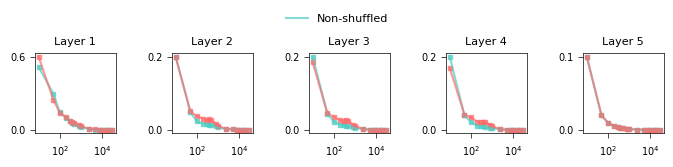

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_dimensionality_comparison(metrics50, hidden_size50, 
                                        figsize=(7.0, 1.4),  
                                        marker_size=10,      
                                        linewidth=1.5,       
                                        title_size=8,        
                                        tick_size=7,         
                                        legend_size=8):      
    # Define x values from the processing results
    x = np.array([10, 50, 100, 200, 300, 400, 500, 800, 1000, 2500, 
                  5000, 8000, 10000, 15000, 20000,30000])
    
    # Set figure size for single column of two-column paper
    fig, axs = plt.subplots(1, 5, figsize=figsize)
    fig.subplots_adjust(wspace=0.01)
    
    # Sample dimensionality is at index 0
    sample_dim = metrics50[0]  # Shape: (5, 15)
    sample_dim_shuffled = hidden_size50[0]  # Shape: (5, 15)
    
    for layer in range(5):
        ax = axs[layer]
        
        # Plot lines and scatter points
        ax.plot(x, sample_dim[layer], color='#4ECDC4', alpha=0.7, linewidth=linewidth)
        ax.plot(x, sample_dim_shuffled[layer], color='#FF6B6B', alpha=0.7, linewidth=linewidth)
        
        # Add scatter points with square markers
        ax.scatter(x, sample_dim[layer], color='#4ECDC4', marker='s', s=marker_size, alpha=0.7)
        ax.scatter(x, sample_dim_shuffled[layer], color='#FF6B6B', marker='s', s=marker_size, alpha=0.7)
        
        # Set title
        ax.set_title(f'Layer {layer+1}', fontsize=title_size)
        
        # Show all spines and make them thin
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
        
        # Set x and y ticks
        x_ticks = [10, 20000]
        y_min = min(sample_dim[layer].min(), sample_dim_shuffled[layer].min())
        y_max = max(sample_dim[layer].max(), sample_dim_shuffled[layer].max())
        y_ticks = [y_min, y_max]
        
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        
        # Format tick labels to be concise
        ax.set_xticklabels([f'{int(val)}' for val in ax.get_xticks()], fontsize=tick_size)
        ax.set_yticklabels([f'{val:.1f}' for val in ax.get_yticks()], fontsize=tick_size)
        
        # Set square aspect ratio
        ax.set_box_aspect(1)
        
        # Make tick marks thinner
        ax.tick_params(width=0.5)
        
        # Set x-axis to log scale
        ax.set_xscale('log')
        
    # Add legend with both line and scatter
    lines = axs[0].get_lines()[::2]
    fig.legend(lines, ['Non-shuffled', 'Shuffled'], 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.2),
              ncol=2,
              fontsize=legend_size,
              frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    plt.show()

# Example usage:
plot_sample_dimensionality_comparison(hidden_size400_false,hidden_size400)

In [ ]:
####

In [2]:
import torch
import os
import json
import numpy as np
from typing import Tuple, Dict, List

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    # Load hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    # Load final results
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data"""
    # Get input dimension from hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    # Extract model parameters
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    
    # Construct model prefix
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    # Load final model
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode)
    model.load_state_dict(torch.load(model_path))
    
    # Load training data
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    X_train = train_data['X']
    y_train = train_data['y']
    
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard'):
        super().__init__()
        
        torch.set_default_dtype(torch.float32)
        
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            
            layers.extend([
                linear,
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float, torch.Tensor]:
    """
    Compute Anthropic's dimensionality metrics for both samples and features with standard deviations.
    Also returns the raw feature dimensionality array.
    
    Returns:
        Tuple containing:
        - sample_mean: float
        - sample_std: float
        - feature_mean: float
        - feature_std: float
        - feature_dims: torch.Tensor (raw feature dimensionality array)
    """
    with torch.no_grad():
        # Sample dimensionality (DXi)
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality (DXi)
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std, feature_dims

def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, timestamp: str, target_lr=None):
    """Analyze metrics across different dataset sizes and model widths"""
    input_dim = hyperparams['d']
    
    if target_lr is not None:
        results = [r for r in results if r['learning_rate'] == target_lr]
    
    # Group results by hidden_size
    width_groups = {}
    for result in results:
        hidden_size = result['hidden_size']
        if hidden_size not in width_groups:
            width_groups[hidden_size] = []
        width_groups[hidden_size].append(result)
    
    all_metrics = {}
    for hidden_size, group_results in width_groups.items():
        sorted_results = sorted(group_results, key=lambda x: x['n_train'])
        
        metrics = {
            'n_train': [],
            'layers': []
        }
        
        for result in sorted_results:
            print(f"Processing result: n_train={result['n_train']}, hidden_size={hidden_size}, lr={result['learning_rate']}")
            
            model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
            layer_metrics = analyze_dimensionality_by_layer(model, X_train)
            
            metrics['n_train'].append(result['n_train'])
            metrics['layers'].append(layer_metrics)
        
        all_metrics[hidden_size] = metrics
    
    return all_metrics

def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """
    Compute dimensionality metrics and their standard deviations for each layer.
    Now also includes raw feature dimensionality arrays.
    """
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue
            
            current_activation = layer(current_activation)
            
            sample_mean, sample_std, feature_mean, feature_std, feature_dims = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': sample_mean,
                    'sample_dim_std': sample_std,
                    'feature_dim': feature_mean,
                    'feature_dim_std': feature_std,
                    'feature_dims_raw': feature_dims.cpu().numpy()  # Store raw feature dimensions
                }
            })
    
    return layer_metrics

def extract_metrics_array(all_metrics: Dict, hidden_size: int) -> Tuple[np.ndarray, List[np.ndarray]]:
    """
    Extract metrics into a 3D numpy array and list of raw feature dimension arrays.
    
    Returns:
        Tuple containing:
        - np.ndarray: Array of shape (4, n_layers, n_datapoints) containing summary statistics
        - List[np.ndarray]: List of raw feature dimension arrays for each layer and datapoint
    """
    if hidden_size not in all_metrics:
        raise ValueError(f"Hidden size {hidden_size} not found in metrics")
        
    metrics = all_metrics[hidden_size]
    n_layers = len(metrics['layers'][0])  # Number of layers from first datapoint
    n_datapoints = len(metrics['layers'])  # Number of different dataset sizes
    n_dim_types = 4  # sample_dim, sample_dim_std, feature_dim, feature_dim_std
    
    # Initialize arrays
    result = np.zeros((n_dim_types, n_layers, n_datapoints))
    raw_feature_dims = [[[] for _ in range(n_datapoints)] for _ in range(n_layers)]
    
    # Fill arrays
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            # Summary statistics
            result[0, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim']
            result[1, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim_std']
            result[2, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim']
            result[3, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim_std']
            
            # Raw feature dimensions
            raw_feature_dims[layer_idx][dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dims_raw']
    
    print(f"Array shape: {result.shape}")
    print(f"- Number of dimension types: {n_dim_types}")
    print(f"- Number of layers: {n_layers}")
    print(f"- Number of datapoints: {n_datapoints}")
            
    return result, raw_feature_dims

# Example usage:
if __name__ == "__main__":
    results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_true_antro_newmsp"
    data_dir = results_dir
    timestamp = "20250104_184500"

    # Load data
    results, hyperparams = load_experiment_data(results_dir, timestamp)

    # Analyze metrics
    all_metrics = analyze_by_dataset_size(results, hyperparams, data_dir, results_dir, timestamp, target_lr=0.001)

    # Extract arrays for hidden sizes 50 and 400
    hidden_size50_stats, hidden_size50_raw = extract_metrics_array(all_metrics, 50)
    hidden_size400_true, hidden_size400_raw_true = extract_metrics_array(all_metrics, 1000)

    print("Hidden size 50 summary statistics shape:", hidden_size50_stats.shape)
    print("Number of layers with raw feature dimensions:", len(hidden_size50_raw))
    print("Example raw feature dimensions shape for first layer, first datapoint:", hidden_size50_raw[0][0].shape)

    #print("\nHidden size 400 summary statistics shape:", hidden_size400_stats.shape)
    #print("Number of layers with raw feature dimensions:", len(hidden_size400_raw))
    #print("Example raw feature dimensions shape for first layer, first datapoint:", hidden_size400_raw[0][0].shape)

Processing result: n_train=10, hidden_size=1000, lr=0.001


/tmp/ipykernel_4141675/969988166.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_4141675/969988166.py:50: F

Processing result: n_train=50, hidden_size=1000, lr=0.001
Processing result: n_train=100, hidden_size=1000, lr=0.001
Processing result: n_train=200, hidden_size=1000, lr=0.001
Processing result: n_train=300, hidden_size=1000, lr=0.001
Processing result: n_train=400, hidden_size=1000, lr=0.001
Processing result: n_train=500, hidden_size=1000, lr=0.001
Processing result: n_train=800, hidden_size=1000, lr=0.001
Processing result: n_train=1000, hidden_size=1000, lr=0.001
Processing result: n_train=2500, hidden_size=1000, lr=0.001
Processing result: n_train=5000, hidden_size=1000, lr=0.001
Processing result: n_train=8000, hidden_size=1000, lr=0.001
Processing result: n_train=10000, hidden_size=1000, lr=0.001
Processing result: n_train=15000, hidden_size=1000, lr=0.001
Processing result: n_train=20000, hidden_size=1000, lr=0.001
Processing result: n_train=30000, hidden_size=1000, lr=0.001
Processing result: n_train=10, hidden_size=50, lr=0.001
Processing result: n_train=50, hidden_size=50, l

In [3]:
import torch
import os
import json
import numpy as np
from typing import Tuple, Dict, List

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    # Load hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    # Load final results
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data"""
    # Get input dimension from hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    # Extract model parameters
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    
    # Construct model prefix
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    # Load final model
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode)
    model.load_state_dict(torch.load(model_path))
    
    # Load training data
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    X_train = train_data['X']
    y_train = train_data['y']
    
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard'):
        super().__init__()
        
        torch.set_default_dtype(torch.float32)
        
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            
            layers.extend([
                linear,
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float, torch.Tensor]:
    """
    Compute Anthropic's dimensionality metrics for both samples and features with standard deviations.
    Also returns the raw feature dimensionality array.
    
    Returns:
        Tuple containing:
        - sample_mean: float
        - sample_std: float
        - feature_mean: float
        - feature_std: float
        - feature_dims: torch.Tensor (raw feature dimensionality array)
    """
    with torch.no_grad():
        # Sample dimensionality (DXi)
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality (DXi)
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std, feature_dims

def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, timestamp: str, target_lr=None):
    """Analyze metrics across different dataset sizes and model widths"""
    input_dim = hyperparams['d']
    
    if target_lr is not None:
        results = [r for r in results if r['learning_rate'] == target_lr]
    
    # Group results by hidden_size
    width_groups = {}
    for result in results:
        hidden_size = result['hidden_size']
        if hidden_size not in width_groups:
            width_groups[hidden_size] = []
        width_groups[hidden_size].append(result)
    
    all_metrics = {}
    for hidden_size, group_results in width_groups.items():
        sorted_results = sorted(group_results, key=lambda x: x['n_train'])
        
        metrics = {
            'n_train': [],
            'layers': []
        }
        
        for result in sorted_results:
            print(f"Processing result: n_train={result['n_train']}, hidden_size={hidden_size}, lr={result['learning_rate']}")
            
            model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
            layer_metrics = analyze_dimensionality_by_layer(model, X_train)
            
            metrics['n_train'].append(result['n_train'])
            metrics['layers'].append(layer_metrics)
        
        all_metrics[hidden_size] = metrics
    
    return all_metrics

def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """
    Compute dimensionality metrics and their standard deviations for each layer.
    Now also includes raw feature dimensionality arrays.
    """
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue
            
            current_activation = layer(current_activation)
            
            sample_mean, sample_std, feature_mean, feature_std, feature_dims = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': sample_mean,
                    'sample_dim_std': sample_std,
                    'feature_dim': feature_mean,
                    'feature_dim_std': feature_std,
                    'feature_dims_raw': feature_dims.cpu().numpy()  # Store raw feature dimensions
                }
            })
    
    return layer_metrics

def extract_metrics_array(all_metrics: Dict, hidden_size: int) -> Tuple[np.ndarray, List[np.ndarray]]:
    """
    Extract metrics into a 3D numpy array and list of raw feature dimension arrays.
    
    Returns:
        Tuple containing:
        - np.ndarray: Array of shape (4, n_layers, n_datapoints) containing summary statistics
        - List[np.ndarray]: List of raw feature dimension arrays for each layer and datapoint
    """
    if hidden_size not in all_metrics:
        raise ValueError(f"Hidden size {hidden_size} not found in metrics")
        
    metrics = all_metrics[hidden_size]
    n_layers = len(metrics['layers'][0])  # Number of layers from first datapoint
    n_datapoints = len(metrics['layers'])  # Number of different dataset sizes
    n_dim_types = 4  # sample_dim, sample_dim_std, feature_dim, feature_dim_std
    
    # Initialize arrays
    result = np.zeros((n_dim_types, n_layers, n_datapoints))
    raw_feature_dims = [[[] for _ in range(n_datapoints)] for _ in range(n_layers)]
    
    # Fill arrays
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            # Summary statistics
            result[0, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim']
            result[1, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim_std']
            result[2, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim']
            result[3, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim_std']
            
            # Raw feature dimensions
            raw_feature_dims[layer_idx][dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dims_raw']
    
    print(f"Array shape: {result.shape}")
    print(f"- Number of dimension types: {n_dim_types}")
    print(f"- Number of layers: {n_layers}")
    print(f"- Number of datapoints: {n_datapoints}")
            
    return result, raw_feature_dims

# Example usage:
if __name__ == "__main__":
    results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_false_antro_newmsp"
    data_dir = results_dir
    timestamp = "20250104_183809"

    # Load data
    results, hyperparams = load_experiment_data(results_dir, timestamp)

    # Analyze metrics
    all_metrics = analyze_by_dataset_size(results, hyperparams, data_dir, results_dir, timestamp, target_lr=0.001)

    # Extract arrays for hidden sizes 50 and 400
    hidden_size50_stats, hidden_size50_raw = extract_metrics_array(all_metrics, 50)
    hidden_size400_false, hidden_size400_raw_false = extract_metrics_array(all_metrics, 1000)

    print("Hidden size 50 summary statistics shape:", hidden_size50_stats.shape)
    print("Number of layers with raw feature dimensions:", len(hidden_size50_raw))
    print("Example raw feature dimensions shape for first layer, first datapoint:", hidden_size50_raw[0][0].shape)

    #print("\nHidden size 400 summary statistics shape:", hidden_size400_stats.shape)
    #print("Number of layers with raw feature dimensions:", len(hidden_size400_raw))
    #print("Example raw feature dimensions shape for first layer, first datapoint:", hidden_size400_raw[0][0].shape)

Processing result: n_train=10, hidden_size=1000, lr=0.001


/tmp/ipykernel_4141675/4053268397.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_4141675/4053268397.py:50:

Processing result: n_train=50, hidden_size=1000, lr=0.001
Processing result: n_train=100, hidden_size=1000, lr=0.001
Processing result: n_train=200, hidden_size=1000, lr=0.001
Processing result: n_train=300, hidden_size=1000, lr=0.001
Processing result: n_train=400, hidden_size=1000, lr=0.001
Processing result: n_train=500, hidden_size=1000, lr=0.001
Processing result: n_train=800, hidden_size=1000, lr=0.001
Processing result: n_train=1000, hidden_size=1000, lr=0.001
Processing result: n_train=2500, hidden_size=1000, lr=0.001
Processing result: n_train=5000, hidden_size=1000, lr=0.001
Processing result: n_train=8000, hidden_size=1000, lr=0.001
Processing result: n_train=10000, hidden_size=1000, lr=0.001
Processing result: n_train=15000, hidden_size=1000, lr=0.001
Processing result: n_train=20000, hidden_size=1000, lr=0.001
Processing result: n_train=30000, hidden_size=1000, lr=0.001
Processing result: n_train=10, hidden_size=50, lr=0.001
Processing result: n_train=50, hidden_size=50, l

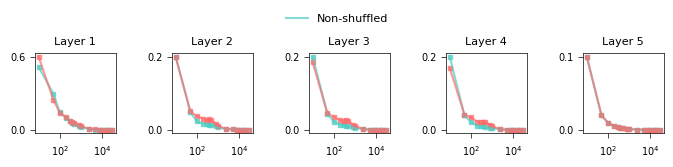

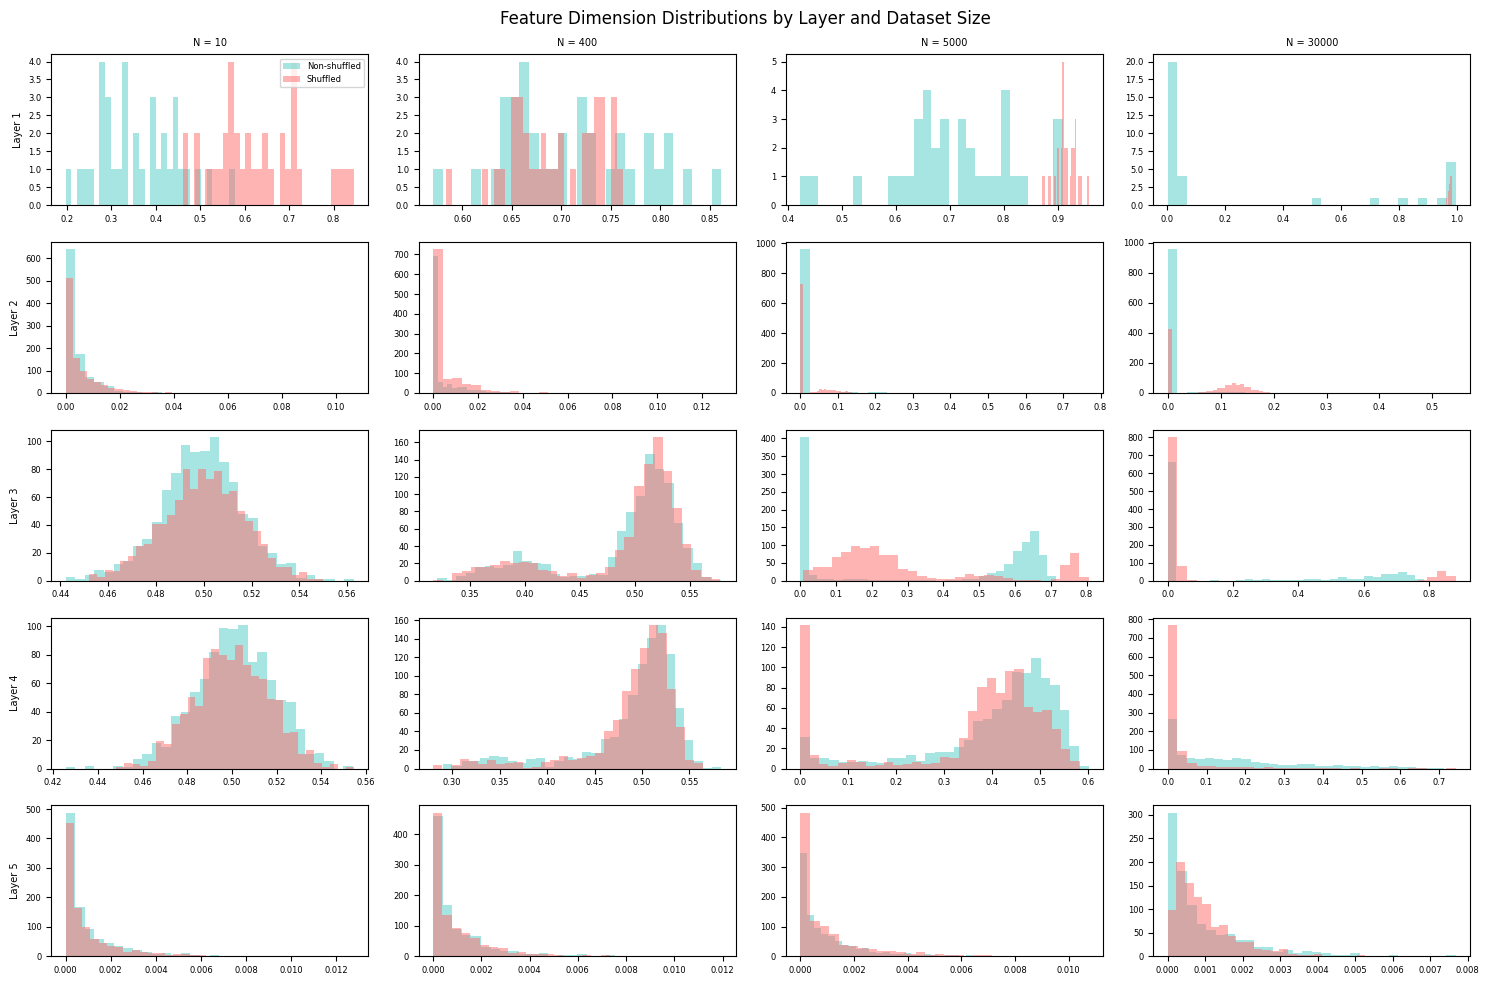

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dimensionality_analysis(metrics50, hidden_size50, raw_feature_dims50, raw_feature_dims50_shuffled,
                               dataset_sizes=[10, 50, 100, 200, 300, 400, 500, 800, 1000, 2500,
                                            5000, 8000, 10000, 15000, 20000, 30000],
                               sample_figsize=(7.0, 1.4),
                               hist_figsize=(15, 10),
                               marker_size=10,
                               linewidth=1.5,
                               title_size=8,
                               tick_size=7,
                               legend_size=8):
    """
    Creates two figures:
    1. Sample dimensionality comparison across layers
    2. Grid of histograms showing feature dimension distributions for each layer and dataset size
    
    Args:
        metrics50: Array containing sample dimensionality for non-shuffled data
        hidden_size50: Array containing sample dimensionality for shuffled data
        raw_feature_dims50: List of raw feature dimension arrays for non-shuffled data
        raw_feature_dims50_shuffled: List of raw feature dimension arrays for shuffled data
        dataset_sizes: List of dataset sizes used
        sample_figsize, hist_figsize: Figure sizes for the two plots
        marker_size, linewidth, title_size, tick_size, legend_size: Plot styling parameters
    """
    
    # 1. Sample Dimensionality Plot
    fig1, axs1 = plt.subplots(1, 5, figsize=sample_figsize)
    fig1.subplots_adjust(wspace=0.01)
    
    sample_dim = metrics50[0]  # Shape: (5, 15)
    sample_dim_shuffled = hidden_size50[0]  # Shape: (5, 15)
    
    for layer in range(5):
        ax = axs1[layer]
        
        # Plot lines and scatter points
        ax.plot(dataset_sizes, sample_dim[layer], color='#4ECDC4', alpha=0.7, linewidth=linewidth)
        ax.plot(dataset_sizes, sample_dim_shuffled[layer], color='#FF6B6B', alpha=0.7, linewidth=linewidth)
        
        ax.scatter(dataset_sizes, sample_dim[layer], color='#4ECDC4', marker='s', s=marker_size, alpha=0.7)
        ax.scatter(dataset_sizes, sample_dim_shuffled[layer], color='#FF6B6B', marker='s', s=marker_size, alpha=0.7)
        
        ax.set_title(f'Layer {layer+1}', fontsize=title_size)
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
        
        x_ticks = [10, 20000]
        y_min = min(sample_dim[layer].min(), sample_dim_shuffled[layer].min())
        y_max = max(sample_dim[layer].max(), sample_dim_shuffled[layer].max())
        y_ticks = [y_min, y_max]
        
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.set_xticklabels([f'{int(val)}' for val in ax.get_xticks()], fontsize=tick_size)
        ax.set_yticklabels([f'{val:.1f}' for val in ax.get_yticks()], fontsize=tick_size)
        ax.set_box_aspect(1)
        ax.tick_params(width=0.5)
        ax.set_xscale('log')
    
    lines = axs1[0].get_lines()[::2]
    fig1.legend(lines, ['Non-shuffled', 'Shuffled'],
              loc='upper center',
              bbox_to_anchor=(0.5, 1.2),
              ncol=2,
              fontsize=legend_size,
              frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # 2. Feature Dimensionality Histograms
    n_layers = 5
    n_datasets = len(dataset_sizes)
    selected_indices = [0, 5, 10, 15]  # Select a subset of dataset sizes to plot
    
    fig2, axs2 = plt.subplots(n_layers, len(selected_indices), figsize=hist_figsize)
    fig2.suptitle('Feature Dimension Distributions by Layer and Dataset Size', fontsize=12)
    
    for layer in range(n_layers):
        for idx, dataset_idx in enumerate(selected_indices):
            ax = axs2[layer, idx]
            
            # Get feature dimensions for both non-shuffled and shuffled data
            feat_dims = raw_feature_dims50[layer][dataset_idx]
            feat_dims_shuffled = raw_feature_dims50_shuffled[layer][dataset_idx]
            
            # Plot histograms
            ax.hist(feat_dims, bins=30, alpha=0.5, color='#4ECDC4', label='Non-shuffled')
            ax.hist(feat_dims_shuffled, bins=30, alpha=0.5, color='#FF6B6B', label='Shuffled')
            
            # Set titles and labels
            if layer == 0:
                ax.set_title(f'N = {dataset_sizes[dataset_idx]}', fontsize=tick_size)
            if idx == 0:
                ax.set_ylabel(f'Layer {layer+1}', fontsize=tick_size)
            
            ax.tick_params(labelsize=6)
            
            # Only show legend for the first plot
            if layer == 0 and idx == 0:
                ax.legend(fontsize=6)
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_dimensionality_analysis(hidden_size400_false, hidden_size400_true, hidden_size400_raw_false,hidden_size400_raw_true )

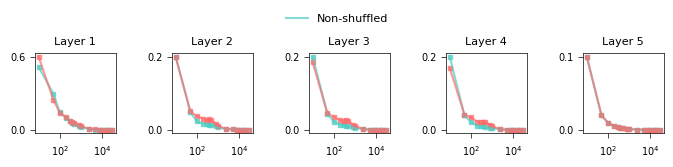

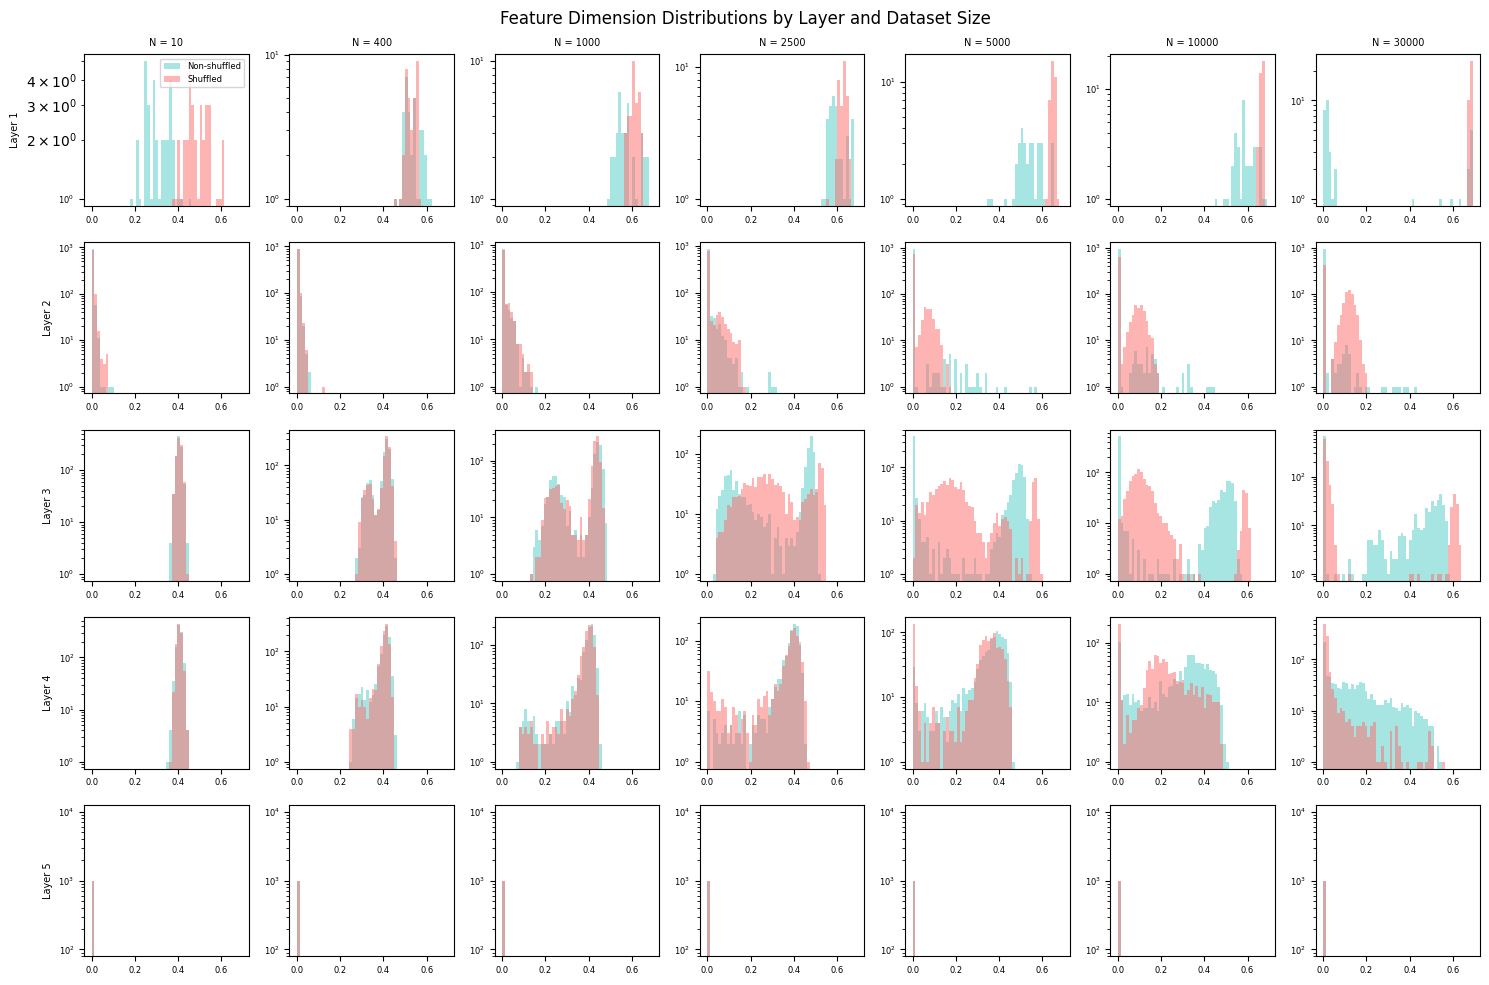

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dimensionality_analysis(metrics50, hidden_size50, raw_feature_dims50, raw_feature_dims50_shuffled,
                               dataset_sizes=[10, 50, 100, 200, 300, 400, 500, 800, 1000, 2500,
                                            5000, 8000, 10000, 15000, 20000, 30000],
                               sample_figsize=(7.0, 1.4),
                               hist_figsize=(15, 10),
                               marker_size=10,
                               linewidth=1.5,
                               title_size=8,
                               tick_size=7,
                               legend_size=8):
    """
    Creates two figures:
    1. Sample dimensionality comparison across layers
    2. Grid of histograms showing feature dimension distributions for each layer and dataset size
    
    Args:
        metrics50: Array containing sample dimensionality for non-shuffled data
        hidden_size50: Array containing sample dimensionality for shuffled data
        raw_feature_dims50: List of raw feature dimension arrays for non-shuffled data
        raw_feature_dims50_shuffled: List of raw feature dimension arrays for shuffled data
        dataset_sizes: List of dataset sizes used
        sample_figsize, hist_figsize: Figure sizes for the two plots
        marker_size, linewidth, title_size, tick_size, legend_size: Plot styling parameters
    """
    
    # 1. Sample Dimensionality Plot
    fig1, axs1 = plt.subplots(1, 5, figsize=sample_figsize)
    fig1.subplots_adjust(wspace=0.01)
    
    sample_dim = metrics50[0]  # Shape: (5, 15)
    sample_dim_shuffled = hidden_size50[0]  # Shape: (5, 15)
    
    for layer in range(5):
        ax = axs1[layer]
        
        # Plot lines and scatter points
        ax.plot(dataset_sizes, sample_dim[layer], color='#4ECDC4', alpha=0.7, linewidth=linewidth)
        ax.plot(dataset_sizes, sample_dim_shuffled[layer], color='#FF6B6B', alpha=0.7, linewidth=linewidth)
        
        ax.scatter(dataset_sizes, sample_dim[layer], color='#4ECDC4', marker='s', s=marker_size, alpha=0.7)
        ax.scatter(dataset_sizes, sample_dim_shuffled[layer], color='#FF6B6B', marker='s', s=marker_size, alpha=0.7)
        
        ax.set_title(f'Layer {layer+1}', fontsize=title_size)
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
        
        x_ticks = [10, 20000]
        y_min = min(sample_dim[layer].min(), sample_dim_shuffled[layer].min())
        y_max = max(sample_dim[layer].max(), sample_dim_shuffled[layer].max())
        y_ticks = [y_min, y_max]
        
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.set_xticklabels([f'{int(val)}' for val in ax.get_xticks()], fontsize=tick_size)
        ax.set_yticklabels([f'{val:.1f}' for val in ax.get_yticks()], fontsize=tick_size)
        ax.set_box_aspect(1)
        ax.tick_params(width=0.5)
        ax.set_xscale('log')
    
    lines = axs1[0].get_lines()[::2]
    fig1.legend(lines, ['Non-shuffled', 'Shuffled'],
              loc='upper center',
              bbox_to_anchor=(0.5, 1.2),
              ncol=2,
              fontsize=legend_size,
              frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # 2. Feature Dimensionality Histograms
    n_layers = 5
    n_datasets = len(dataset_sizes)
    selected_indices = [0, 5,8,9, 10,12, 15]  # Select a subset of dataset sizes to plot
    
    fig2, axs2 = plt.subplots(n_layers, len(selected_indices), figsize=hist_figsize)
    fig2.suptitle('Feature Dimension Distributions by Layer and Dataset Size', fontsize=12)
    
    # Calculate global min and max for consistent binning
    all_values = []
    for layer in range(n_layers):
        for dataset_idx in selected_indices:
            feat_dims = np.log1p(raw_feature_dims50[layer][dataset_idx])
            feat_dims_shuffled = np.log1p(raw_feature_dims50_shuffled[layer][dataset_idx])
            all_values.extend(feat_dims)
            all_values.extend(feat_dims_shuffled)
    
    global_min = min(all_values)
    global_max = max(all_values)
    bins = np.linspace(global_min, global_max, 55)
    
    for layer in range(n_layers):
        for idx, dataset_idx in enumerate(selected_indices):
            ax = axs2[layer, idx]
            
            # Get feature dimensions and apply log(x+1) transformation
            feat_dims = np.log1p(raw_feature_dims50[layer][dataset_idx])
            feat_dims_shuffled = np.log1p(raw_feature_dims50_shuffled[layer][dataset_idx])
            
            # Plot histograms with consistent bins and log scale for counts
            ax.hist(feat_dims, bins=bins, alpha=0.5, color='#4ECDC4', label='Non-shuffled', log=True)
            ax.hist(feat_dims_shuffled, bins=bins, alpha=0.5, color='#FF6B6B', label='Shuffled', log=True)
            
            # Set titles and labels
            if layer == 0:
                ax.set_title(f'N = {dataset_sizes[dataset_idx]}', fontsize=tick_size)
            if idx == 0:
                ax.set_ylabel(f'Layer {layer+1}', fontsize=tick_size)
            
            ax.tick_params(labelsize=6)
            
            # Only show legend for the first plot
            if layer == 0 and idx == 0:
                ax.legend(fontsize=6)
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_dimensionality_analysis(hidden_size400_false, hidden_size400_true, hidden_size400_raw_false, hidden_size400_raw_true)

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

def plot_dimensionality_analysis(metrics50, hidden_size50, raw_feature_dims50, raw_feature_dims50_shuffled,
                               dataset_sizes=[10, 50, 100, 200, 300, 400, 500, 800, 1000, 2500,
                                            5000, 8000, 10000, 15000, 20000, 30000],
                               marker_size=8,
                               linewidth=1.5,
                               tick_size=6,
                               legend_size=6):
    """
    Creates a single figure with two columns (Layer 1 and 3).
    Uses scientific plotting style with layer labels on top and N values on the side.
    """
    
    # Set up scientific plot style
    plt.style.use('default')
    mpl.rcParams.update({
        'axes.linewidth': 0.5,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'xtick.minor.width': 0.5,
        'ytick.minor.width': 0.5,
        'xtick.major.size': 3,
        'ytick.major.size': 3,
        'xtick.minor.size': 1.5,
        'ytick.minor.size': 1.5,
        'xtick.top': True,
        'ytick.right': True,
    })
    
    selected_sizes = [1000, 30000]
    size_indices = [dataset_sizes.index(size) for size in selected_sizes]
    selected_layers = [0, 2]  # Layer 1 and 3
    
    # Create figure with 2x3 grid
    fig = plt.figure(figsize=(4, 4))
    gs = fig.add_gridspec(3, 2, hspace=0.15, wspace=0.15)
    
    # Add layer labels at the top
    for col, layer in enumerate(selected_layers):
        fig.text(0.25 + col * 0.5, 0.95, f'Layer {layer+1}', 
                horizontalalignment='center', fontsize=tick_size)
    
    # Add N values on the left side
    for idx, n in enumerate(selected_sizes):
        fig.text(0.02, 0.63 - idx * 0.31, f'N = {n}', 
                verticalalignment='center', fontsize=tick_size)
    
    # Process both layers (columns)
    for col, layer in enumerate(selected_layers):
        # Top row: Sample dimensionality
        ax_top = fig.add_subplot(gs[0, col])
        
        sample_dim = metrics50[0]
        sample_dim_shuffled = hidden_size50[0]
        
        # Plot lines and scatter points
        ax_top.plot(dataset_sizes, sample_dim[layer], color='#4ECDC4', alpha=0.7, linewidth=linewidth)
        ax_top.plot(dataset_sizes, sample_dim_shuffled[layer], color='#FF6B6B', alpha=0.7, linewidth=linewidth)
        ax_top.scatter(dataset_sizes, sample_dim[layer], color='#4ECDC4', marker='s', s=marker_size, alpha=0.7)
        ax_top.scatter(dataset_sizes, sample_dim_shuffled[layer], color='#FF6B6B', marker='s', s=marker_size, alpha=0.7)
        
        # Set up axes
        x_ticks = [10, 20000]
        y_min = min(sample_dim[layer].min(), sample_dim_shuffled[layer].min())
        y_max = max(sample_dim[layer].max(), sample_dim_shuffled[layer].max())
        y_ticks = [y_min, y_max]
        
        ax_top.set_xticks(x_ticks)
        ax_top.set_yticks(y_ticks)
        ax_top.set_xticklabels([f'{int(val)}' for val in ax_top.get_xticks()], fontsize=tick_size)
        ax_top.set_yticklabels([f'{val:.1f}' for val in ax_top.get_yticks()], fontsize=tick_size)
        ax_top.set_box_aspect(0.6)
        ax_top.set_xscale('log')
        
        # Add legend only to Layer 1 plot
        if col == 0:
            ax_top.legend(['Non-shuffled', 'Shuffled'], 
                        loc='upper right', 
                        fontsize=legend_size, 
                        frameon=False)
        
        # Calculate binning for feature dimensionality plots
        all_values = []
        for dataset_idx in size_indices:
            feat_dims = np.log1p(raw_feature_dims50[layer][dataset_idx])
            feat_dims_shuffled = np.log1p(raw_feature_dims50_shuffled[layer][dataset_idx])
            all_values.extend(feat_dims)
            all_values.extend(feat_dims_shuffled)
        
        global_min = min(all_values)
        global_max = max(all_values)
        bins = np.linspace(global_min, global_max, 55)
        
        # Middle and bottom rows: Feature dimensionality
        for row_idx, dataset_idx in enumerate(size_indices):
            ax = fig.add_subplot(gs[row_idx + 1, col])
            
            feat_dims = np.log1p(raw_feature_dims50[layer][dataset_idx])
            feat_dims_shuffled = np.log1p(raw_feature_dims50_shuffled[layer][dataset_idx])
            
            ax.hist(feat_dims, bins=bins, alpha=0.5, color='#4ECDC4', label='Non-shuffled', log=True)
            ax.hist(feat_dims_shuffled, bins=bins, alpha=0.5, color='#FF6B6B', label='Shuffled', log=True)
            
            ax.tick_params(labelsize=6)
            ax.set_box_aspect(0.6)
    
    plt.savefig('combined_analysis.svg', format='svg', bbox_inches='tight', dpi=300)
    plt.close()

# Example usage remains the same:
plot_dimensionality_analysis(hidden_size400_false, hidden_size400_true, hidden_size400_raw_false, hidden_size400_raw_true)

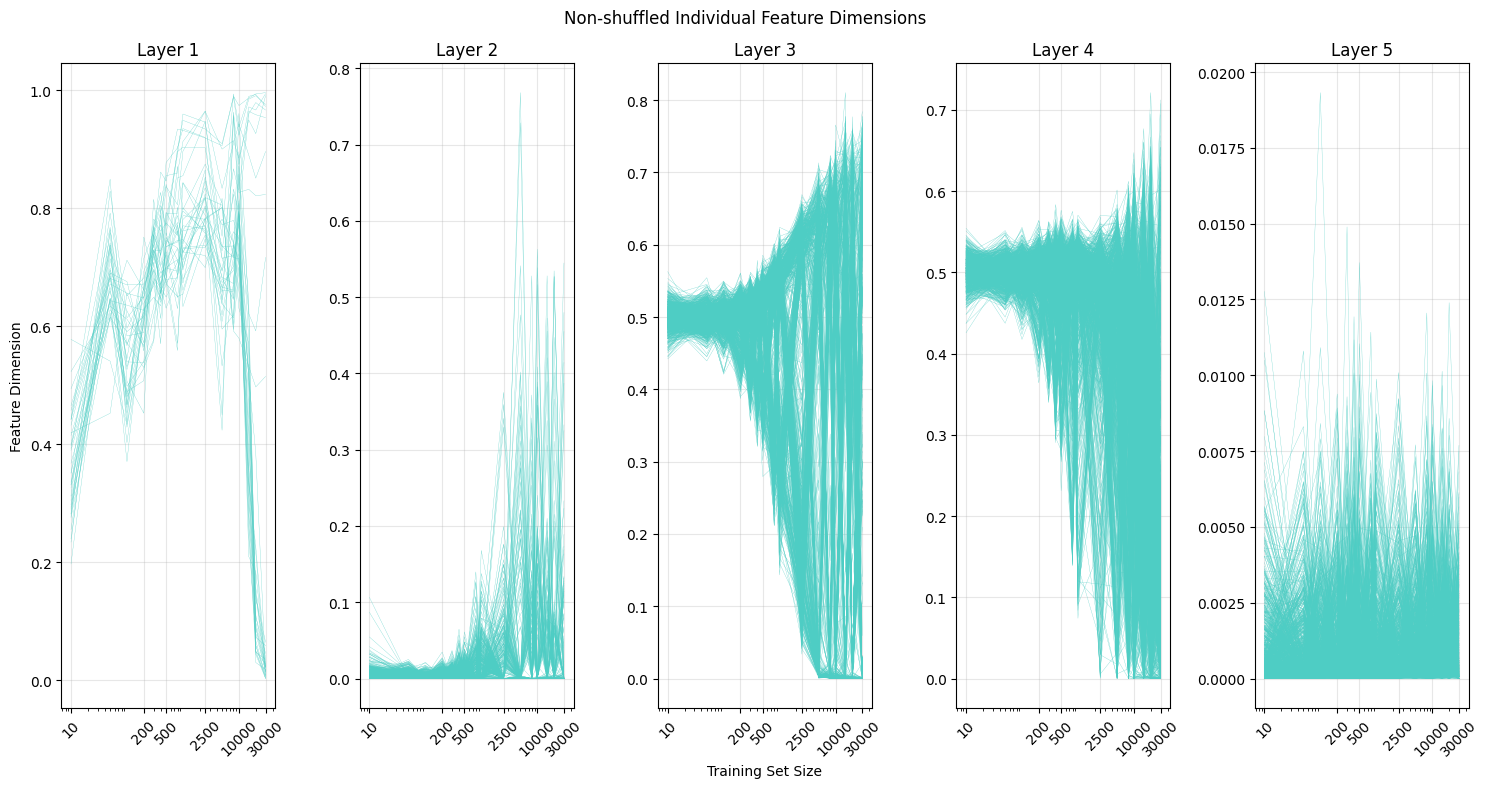

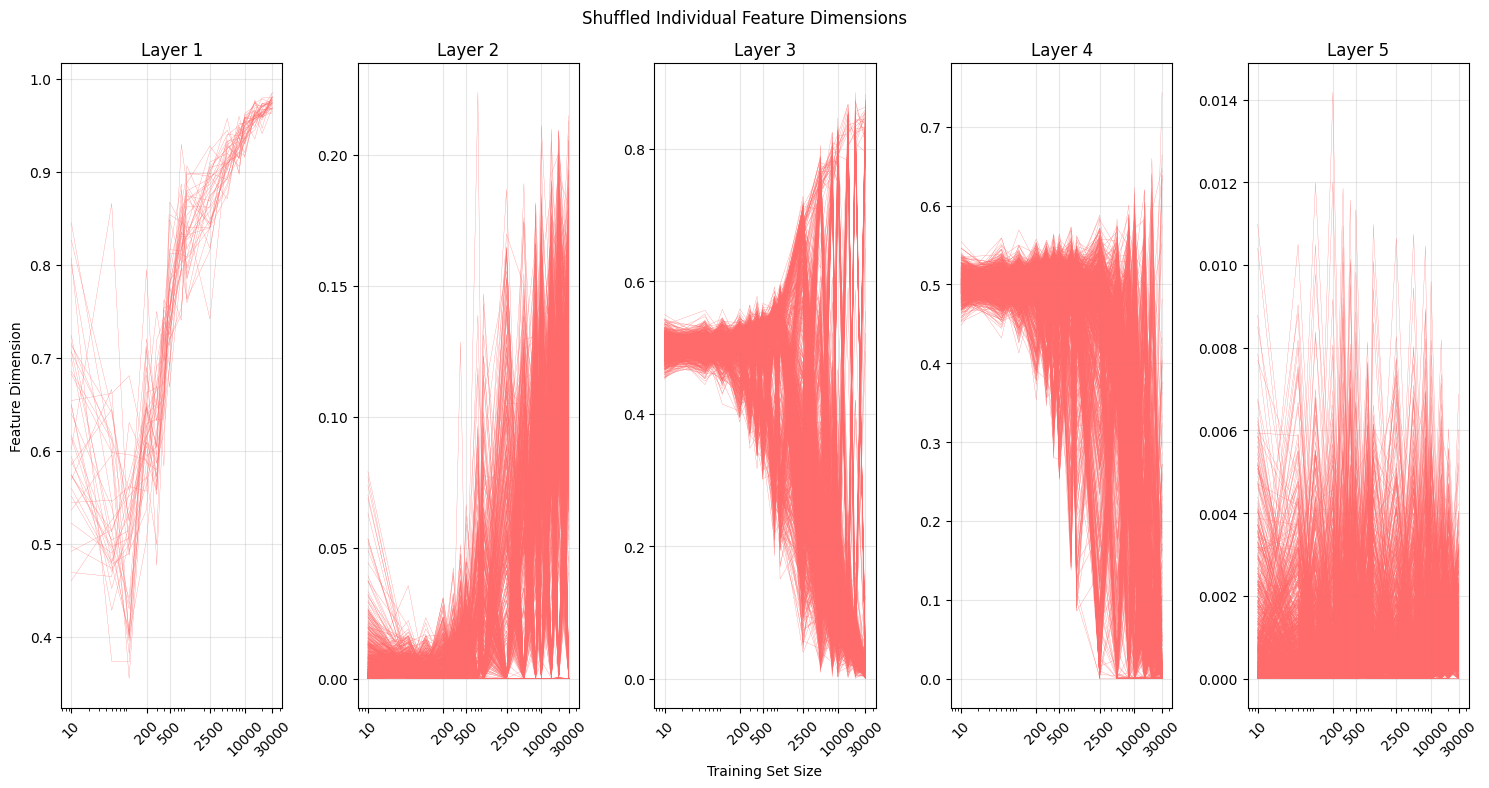

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_individual_feature_dimensions(metrics_non_shuffled, metrics_shuffled,
                                    dataset_sizes=[10, 50, 100, 200, 300, 400, 500, 800, 1000, 2500,
                                                 5000, 8000, 10000, 15000, 20000, 30000],
                                    figsize=(15, 8),
                                    alpha=0.1,
                                    linewidth=0.5,
                                    title_size=10,
                                    tick_size=8):
    """
    Creates two figures with 5 subplots each, showing the evolution of individual feature 
    dimensions across different training set sizes.
    """
    
    # Create figure for non-shuffled data
    fig1, axs1 = plt.subplots(1, 5, figsize=figsize)
    fig1.suptitle('Non-shuffled Feature Dimensions', fontsize=12)
    
    # Create figure for shuffled data
    fig2, axs2 = plt.subplots(1, 5, figsize=figsize)
    fig2.suptitle('Shuffled Feature Dimensions', fontsize=12)
    
    # Plot for each layer
    for layer in range(5):
        ax1 = axs1[layer]  # Non-shuffled plot
        ax2 = axs2[layer]  # Shuffled plot
        
        # Extract feature dimensions for non-shuffled and shuffled data
        feature_dims_non_shuffled = metrics_non_shuffled[2, layer, :]  # Feature dim means
        feature_dims_shuffled = metrics_shuffled[2, layer, :]  # Feature dim means
        
        # Plot trajectories
        ax1.plot(dataset_sizes, feature_dims_non_shuffled, 
                color='#4ECDC4', alpha=0.7, linewidth=linewidth)
        ax2.plot(dataset_sizes, feature_dims_shuffled, 
                color='#FF6B6B', alpha=0.7, linewidth=linewidth)
        
        # Configure axes for non-shuffled plot
        ax1.set_title(f'Layer {layer+1}', fontsize=title_size)
        ax1.set_xscale('log')
        ax1.tick_params(labelsize=tick_size)
        ax1.grid(True, alpha=0.3)
        
        # Configure axes for shuffled plot
        ax2.set_title(f'Layer {layer+1}', fontsize=title_size)
        ax2.set_xscale('log')
        ax2.tick_params(labelsize=tick_size)
        ax2.grid(True, alpha=0.3)
        
        # Set same y-axis limits for corresponding plots
        y_min = min(np.min(feature_dims_non_shuffled), np.min(feature_dims_shuffled))
        y_max = max(np.max(feature_dims_non_shuffled), np.max(feature_dims_shuffled))
        margin = (y_max - y_min) * 0.1
        
        ax1.set_ylim(y_min - margin, y_max + margin)
        ax2.set_ylim(y_min - margin, y_max + margin)
        
        # Only show dataset size ticks for bottom plots
        ax1.set_xticks(dataset_sizes[::3])  # Show every third tick to avoid crowding
        ax2.set_xticks(dataset_sizes[::3])
        
        ax1.set_xticklabels([f'{int(x)}' for x in dataset_sizes[::3]], rotation=45)
        ax2.set_xticklabels([f'{int(x)}' for x in dataset_sizes[::3]], rotation=45)
        
        # Add labels
        if layer == 0:
            ax1.set_ylabel('Feature Dimension')
            ax2.set_ylabel('Feature Dimension')
        if layer == 2:
            ax1.set_xlabel('Training Set Size')
            ax2.set_xlabel('Training Set Size')
    
    # Adjust layout
    fig1.tight_layout()
    fig2.tight_layout()
    
    plt.show()

def plot_feature_dimensions_detailed(raw_dims_non_shuffled, raw_dims_shuffled,
                                  dataset_sizes=[10, 50, 100, 200, 300, 400, 500, 800, 1000, 2500,
                                               5000, 8000, 10000, 15000, 20000, 30000],
                                  figsize=(15, 8),
                                  alpha=0.9,
                                  linewidth=0.2):
    """
    Creates two figures with 5 subplots each, showing individual feature dimension trajectories.
    This version plots all individual dimensions.
    """
    
    # Create figure for non-shuffled data
    fig1, axs1 = plt.subplots(1, 5, figsize=figsize)
    fig1.suptitle('Non-shuffled Individual Feature Dimensions', fontsize=12)
    
    # Create figure for shuffled data
    fig2, axs2 = plt.subplots(1, 5, figsize=figsize)
    fig2.suptitle('Shuffled Individual Feature Dimensions', fontsize=12)
    
    # Plot for each layer
    for layer in range(5):
        ax1 = axs1[layer]  # Non-shuffled plot
        ax2 = axs2[layer]  # Shuffled plot
        
        # Get dimensions for first dataset size to determine feature count
        n_features = len(raw_dims_non_shuffled[layer][0])
        
        # Plot each feature's trajectory
        for feature in range(n_features):
            # Get trajectory for this feature across all dataset sizes
            trajectory_non_shuffled = [raw_dims_non_shuffled[layer][ds_idx][feature] 
                                     for ds_idx in range(len(dataset_sizes))]
            trajectory_shuffled = [raw_dims_shuffled[layer][ds_idx][feature] 
                                 for ds_idx in range(len(dataset_sizes))]
            
            # Plot trajectories
            ax1.plot(dataset_sizes, trajectory_non_shuffled, 
                    color='#4ECDC4', alpha=alpha, linewidth=linewidth)
            ax2.plot(dataset_sizes, trajectory_shuffled, 
                    color='#FF6B6B', alpha=alpha, linewidth=linewidth)
        
        # Configure axes
        for ax in [ax1, ax2]:
            ax.set_title(f'Layer {layer+1}')
            ax.set_xscale('log')
            ax.grid(True, alpha=0.3)
            ax.set_xticks(dataset_sizes[::3])
            ax.set_xticklabels([f'{int(x)}' for x in dataset_sizes[::3]], rotation=45)
        
        # Add labels
        if layer == 0:
            ax1.set_ylabel('Feature Dimension')
            ax2.set_ylabel('Feature Dimension')
        if layer == 2:
            ax1.set_xlabel('Training Set Size')
            ax2.set_xlabel('Training Set Size')
    
    # Adjust layout
    fig1.tight_layout()
    fig2.tight_layout()
    
    plt.show()

# Example usage:
# First plot shows the mean feature dimensions
# plot_individual_feature_dimensions(metrics_non_shuffled, metrics_shuffled)

# Second plot shows all individual feature dimensions
plot_feature_dimensions_detailed(hidden_size400_raw_false,hidden_size400_raw_true)
#plot_individual_feature_dimensions(hidden_size400_false, hidden_size400_true, hidden_size400_raw_false,hidden_size400_raw_true )
#plot_dimensionality_analysis(hidden_size400_false, hidden_size400_true, hidden_size400_raw_false,hidden_size400_raw_true )

In [ ]:
######

In [3]:
import torch
import os
import json
import numpy as np
from typing import Tuple, Dict, List

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    # Load hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    # Load final results
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data"""
    # Get input dimension from hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    # Extract model parameters
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    
    # Construct model prefix
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    # Load final model
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode)
    model.load_state_dict(torch.load(model_path))
    
    # Load training data
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    X_train = train_data['X']
    y_train = train_data['y']
    
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard'):
        super().__init__()
        
        torch.set_default_dtype(torch.float32)
        
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            
            layers.extend([
                linear,
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float, torch.Tensor]:
    """
    Compute Anthropic's dimensionality metrics for both samples and features with standard deviations.
    Also returns the raw feature dimensionality array.
    
    Returns:
        Tuple containing:
        - sample_mean: float
        - sample_std: float
        - feature_mean: float
        - feature_std: float
        - feature_dims: torch.Tensor (raw feature dimensionality array)
    """
    with torch.no_grad():
        # Sample dimensionality (DXi)
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality (DXi)
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std, feature_dims

def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, timestamp: str, target_lr=None):
    """Analyze metrics across different dataset sizes and model widths"""
    input_dim = hyperparams['d']
    
    if target_lr is not None:
        results = [r for r in results if r['learning_rate'] == target_lr]
    
    # Group results by hidden_size
    width_groups = {}
    for result in results:
        hidden_size = result['hidden_size']
        if hidden_size not in width_groups:
            width_groups[hidden_size] = []
        width_groups[hidden_size].append(result)
    
    all_metrics = {}
    for hidden_size, group_results in width_groups.items():
        sorted_results = sorted(group_results, key=lambda x: x['n_train'])
        
        metrics = {
            'n_train': [],
            'layers': []
        }
        
        for result in sorted_results:
            print(f"Processing result: n_train={result['n_train']}, hidden_size={hidden_size}, lr={result['learning_rate']}")
            
            model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
            layer_metrics = analyze_dimensionality_by_layer(model, X_train)
            
            metrics['n_train'].append(result['n_train'])
            metrics['layers'].append(layer_metrics)
        
        all_metrics[hidden_size] = metrics
    
    return all_metrics

def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """
    Compute dimensionality metrics and their standard deviations for each layer.
    Now also includes raw feature dimensionality arrays.
    """
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue
            
            current_activation = layer(current_activation)
            
            sample_mean, sample_std, feature_mean, feature_std, feature_dims = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': sample_mean,
                    'sample_dim_std': sample_std,
                    'feature_dim': feature_mean,
                    'feature_dim_std': feature_std,
                    'feature_dims_raw': feature_dims.cpu().numpy()  # Store raw feature dimensions
                }
            })
    
    return layer_metrics

def extract_metrics_array(all_metrics: Dict, hidden_size: int) -> Tuple[np.ndarray, List[np.ndarray]]:
    """
    Extract metrics into a 3D numpy array and list of raw feature dimension arrays.
    
    Returns:
        Tuple containing:
        - np.ndarray: Array of shape (4, n_layers, n_datapoints) containing summary statistics
        - List[np.ndarray]: List of raw feature dimension arrays for each layer and datapoint
    """
    if hidden_size not in all_metrics:
        raise ValueError(f"Hidden size {hidden_size} not found in metrics")
        
    metrics = all_metrics[hidden_size]
    n_layers = len(metrics['layers'][0])  # Number of layers from first datapoint
    n_datapoints = len(metrics['layers'])  # Number of different dataset sizes
    n_dim_types = 4  # sample_dim, sample_dim_std, feature_dim, feature_dim_std
    
    # Initialize arrays
    result = np.zeros((n_dim_types, n_layers, n_datapoints))
    raw_feature_dims = [[[] for _ in range(n_datapoints)] for _ in range(n_layers)]
    
    # Fill arrays
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            # Summary statistics
            result[0, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim']
            result[1, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim_std']
            result[2, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim']
            result[3, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim_std']
            
            # Raw feature dimensions
            raw_feature_dims[layer_idx][dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dims_raw']
    
    print(f"Array shape: {result.shape}")
    print(f"- Number of dimension types: {n_dim_types}")
    print(f"- Number of layers: {n_layers}")
    print(f"- Number of datapoints: {n_datapoints}")
            
    return result, raw_feature_dims

# Example usage:
if __name__ == "__main__":
    results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0701_shuffled_mup_true_d1"
    data_dir = results_dir
    timestamp = "20250108_032521"

    # Load data
    results, hyperparams = load_experiment_data(results_dir, timestamp)

    # Analyze metrics
    all_metrics = analyze_by_dataset_size(results, hyperparams, data_dir, results_dir, timestamp, target_lr=0.001)

    # Extract arrays for hidden sizes 50 and 400
    hidden_size50_stats, hidden_size50_raw = extract_metrics_array(all_metrics, 1000)
    hidden_size400_true, hidden_size400_raw_true = extract_metrics_array(all_metrics, 8000)

    print("Hidden size 50 summary statistics shape:", hidden_size50_stats.shape)
    print("Number of layers with raw feature dimensions:", len(hidden_size50_raw))
    print("Example raw feature dimensions shape for first layer, first datapoint:", hidden_size50_raw[0][0].shape)

    #print("\nHidden size 400 summary statistics shape:", hidden_size400_stats.shape)
    #print("Number of layers with raw feature dimensions:", len(hidden_size400_raw))
    #print("Example raw feature dimensions shape for first layer, first datapoint:", hidden_size400_raw[0][0].shape)

Processing result: n_train=10, hidden_size=8000, lr=0.001


/tmp/ipykernel_1289867/2982993182.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_1289867/2982993182.py:50:

Processing result: n_train=50, hidden_size=8000, lr=0.001
Processing result: n_train=100, hidden_size=8000, lr=0.001
Processing result: n_train=200, hidden_size=8000, lr=0.001
Processing result: n_train=300, hidden_size=8000, lr=0.001
Processing result: n_train=400, hidden_size=8000, lr=0.001
Processing result: n_train=500, hidden_size=8000, lr=0.001
Processing result: n_train=800, hidden_size=8000, lr=0.001
Processing result: n_train=1000, hidden_size=8000, lr=0.001
Processing result: n_train=2500, hidden_size=8000, lr=0.001
Processing result: n_train=5000, hidden_size=8000, lr=0.001
Processing result: n_train=8000, hidden_size=8000, lr=0.001
Processing result: n_train=10000, hidden_size=8000, lr=0.001
Processing result: n_train=15000, hidden_size=8000, lr=0.001
Processing result: n_train=20000, hidden_size=8000, lr=0.001
Processing result: n_train=30000, hidden_size=8000, lr=0.001
Processing result: n_train=10, hidden_size=400, lr=0.001
Processing result: n_train=50, hidden_size=400,

In [2]:
import torch
import os
import json
import numpy as np
from typing import Tuple, Dict, List

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    # Load hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    # Load final results
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data"""
    # Get input dimension from hyperparameters
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    # Extract model parameters
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    
    # Construct model prefix
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    # Load final model
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode)
    model.load_state_dict(torch.load(model_path))
    
    # Load training data
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    X_train = train_data['X']
    y_train = train_data['y']
    
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard'):
        super().__init__()
        
        torch.set_default_dtype(torch.float32)
        
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            
            layers.extend([
                linear,
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float, torch.Tensor]:
    """
    Compute Anthropic's dimensionality metrics for both samples and features with standard deviations.
    Also returns the raw feature dimensionality array.
    
    Returns:
        Tuple containing:
        - sample_mean: float
        - sample_std: float
        - feature_mean: float
        - feature_std: float
        - feature_dims: torch.Tensor (raw feature dimensionality array)
    """
    with torch.no_grad():
        # Sample dimensionality (DXi)
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality (DXi)
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std, feature_dims

def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, timestamp: str, target_lr=None):
    """Analyze metrics across different dataset sizes and model widths"""
    input_dim = hyperparams['d']
    
    if target_lr is not None:
        results = [r for r in results if r['learning_rate'] == target_lr]
    
    # Group results by hidden_size
    width_groups = {}
    for result in results:
        hidden_size = result['hidden_size']
        if hidden_size not in width_groups:
            width_groups[hidden_size] = []
        width_groups[hidden_size].append(result)
    
    all_metrics = {}
    for hidden_size, group_results in width_groups.items():
        sorted_results = sorted(group_results, key=lambda x: x['n_train'])
        
        metrics = {
            'n_train': [],
            'layers': []
        }
        
        for result in sorted_results:
            print(f"Processing result: n_train={result['n_train']}, hidden_size={hidden_size}, lr={result['learning_rate']}")
            
            model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
            layer_metrics = analyze_dimensionality_by_layer(model, X_train)
            
            metrics['n_train'].append(result['n_train'])
            metrics['layers'].append(layer_metrics)
        
        all_metrics[hidden_size] = metrics
    
    return all_metrics

def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """
    Compute dimensionality metrics and their standard deviations for each layer.
    Now also includes raw feature dimensionality arrays.
    """
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue
            
            current_activation = layer(current_activation)
            
            sample_mean, sample_std, feature_mean, feature_std, feature_dims = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': sample_mean,
                    'sample_dim_std': sample_std,
                    'feature_dim': feature_mean,
                    'feature_dim_std': feature_std,
                    'feature_dims_raw': feature_dims.cpu().numpy()  # Store raw feature dimensions
                }
            })
    
    return layer_metrics

def extract_metrics_array(all_metrics: Dict, hidden_size: int) -> Tuple[np.ndarray, List[np.ndarray]]:
    """
    Extract metrics into a 3D numpy array and list of raw feature dimension arrays.
    
    Returns:
        Tuple containing:
        - np.ndarray: Array of shape (4, n_layers, n_datapoints) containing summary statistics
        - List[np.ndarray]: List of raw feature dimension arrays for each layer and datapoint
    """
    if hidden_size not in all_metrics:
        raise ValueError(f"Hidden size {hidden_size} not found in metrics")
        
    metrics = all_metrics[hidden_size]
    n_layers = len(metrics['layers'][0])  # Number of layers from first datapoint
    n_datapoints = len(metrics['layers'])  # Number of different dataset sizes
    n_dim_types = 4  # sample_dim, sample_dim_std, feature_dim, feature_dim_std
    
    # Initialize arrays
    result = np.zeros((n_dim_types, n_layers, n_datapoints))
    raw_feature_dims = [[[] for _ in range(n_datapoints)] for _ in range(n_layers)]
    
    # Fill arrays
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            # Summary statistics
            result[0, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim']
            result[1, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim_std']
            result[2, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim']
            result[3, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim_std']
            
            # Raw feature dimensions
            raw_feature_dims[layer_idx][dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dims_raw']
    
    print(f"Array shape: {result.shape}")
    print(f"- Number of dimension types: {n_dim_types}")
    print(f"- Number of layers: {n_layers}")
    print(f"- Number of datapoints: {n_datapoints}")
            
    return result, raw_feature_dims

# Example usage:
if __name__ == "__main__":
    results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0701_shuffled_mup_false_d1"
    data_dir = results_dir
    timestamp = "20250107_231954"

    # Load data
    results, hyperparams = load_experiment_data(results_dir, timestamp)

    # Analyze metrics
    all_metrics = analyze_by_dataset_size(results, hyperparams, data_dir, results_dir, timestamp, target_lr=0.001)

    # Extract arrays for hidden sizes 50 and 400
    hidden_size50_stats, hidden_size50_raw = extract_metrics_array(all_metrics, 1000)
    hidden_size400_false, hidden_size400_raw_false = extract_metrics_array(all_metrics, 8000)

    print("Hidden size 50 summary statistics shape:", hidden_size50_stats.shape)
    print("Number of layers with raw feature dimensions:", len(hidden_size50_raw))
    print("Example raw feature dimensions shape for first layer, first datapoint:", hidden_size50_raw[0][0].shape)

    #print("\nHidden size 400 summary statistics shape:", hidden_size400_stats.shape)
    #print("Number of layers with raw feature dimensions:", len(hidden_size400_raw))
    #print("Example raw feature dimensions shape for first layer, first datapoint:", hidden_size400_raw[0][0].shape)

Processing result: n_train=10, hidden_size=8000, lr=0.001


/tmp/ipykernel_1289867/3700877122.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_1289867/3700877122.py:50:

Processing result: n_train=50, hidden_size=8000, lr=0.001
Processing result: n_train=100, hidden_size=8000, lr=0.001
Processing result: n_train=200, hidden_size=8000, lr=0.001
Processing result: n_train=300, hidden_size=8000, lr=0.001
Processing result: n_train=400, hidden_size=8000, lr=0.001
Processing result: n_train=500, hidden_size=8000, lr=0.001
Processing result: n_train=800, hidden_size=8000, lr=0.001
Processing result: n_train=1000, hidden_size=8000, lr=0.001
Processing result: n_train=2500, hidden_size=8000, lr=0.001
Processing result: n_train=5000, hidden_size=8000, lr=0.001
Processing result: n_train=8000, hidden_size=8000, lr=0.001
Processing result: n_train=10000, hidden_size=8000, lr=0.001
Processing result: n_train=15000, hidden_size=8000, lr=0.001
Processing result: n_train=20000, hidden_size=8000, lr=0.001
Processing result: n_train=30000, hidden_size=8000, lr=0.001
Processing result: n_train=10, hidden_size=400, lr=0.001
Processing result: n_train=50, hidden_size=400,

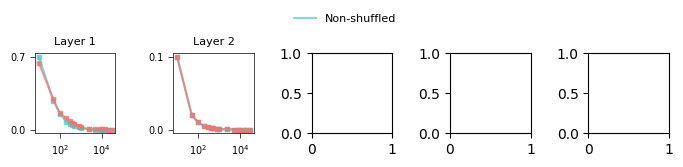

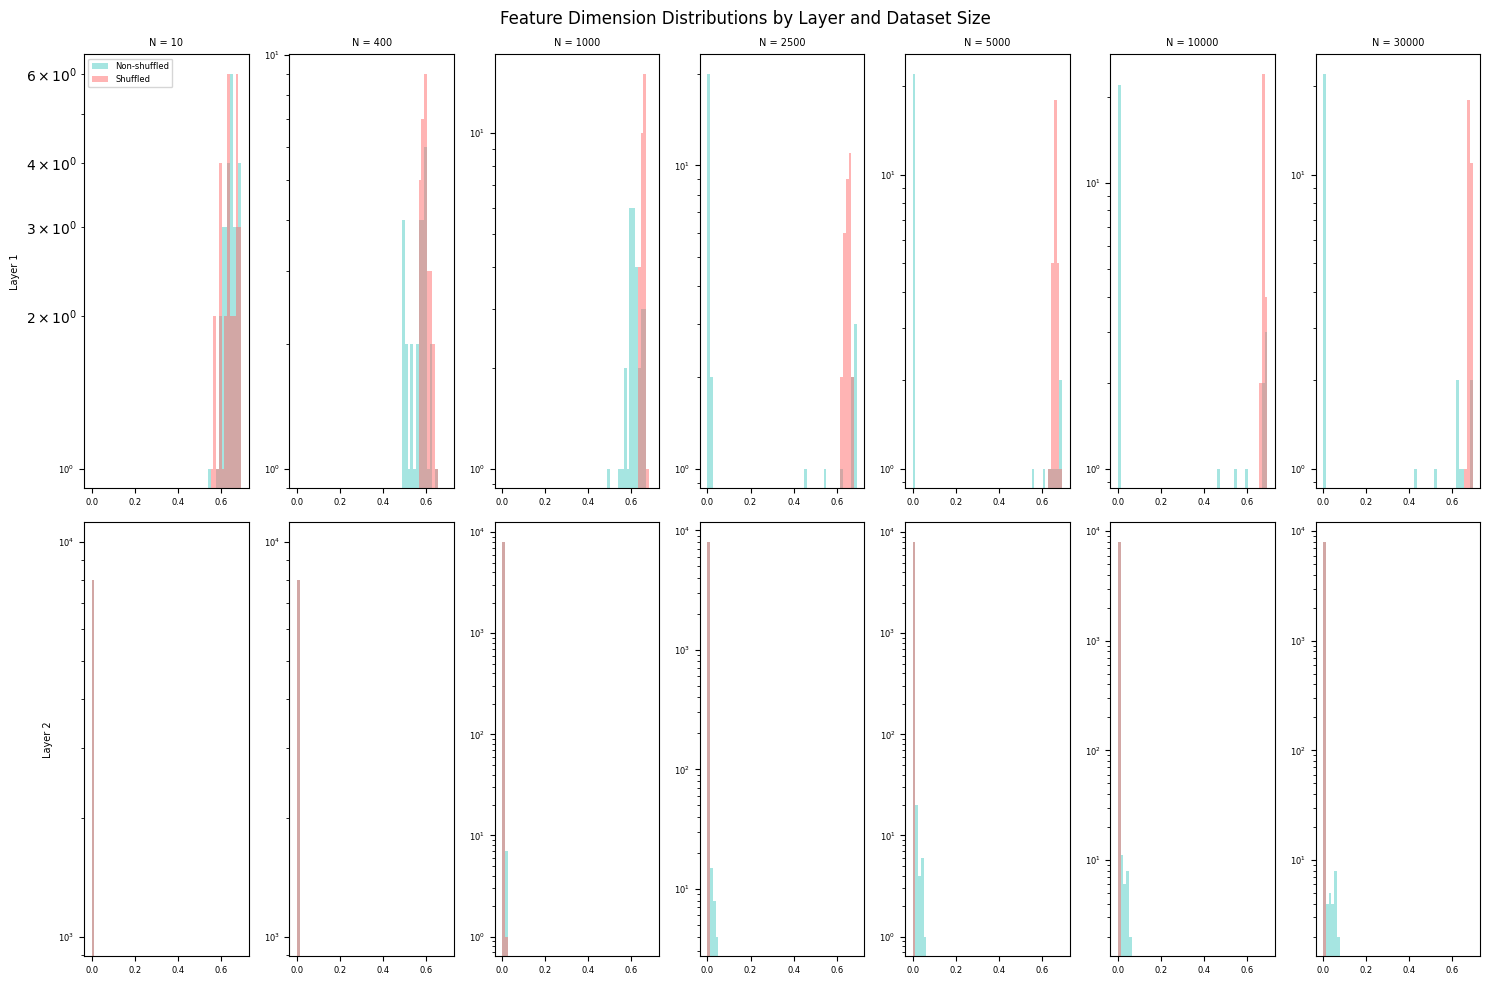

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dimensionality_analysis(metrics50, hidden_size50, raw_feature_dims50, raw_feature_dims50_shuffled,
                               dataset_sizes=[10, 50, 100, 200, 300, 400, 500, 800, 1000, 2500,
                                            5000, 8000, 10000, 15000, 20000, 30000],
                               sample_figsize=(7.0, 1.4),
                               hist_figsize=(15, 10),
                               marker_size=10,
                               linewidth=1.5,
                               title_size=8,
                               tick_size=7,
                               legend_size=8):
    """
    Creates two figures:
    1. Sample dimensionality comparison across layers
    2. Grid of histograms showing feature dimension distributions for each layer and dataset size
    
    Args:
        metrics50: Array containing sample dimensionality for non-shuffled data
        hidden_size50: Array containing sample dimensionality for shuffled data
        raw_feature_dims50: List of raw feature dimension arrays for non-shuffled data
        raw_feature_dims50_shuffled: List of raw feature dimension arrays for shuffled data
        dataset_sizes: List of dataset sizes used
        sample_figsize, hist_figsize: Figure sizes for the two plots
        marker_size, linewidth, title_size, tick_size, legend_size: Plot styling parameters
    """
    
    # 1. Sample Dimensionality Plot
    fig1, axs1 = plt.subplots(1, 5, figsize=sample_figsize)
    fig1.subplots_adjust(wspace=0.01)
    
    sample_dim = metrics50[0]  # Shape: (5, 15)
    sample_dim_shuffled = hidden_size50[0]  # Shape: (5, 15)
    n_layers = 2
    for layer in range(n_layers):
        ax = axs1[layer]
        
        # Plot lines and scatter points
        ax.plot(dataset_sizes, sample_dim[layer], color='#4ECDC4', alpha=0.7, linewidth=linewidth)
        ax.plot(dataset_sizes, sample_dim_shuffled[layer], color='#FF6B6B', alpha=0.7, linewidth=linewidth)
        
        ax.scatter(dataset_sizes, sample_dim[layer], color='#4ECDC4', marker='s', s=marker_size, alpha=0.7)
        ax.scatter(dataset_sizes, sample_dim_shuffled[layer], color='#FF6B6B', marker='s', s=marker_size, alpha=0.7)
        
        ax.set_title(f'Layer {layer+1}', fontsize=title_size)
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
        
        x_ticks = [10, 20000]
        y_min = min(sample_dim[layer].min(), sample_dim_shuffled[layer].min())
        y_max = max(sample_dim[layer].max(), sample_dim_shuffled[layer].max())
        y_ticks = [y_min, y_max]
        
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.set_xticklabels([f'{int(val)}' for val in ax.get_xticks()], fontsize=tick_size)
        ax.set_yticklabels([f'{val:.1f}' for val in ax.get_yticks()], fontsize=tick_size)
        ax.set_box_aspect(1)
        ax.tick_params(width=0.5)
        ax.set_xscale('log')
    
    lines = axs1[0].get_lines()[::2]
    fig1.legend(lines, ['Non-shuffled', 'Shuffled'],
              loc='upper center',
              bbox_to_anchor=(0.5, 1.2),
              ncol=2,
              fontsize=legend_size,
              frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # 2. Feature Dimensionality Histograms
    n_layers = 2
    n_datasets = len(dataset_sizes)
    selected_indices = [0, 5,8,9, 10,12, 15]  # Select a subset of dataset sizes to plot
    
    fig2, axs2 = plt.subplots(n_layers, len(selected_indices), figsize=hist_figsize)
    fig2.suptitle('Feature Dimension Distributions by Layer and Dataset Size', fontsize=12)
    
    # Calculate global min and max for consistent binning
    all_values = []
    for layer in range(n_layers):
        for dataset_idx in selected_indices:
            feat_dims = np.log1p(raw_feature_dims50[layer][dataset_idx])
            feat_dims_shuffled = np.log1p(raw_feature_dims50_shuffled[layer][dataset_idx])
            all_values.extend(feat_dims)
            all_values.extend(feat_dims_shuffled)
    
    global_min = min(all_values)
    global_max = max(all_values)
    bins = np.linspace(global_min, global_max, 55)
    
    for layer in range(n_layers):
        for idx, dataset_idx in enumerate(selected_indices):
            ax = axs2[layer, idx]
            
            # Get feature dimensions and apply log(x+1) transformation
            feat_dims = np.log1p(raw_feature_dims50[layer][dataset_idx])
            feat_dims_shuffled = np.log1p(raw_feature_dims50_shuffled[layer][dataset_idx])
            
            # Plot histograms with consistent bins and log scale for counts
            ax.hist(feat_dims, bins=bins, alpha=0.5, color='#4ECDC4', label='Non-shuffled', log=True)
            ax.hist(feat_dims_shuffled, bins=bins, alpha=0.5, color='#FF6B6B', label='Shuffled', log=True)
            
            # Set titles and labels
            if layer == 0:
                ax.set_title(f'N = {dataset_sizes[dataset_idx]}', fontsize=tick_size)
            if idx == 0:
                ax.set_ylabel(f'Layer {layer+1}', fontsize=tick_size)
            
            ax.tick_params(labelsize=6)
            
            # Only show legend for the first plot
            if layer == 0 and idx == 0:
                ax.legend(fontsize=6)
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_dimensionality_analysis(hidden_size400_false, hidden_size400_true, hidden_size400_raw_false, hidden_size400_raw_true)

In [ ]:
#####

Loading first model data...
Loading second model data...

Analyzing first model metrics...
Processing result: n_train=10, hidden_size=1000, lr=0.005


/tmp/ipykernel_1827572/716088432.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_1827572/716088432.py:85: F

Processing result: n_train=100, hidden_size=1000, lr=0.005
Processing result: n_train=500, hidden_size=1000, lr=0.005
Processing result: n_train=1000, hidden_size=1000, lr=0.005
Processing result: n_train=5000, hidden_size=1000, lr=0.005
Processing result: n_train=10000, hidden_size=1000, lr=0.005
Processing result: n_train=20000, hidden_size=1000, lr=0.005
Processing result: n_train=10, hidden_size=400, lr=0.005
Processing result: n_train=100, hidden_size=400, lr=0.005
Processing result: n_train=500, hidden_size=400, lr=0.005
Processing result: n_train=1000, hidden_size=400, lr=0.005
Processing result: n_train=5000, hidden_size=400, lr=0.005
Processing result: n_train=10000, hidden_size=400, lr=0.005
Processing result: n_train=20000, hidden_size=400, lr=0.005

Analyzing second model metrics...
Processing result: n_train=10, hidden_size=1000, lr=0.005
Processing result: n_train=100, hidden_size=1000, lr=0.005
Processing result: n_train=500, hidden_size=1000, lr=0.005
Processing result:

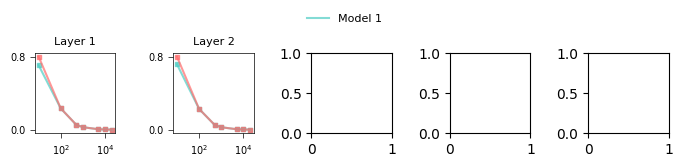

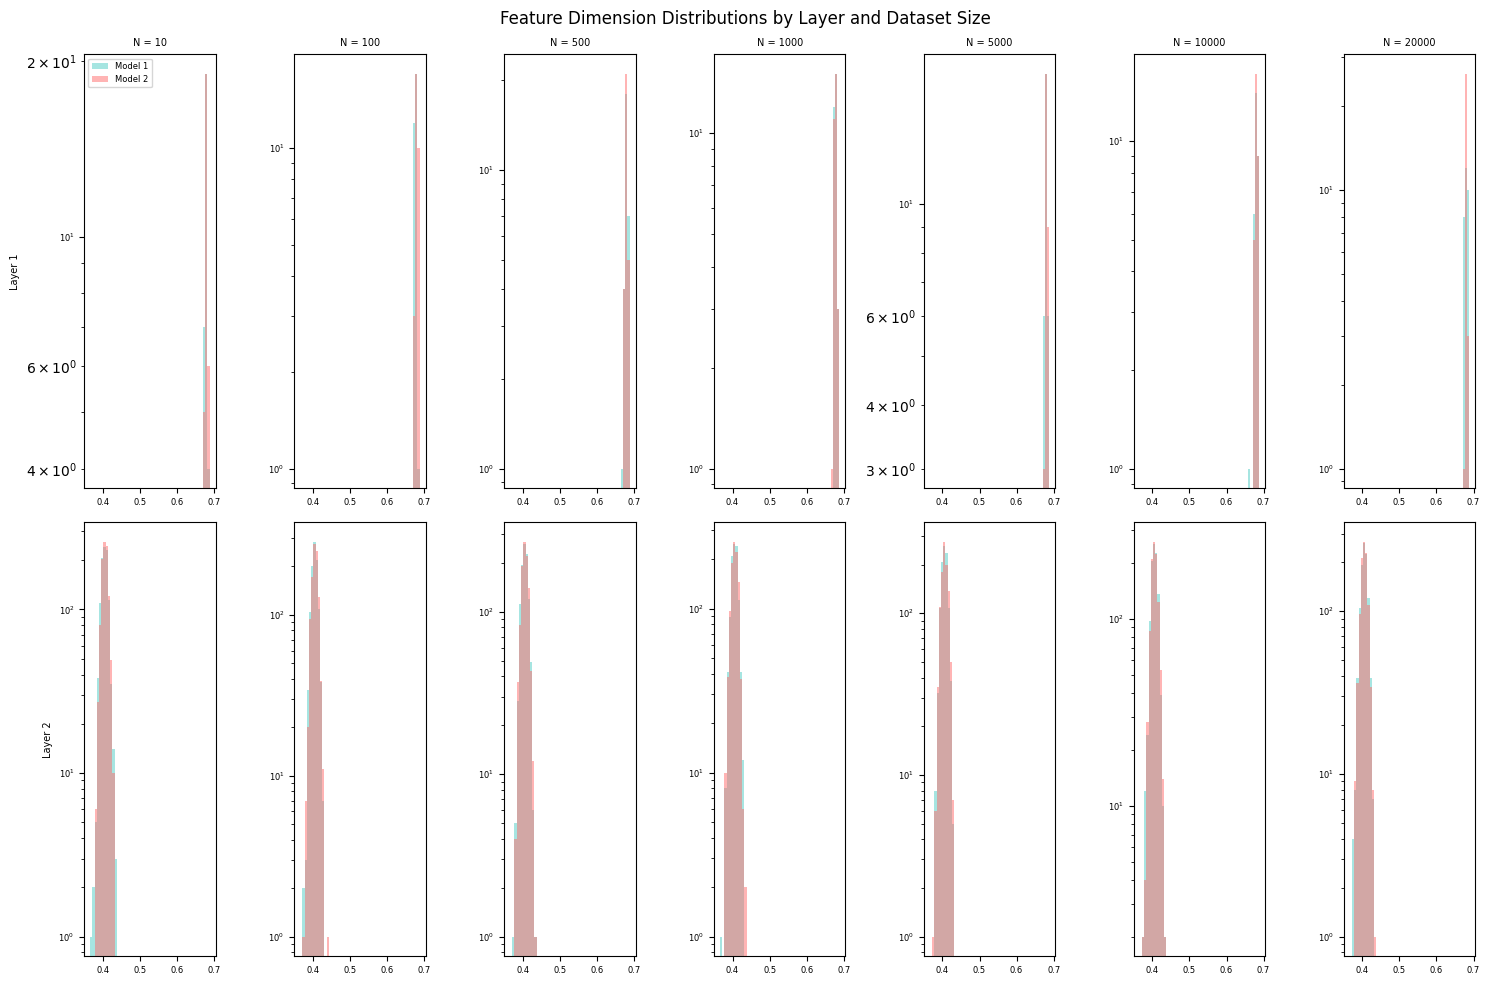

In [1]:
import torch
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard', gamma: float = 1.0):
        super().__init__()
        
        torch.set_default_dtype(torch.float32)
        
        self.gamma = gamma
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            
            layers.extend([
                linear,
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        gamma = float(self.gamma)  # Ensure gamma is a float
        return self.network(x).squeeze() / gamma

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    gamma = result.get('gamma', 1.0)
    
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_g{gamma}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode, gamma=gamma)
    model.load_state_dict(torch.load(model_path))
    
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    X_train = train_data['X']
    y_train = train_data['y']
    
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float, torch.Tensor]:
    """Compute Anthropic's dimensionality metrics"""
    with torch.no_grad():
        # Sample dimensionality
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std, feature_dims

def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, timestamp: str, target_lr=None):
    """Analyze metrics across different dataset sizes and model widths"""
    if target_lr is not None:
        results = [r for r in results if r['learning_rate'] == target_lr]
    
    width_groups = {}
    for result in results:
        hidden_size = result['hidden_size']
        if hidden_size not in width_groups:
            width_groups[hidden_size] = []
        width_groups[hidden_size].append(result)
    
    all_metrics = {}
    for hidden_size, group_results in width_groups.items():
        sorted_results = sorted(group_results, key=lambda x: x['n_train'])
        
        metrics = {
            'n_train': [],
            'layers': []
        }
        
        for result in sorted_results:
            print(f"Processing result: n_train={result['n_train']}, hidden_size={hidden_size}, lr={result['learning_rate']}")
            
            model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
            layer_metrics = analyze_dimensionality_by_layer(model, X_train)
            
            metrics['n_train'].append(result['n_train'])
            metrics['layers'].append(layer_metrics)
        
        all_metrics[hidden_size] = metrics
    
    return all_metrics

def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics for each layer"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue
            
            current_activation = layer(current_activation)
            
            sample_mean, sample_std, feature_mean, feature_std, feature_dims = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': sample_mean,
                    'sample_dim_std': sample_std,
                    'feature_dim': feature_mean,
                    'feature_dim_std': feature_std,
                    'feature_dims_raw': feature_dims.cpu().numpy()
                }
            })
    
    return layer_metrics

def extract_metrics_array(all_metrics: Dict, hidden_size: int) -> Tuple[np.ndarray, List[np.ndarray]]:
    """Extract metrics into numpy array and list of raw feature dimension arrays"""
    if hidden_size not in all_metrics:
        raise ValueError(f"Hidden size {hidden_size} not found in metrics")
        
    metrics = all_metrics[hidden_size]
    n_layers = len(metrics['layers'][0])
    n_datapoints = len(metrics['layers'])
    n_dim_types = 4
    
    result = np.zeros((n_dim_types, n_layers, n_datapoints))
    raw_feature_dims = [[[] for _ in range(n_datapoints)] for _ in range(n_layers)]
    
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            result[0, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim']
            result[1, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim_std']
            result[2, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim']
            result[3, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim_std']
            raw_feature_dims[layer_idx][dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dims_raw']
            
    return result, raw_feature_dims

def plot_dimensionality_comparison(metrics1, metrics2, raw_dims1, raw_dims2, dataset_sizes, label1="Model 1", label2="Model 2"):
    """Plot dimensionality analysis comparison between two models"""
    # Sample Dimensionality Plot
    fig1, axs1 = plt.subplots(1, 5, figsize=(7.0, 1.4))
    fig1.subplots_adjust(wspace=0.01)
    
    sample_dim1 = metrics1[0]
    sample_dim2 = metrics2[0]
    n_layers = 2
    
    for layer in range(n_layers):
        ax = axs1[layer]
        
        ax.plot(dataset_sizes, sample_dim1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5)
        ax.plot(dataset_sizes, sample_dim2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5)
        
        ax.scatter(dataset_sizes, sample_dim1[layer], color='#4ECDC4', marker='s', s=10, alpha=0.7)
        ax.scatter(dataset_sizes, sample_dim2[layer], color='#FF6B6B', marker='s', s=10, alpha=0.7)
        
        ax.set_title(f'Layer {layer+1}', fontsize=8)
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
        
        x_ticks = [10, 20000]
        y_min = min(sample_dim1[layer].min(), sample_dim2[layer].min())
        y_max = max(sample_dim1[layer].max(), sample_dim2[layer].max())
        y_ticks = [y_min, y_max]
        
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.set_xticklabels([f'{int(val)}' for val in ax.get_xticks()], fontsize=7)
        ax.set_yticklabels([f'{val:.1f}' for val in ax.get_yticks()], fontsize=7)
        ax.set_box_aspect(1)
        ax.tick_params(width=0.5)
        ax.set_xscale('log')
    
    lines = axs1[0].get_lines()[::2]
    fig1.legend(lines, [label1, label2],
               loc='upper center',
               bbox_to_anchor=(0.5, 1.2),
               ncol=2,
               fontsize=8,
               frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # Feature Dimensionality Histograms
    selected_indices = list(range(len(dataset_sizes)))
    
    fig2, axs2 = plt.subplots(n_layers, len(selected_indices), figsize=(15, 10))
    fig2.suptitle('Feature Dimension Distributions by Layer and Dataset Size', fontsize=12)
    
    all_values = []
    for layer in range(n_layers):
        for dataset_idx in selected_indices:
            feat_dims1 = np.log1p(raw_dims1[layer][dataset_idx])
            feat_dims2 = np.log1p(raw_dims2[layer][dataset_idx])
            all_values.extend(feat_dims1)
            all_values.extend(feat_dims2)
    
    bins = np.linspace(min(all_values), max(all_values), 55)
    
    for layer in range(n_layers):
        for idx, dataset_idx in enumerate(selected_indices):
            ax = axs2[layer, idx]
            
            feat_dims1 = np.log1p(raw_dims1[layer][dataset_idx])
            feat_dims2 = np.log1p(raw_dims2[layer][dataset_idx])
            
            ax.hist(feat_dims1, bins=bins, alpha=0.5, color='#4ECDC4', label=label1, log=True)
            ax.hist(feat_dims2, bins=bins, alpha=0.5, color='#FF6B6B', label=label2, log=True)
            
            if layer == 0:
                ax.set_title(f'N = {dataset_sizes[dataset_idx]}', fontsize=7)
            if idx == 0:
                ax.set_ylabel(f'Layer {layer+1}', fontsize=7)
            
            ax.tick_params(labelsize=6)
            
            if layer == 0 and idx == 0:
                ax.legend(fontsize=6)
    
    plt.tight_layout()
    plt.show()

# Example usage in notebook:
results_dir1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_spectrum_spectrum_false_standard_gamma_001_modelsaved"
results_dir2 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_spectrum_spectrum_true_standard_gamma_001_modelsaved"
timestamp1 = "20250124_202501"  # First model timestamp
timestamp2 = "20250124_202614"  # Second model timestamp
hidden_size = 1000  # The hidden size to analyze
target_lr = 0.005  # The learning rate used in training
gamma = 0.01  # The gamma value used in training
dataset_sizes = [10, 100, 500, 1000, 5000, 10000, 20000]  # The actual dataset sizes used

# Load data for first model
print("Loading first model data...")
results1, hyperparams1 = load_experiment_data(results_dir1, timestamp1)

# Load data for second model
print("Loading second model data...")
results2, hyperparams2 = load_experiment_data(results_dir2, timestamp2)

# Analyze metrics for first model
print("\nAnalyzing first model metrics...")
all_metrics1 = analyze_by_dataset_size(results1, hyperparams1, results_dir1, results_dir1, timestamp1, target_lr=target_lr)

# Analyze metrics for second model
print("\nAnalyzing second model metrics...")
all_metrics2 = analyze_by_dataset_size(results2, hyperparams2, results_dir2, results_dir2, timestamp2, target_lr=target_lr)

# Extract arrays for both models
print("\nExtracting metrics arrays...")
metrics1, raw_dims1 = extract_metrics_array(all_metrics1, hidden_size)
metrics2, raw_dims2 = extract_metrics_array(all_metrics2, hidden_size)

# Plot the comparison
print("\nPlotting comparison...")
plot_dimensionality_comparison(
    metrics1, 
    metrics2, 
    raw_dims1, 
    raw_dims2, 
    dataset_sizes,
    label1="Model 1",  # You can customize these labels
    label2="Model 2"
)


Debug info for Model 1 (Non-shuffled):
Number of training sizes: 8
Training sizes: [10, 100, 500, 1000, 2500, 5000, 10000, 20000]
Number of layers: 5
Raw dimensions structure:
- Number of datasets: 8
- Dimensions per layer: [30, 1000, 1000, 1000, 1000]

Debug info for Model 2 (Shuffled):
Number of training sizes: 8
Training sizes: [10, 100, 500, 1000, 2500, 5000, 10000, 20000]
Number of layers: 5
Raw dimensions structure:
- Number of datasets: 8
- Dimensions per layer: [30, 1000, 1000, 1000, 1000]
Loading and analyzing first model (non-shuffled)...
Processing result: n_train=10, hidden_size=2000, depth=4, lr=0.005, shuffled=False


/tmp/ipykernel_230681/1496771209.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_230681/1496771209.py:77: F

Processing result: n_train=100, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=500, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=1000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=2500, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=5000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=10000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=20000, hidden_size=2000, depth=4, lr=0.005, shuffled=False

Loading and analyzing second model (shuffled)...
Processing result: n_train=10, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_train=100, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_train=500, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_train=1000, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_tr

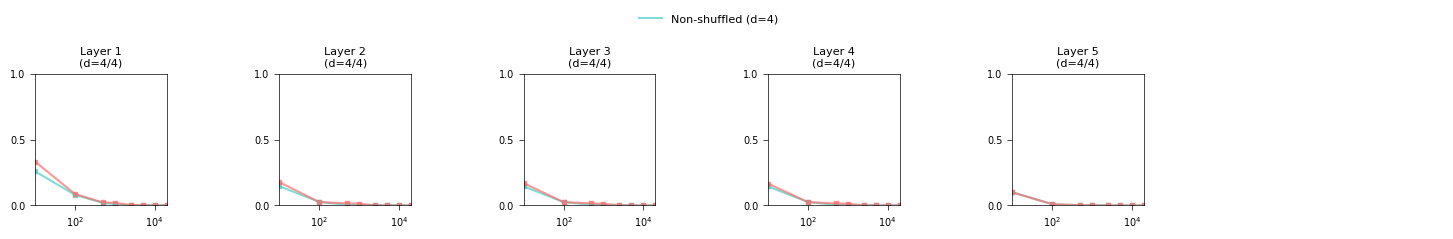

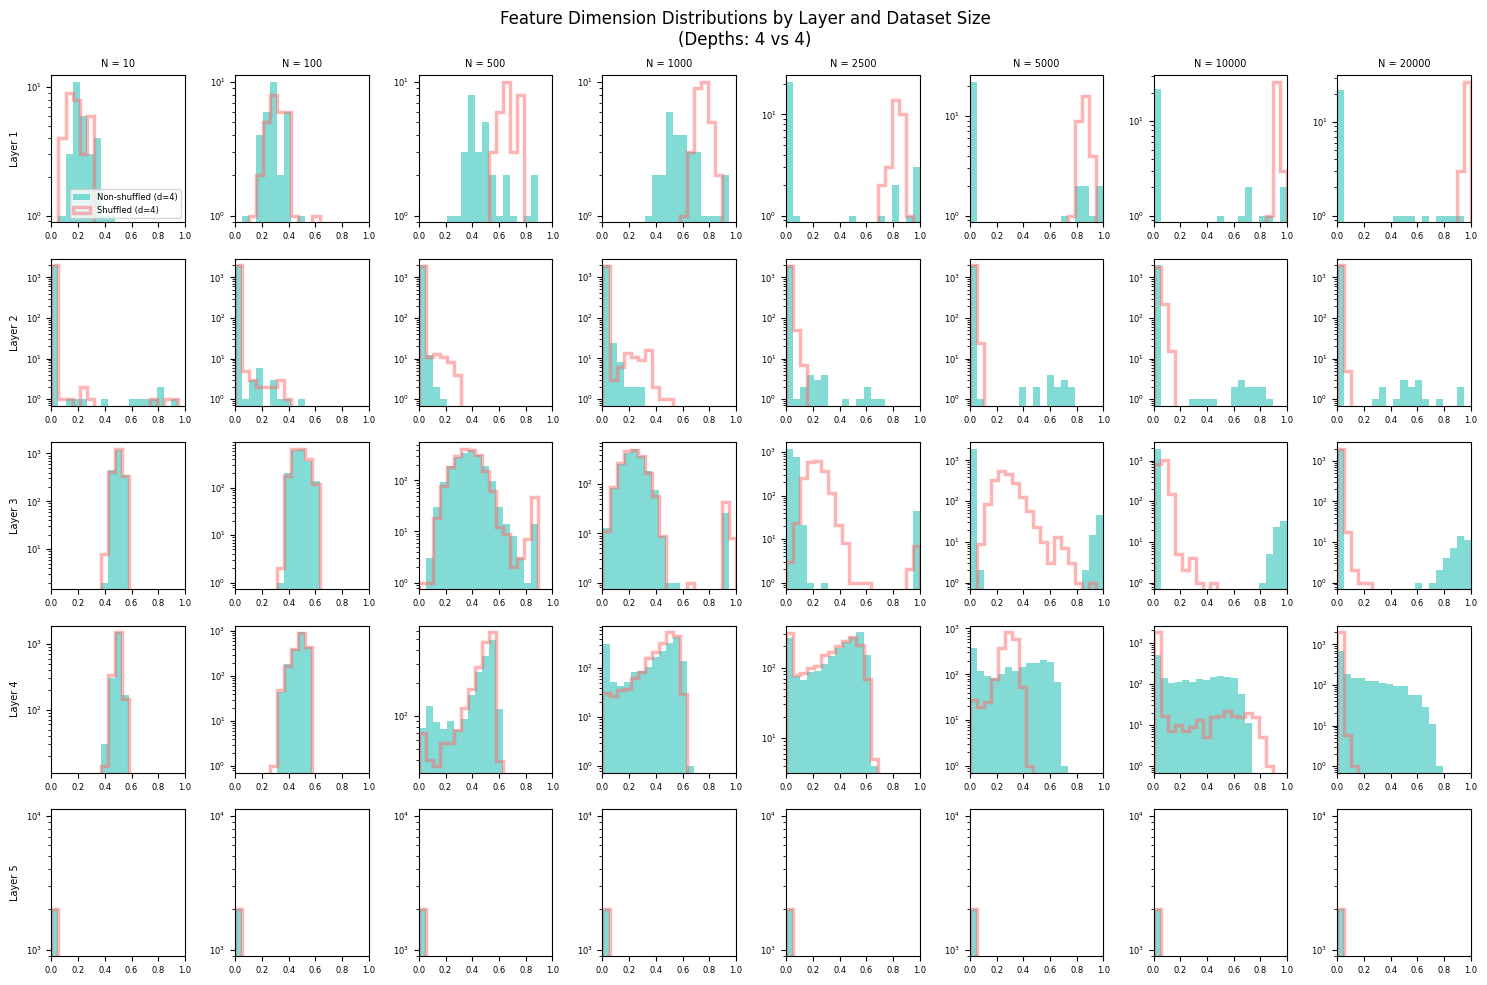

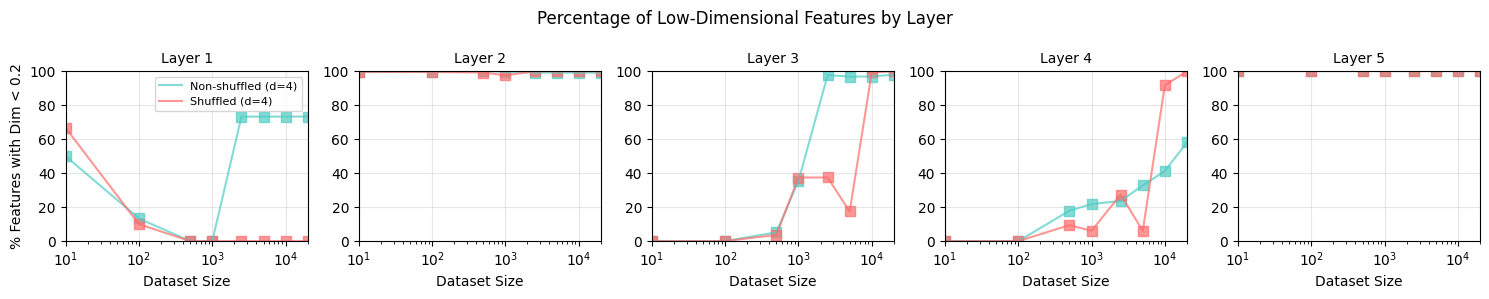

In [12]:
import torch
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard', gamma: float = 1.0):
        super().__init__()
        torch.set_default_dtype(torch.float32)
        self.gamma = gamma
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            layers.extend([linear, torch.nn.ReLU()])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze() / float(self.gamma)

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    gamma = result.get('gamma', 1.0)
    
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_g{gamma}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode, gamma=gamma)
    model.load_state_dict(torch.load(model_path))
    
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    X_train = train_data['X']
    y_train = train_data['y']
    
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float, torch.Tensor]:
    """Compute Anthropic's dimensionality metrics"""
    with torch.no_grad():
        # Sample dimensionality
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std, feature_dims
def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, 
                         timestamp: str, target_lr=None, target_hidden_size=None, target_depth=None):
    """Analyze metrics for specific model configuration"""
    # Filter results by learning rate and model architecture
    filtered_results = results
    if target_lr is not None:
        filtered_results = [r for r in filtered_results if r['learning_rate'] == target_lr]
    if target_hidden_size is not None:
        filtered_results = [r for r in filtered_results if r['hidden_size'] == target_hidden_size]
    if target_depth is not None:
        filtered_results = [r for r in filtered_results if r['depth'] == target_depth]
    
    # Sort by dataset size
    sorted_results = sorted(filtered_results, key=lambda x: x['n_train'])
    
    if not sorted_results:
        raise ValueError(f"No results found for specified configuration: lr={target_lr}, hidden_size={target_hidden_size}, depth={target_depth}")
    
    metrics = {
        'n_train': [],
        'layers': [],
        'raw_feature_dims': []  # Add storage for raw feature dimensions
    }
    
    for result in sorted_results:
        print(f"Processing result: n_train={result['n_train']}, "
              f"hidden_size={result['hidden_size']}, depth={result['depth']}, "
              f"lr={result['learning_rate']}, "
              f"shuffled={result.get('shuffled', False)}")
        
        model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
        layer_metrics = analyze_dimensionality_by_layer(model, X_train)
        
        metrics['n_train'].append(result['n_train'])
        metrics['layers'].append(layer_metrics)
        
        # Store raw feature dimensions for each layer
        raw_dims = []
        for layer_metric in layer_metrics:
            raw_dims.append(layer_metric['anthropic']['feature_dims_raw'])
        metrics['raw_feature_dims'].append(raw_dims)
    
    return metrics

def extract_metrics_array(metrics: Dict) -> Tuple[np.ndarray, List[List[np.ndarray]], List[List[float]]]:
    """Extract metrics into numpy array and list of raw feature dimension arrays with better dimension handling"""
    if not metrics['layers']:
        raise ValueError("No metrics data found")
        
    n_layers = len(metrics['layers'][0])
    n_datapoints = len(metrics['layers'])
    n_dim_types = 4
    
    result = np.zeros((n_dim_types, n_layers, n_datapoints))
    
    # Process regular metrics
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            result[0, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim']
            result[1, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim_std']
            result[2, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim']
            result[3, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim_std']
    
    # Process raw feature dimensions - now properly structured as [dataset][layer]
    raw_feature_dims = []
    for dp_idx in range(n_datapoints):
        layer_dims = []
        for layer_idx in range(n_layers):
            dims = metrics['layers'][dp_idx][layer_idx]['anthropic']['feature_dims_raw']
            layer_dims.append(dims)
        raw_feature_dims.append(layer_dims)
    
    # Calculate percentage of feature dimensions below threshold per layer
    low_dim_percentages = [[] for _ in range(n_layers)]
    for layer_idx in range(n_layers):
        for dp_idx in range(n_datapoints):
            feat_dims = raw_feature_dims[dp_idx][layer_idx]
            low_dims = np.sum(feat_dims < 0.2)
            total_dims = len(feat_dims)
            percentage = (low_dims / total_dims) * 100 if total_dims > 0 else 0
            low_dim_percentages[layer_idx].append(percentage)
    
    return result, raw_feature_dims, low_dim_percentages


def plot_dimensionality_comparison(metrics1, metrics2, raw_dims1, raw_dims2, 
                               low_dim_pct1, low_dim_pct2,
                               label1="Model 1", label2="Model 2",
                               sample_figsize=(15.0, 2.0),
                               hist_figsize=(15, 10),
                               low_dim_figsize=(15, 3),
                               depth1=None, depth2=None):
    """Plot dimensionality analysis comparison between two models with safer array handling"""
    # Get dataset sizes from the metrics
    dataset_sizes = metrics1['n_train']
    n_layers = len(metrics1['layers'][0])
    n_datasets = len(dataset_sizes)
    
    print(f"Debug info:")
    print(f"Number of layers: {n_layers}")
    print(f"Number of datasets: {n_datasets}")
    print(f"Dataset sizes: {dataset_sizes}")
    print(f"Raw dims1 structure: {len(raw_dims1)} x {len(raw_dims1[0]) if raw_dims1 else 0}")
    print(f"Raw dims2 structure: {len(raw_dims2)} x {len(raw_dims2[0]) if raw_dims2 else 0}")
    
    # Sample Dimensionality Plot
    fig1, axs1 = plt.subplots(1, n_layers + 1, figsize=sample_figsize)
    fig1.subplots_adjust(wspace=0.01)
    
    sample_dim1 = metrics1_arr[0]
    sample_dim2 = metrics2_arr[0]
    
    # Set up consistent y-axis limits
    y_min = 0.0
    y_max = 1.0
    
    for layer in range(n_layers):
        ax = axs1[layer]
        
        ax.plot(dataset_sizes, sample_dim1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5)
        ax.plot(dataset_sizes, sample_dim2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5)
        
        ax.scatter(dataset_sizes, sample_dim1[layer], color='#4ECDC4', marker='s', s=10, alpha=0.7)
        ax.scatter(dataset_sizes, sample_dim2[layer], color='#FF6B6B', marker='s', s=10, alpha=0.7)
        
        layer_title = f'Layer {layer+1}'
        if depth1 is not None and depth2 is not None:
            layer_title += f'\n(d={depth1}/{depth2})'
        ax.set_title(layer_title, fontsize=8)
        
        ax.set_ylim(y_min, y_max)
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=7)
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_xticks([1e2, 1e4])
        ax.set_xticklabels(['$10^2$', '$10^4$'], fontsize=7)
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            
        ax.tick_params(width=0.5)
        ax.set_box_aspect(1)
    
    axs1[-1].axis('off')
    
    if depth1 is not None and depth2 is not None:
        label1 = f"{label1} (d={depth1})"
        label2 = f"{label2} (d={depth2})"
    
    lines = axs1[0].get_lines()[::2]
    fig1.legend(lines, [label1, label2],
               loc='upper center',
               bbox_to_anchor=(0.5, 1.2),
               ncol=2,
               fontsize=8,
               frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # Feature Dimensionality Histograms with safer array handling
    fig2, axs2 = plt.subplots(n_layers, n_datasets, figsize=hist_figsize)
    title = 'Feature Dimension Distributions by Layer and Dataset Size'
    if depth1 is not None and depth2 is not None:
        title += f'\n(Depths: {depth1} vs {depth2})'
    fig2.suptitle(title, fontsize=12)
    
    x_min, x_max = 0.0, 1.0
    bins = np.linspace(x_min, x_max, 20)  # Reduced number of bins for thicker bars
    
    # Ensure axs2 is always 2D
    if n_layers == 1:
        axs2 = np.array([axs2])
    if n_datasets == 1:
        axs2 = np.array([axs2]).T
    
    for layer in range(n_layers):
        for idx in range(n_datasets):
            try:
                ax = axs2[layer, idx]
                
                # Safely access raw dimensions
                dims1 = raw_dims1[idx][layer] if idx < len(raw_dims1) and layer < len(raw_dims1[idx]) else []
                dims2 = raw_dims2[idx][layer] if idx < len(raw_dims2) and layer < len(raw_dims2[idx]) else []
                
                if len(dims1) > 0:
                    counts1, bins1, patches1 = ax.hist(dims1, bins=bins, alpha=0.7,  # Increased alpha
                                                     color='#4ECDC4', label=label1, 
                                                     histtype='stepfilled',
                                                     linewidth=2.0)  # Increased line width
                if len(dims2) > 0:
                    counts2, bins2, patches2 = ax.hist(dims2, bins=bins, alpha=0.5,
                                                     color='#FF6B6B', label=label2, 
                                                     histtype='step',
                                                     linewidth=2.5,  # Increased line width
                                                     edgecolor='#FF6B6B')
                
                if (len(dims1) > 0 and np.max(counts1) > 0) or (len(dims2) > 0 and np.max(counts2) > 0):
                    ax.set_yscale('log')
                
                ax.set_xlim(x_min, x_max)
                
                if layer == 0:
                    ax.set_title(f'N = {dataset_sizes[idx]}', fontsize=7)
                if idx == 0:
                    ax.set_ylabel(f'Layer {layer+1}', fontsize=7)
                
                ax.tick_params(labelsize=6)
                if layer == 0 and idx == 0:
                    ax.legend(fontsize=6)
                    
            except Exception as e:
                print(f"Error plotting histogram for layer {layer}, dataset {idx}: {str(e)}")
    
    plt.tight_layout()
    
    # Plot low-dimensional feature percentage per layer with safer array handling
    fig3, axs3 = plt.subplots(1, n_layers, figsize=low_dim_figsize)
    fig3.suptitle('Percentage of Low-Dimensional Features by Layer', fontsize=12)
    
    # Ensure axs3 is an array
    axs3 = np.atleast_1d(axs3)
    
    for layer in range(n_layers):
        ax = axs3[layer] if n_layers > 1 else axs3[0]
        
        try:
            ax.plot(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5, label=label1)
            ax.plot(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5, label=label2)
            
            ax.scatter(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', marker='s', s=50, alpha=0.7)
            ax.scatter(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', marker='s', s=50, alpha=0.7)
        except Exception as e:
            print(f"Error plotting low-dim percentages for layer {layer}: {str(e)}")
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_ylim(0, 100)
        
        ax.set_xlabel('Dataset Size', fontsize=10)
        if layer == 0:
            ax.set_ylabel('% Features with Dim < 0.2', fontsize=10)
        
        ax.set_title(f'Layer {layer+1}', fontsize=10)
        if layer == 0:
            ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



# Add this debug function
def print_metrics_info(metrics, raw_dims, label):
    print(f"\nDebug info for {label}:")
    print(f"Number of training sizes: {len(metrics['n_train'])}")
    print(f"Training sizes: {metrics['n_train']}")
    print(f"Number of layers: {len(metrics['layers'][0])}")
    print(f"Raw dimensions structure:")
    print(f"- Number of datasets: {len(raw_dims)}")
    if raw_dims:
        print(f"- Dimensions per layer: {[len(layer_dims) for layer_dims in raw_dims[0]]}")
    
# Before plotting, add debug info
#print_metrics_info(metrics1, raw_dims1, "Model 1 (Non-shuffled)")
#print_metrics_info(metrics2, raw_dims2, "Model 2 (Shuffled)")

# Example usage
results_dir1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_001_modelsaved"
results_dir2 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_001_modelsaved"
timestamp1 = "20250125_152950"  # First model timestamp
timestamp2 = "20250125_152857"  # Second model timestamp
hidden_size = 2000  # The hidden size to analyze
depth = 4 # The depth to analyze
target_lr = 0.005  # The learning rate used in training
gamma = 0.01  # The gamma value used in training
dataset_sizes = [10, 100, 500, 1000, 5000, 10000, 20000]  # The actual dataset sizes used
# Example usage with added debugging
print("Loading and analyzing first model (non-shuffled)...")
results1, hyperparams1 = load_experiment_data(results_dir1, timestamp1)
metrics1 = analyze_by_dataset_size(
    results1, 
    hyperparams1, 
    results_dir1, 
    results_dir1, 
    timestamp1, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

print("\nLoading and analyzing second model (shuffled)...")
results2, hyperparams2 = load_experiment_data(results_dir2, timestamp2)
metrics2 = analyze_by_dataset_size(
    results2, 
    hyperparams2, 
    results_dir2, 
    results_dir2, 
    timestamp2, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

# Extract arrays with debugging information
print("\nExtracting metrics arrays...")
metrics1_arr, raw_dims1, low_dim_pct1 = extract_metrics_array(metrics1)
metrics2_arr, raw_dims2, low_dim_pct2 = extract_metrics_array(metrics2)

# Additional debugging prints
print(f"\nMetrics shapes:")
print(f"metrics1_arr shape: {metrics1_arr.shape}")
print(f"metrics2_arr shape: {metrics2_arr.shape}")
print(f"Number of dataset sizes: {len(metrics1['n_train'])}")
print(f"Dataset sizes in first model: {metrics1['n_train']}")
print(f"Dataset sizes in second model: {metrics2['n_train']}")

# Plot with additional debugging information
print("\nPlotting comparison...")
plot_dimensionality_comparison(
    metrics1, 
    metrics2, 
    raw_dims1, 
    raw_dims2, 
    low_dim_pct1,
    low_dim_pct2,
    label1="Non-shuffled",
    label2="Shuffled",
    depth1=depth,
    depth2=depth
)

In [ ]:
import torch
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard', gamma: float = 1.0):
        super().__init__()
        torch.set_default_dtype(torch.float32)
        self.gamma = gamma
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            layers.extend([linear, torch.nn.ReLU()])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze() / float(self.gamma)

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    gamma = result.get('gamma', 1.0)
    
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_g{gamma}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode, gamma=gamma)
    model.load_state_dict(torch.load(model_path))
    
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    X_train = train_data['X']
    y_train = train_data['y']
    
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float, torch.Tensor]:
    """Compute Anthropic's dimensionality metrics"""
    with torch.no_grad():
        # Sample dimensionality
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std, feature_dims
def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, 
                         timestamp: str, target_lr=None, target_hidden_size=None, target_depth=None):
    """Analyze metrics for specific model configuration"""
    # Filter results by learning rate and model architecture
    filtered_results = results
    if target_lr is not None:
        filtered_results = [r for r in filtered_results if r['learning_rate'] == target_lr]
    if target_hidden_size is not None:
        filtered_results = [r for r in filtered_results if r['hidden_size'] == target_hidden_size]
    if target_depth is not None:
        filtered_results = [r for r in filtered_results if r['depth'] == target_depth]
    
    # Sort by dataset size
    sorted_results = sorted(filtered_results, key=lambda x: x['n_train'])
    
    if not sorted_results:
        raise ValueError(f"No results found for specified configuration: lr={target_lr}, hidden_size={target_hidden_size}, depth={target_depth}")
    
    metrics = {
        'n_train': [],
        'layers': [],
        'raw_feature_dims': []  # Add storage for raw feature dimensions
    }
    
    for result in sorted_results:
        print(f"Processing result: n_train={result['n_train']}, "
              f"hidden_size={result['hidden_size']}, depth={result['depth']}, "
              f"lr={result['learning_rate']}, "
              f"shuffled={result.get('shuffled', False)}")
        
        model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
        layer_metrics = analyze_dimensionality_by_layer(model, X_train)
        
        metrics['n_train'].append(result['n_train'])
        metrics['layers'].append(layer_metrics)
        
        # Store raw feature dimensions for each layer
        raw_dims = []
        for layer_metric in layer_metrics:
            raw_dims.append(layer_metric['anthropic']['feature_dims_raw'])
        metrics['raw_feature_dims'].append(raw_dims)
    
    return metrics

def extract_metrics_array(metrics: Dict) -> Tuple[np.ndarray, List[List[np.ndarray]], List[List[float]]]:
    """Extract metrics into numpy array and list of raw feature dimension arrays with better dimension handling"""
    if not metrics['layers']:
        raise ValueError("No metrics data found")
        
    n_layers = len(metrics['layers'][0])
    n_datapoints = len(metrics['layers'])
    n_dim_types = 4
    
    result = np.zeros((n_dim_types, n_layers, n_datapoints))
    
    # Process regular metrics
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            result[0, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim']
            result[1, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim_std']
            result[2, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim']
            result[3, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim_std']
    
    # Process raw feature dimensions - now properly structured as [dataset][layer]
    raw_feature_dims = []
    for dp_idx in range(n_datapoints):
        layer_dims = []
        for layer_idx in range(n_layers):
            dims = metrics['layers'][dp_idx][layer_idx]['anthropic']['feature_dims_raw']
            layer_dims.append(dims)
        raw_feature_dims.append(layer_dims)
    
    # Calculate percentage of feature dimensions below threshold per layer
    low_dim_percentages = [[] for _ in range(n_layers)]
    for layer_idx in range(n_layers):
        for dp_idx in range(n_datapoints):
            feat_dims = raw_feature_dims[dp_idx][layer_idx]
            low_dims = np.sum(feat_dims < 0.2)
            total_dims = len(feat_dims)
            percentage = (low_dims / total_dims) * 100 if total_dims > 0 else 0
            low_dim_percentages[layer_idx].append(percentage)
    
    return result, raw_feature_dims, low_dim_percentages


def plot_dimensionality_comparison(metrics1, metrics2, raw_dims1, raw_dims2, 
                               low_dim_pct1, low_dim_pct2,
                               label1="Model 1", label2="Model 2",
                               sample_figsize=(15.0, 2.0),
                               hist_figsize=(15, 10),
                               low_dim_figsize=(15, 3),
                               depth1=None, depth2=None):
    """Plot dimensionality analysis comparison between two models with safer array handling"""
    # Get dataset sizes from the metrics
    dataset_sizes = metrics1['n_train']
    n_layers = len(metrics1['layers'][0])
    n_datasets = len(dataset_sizes)
    
    print(f"Debug info:")
    print(f"Number of layers: {n_layers}")
    print(f"Number of datasets: {n_datasets}")
    print(f"Dataset sizes: {dataset_sizes}")
    print(f"Raw dims1 structure: {len(raw_dims1)} x {len(raw_dims1[0]) if raw_dims1 else 0}")
    print(f"Raw dims2 structure: {len(raw_dims2)} x {len(raw_dims2[0]) if raw_dims2 else 0}")
    
    # Sample Dimensionality Plot
    fig1, axs1 = plt.subplots(1, n_layers + 1, figsize=sample_figsize)
    fig1.subplots_adjust(wspace=0.01)
    
    sample_dim1 = metrics1_arr[0]
    sample_dim2 = metrics2_arr[0]
    
    # Set up consistent y-axis limits
    y_min = 0.0
    y_max = 1.0
    
    for layer in range(n_layers):
        ax = axs1[layer]
        
        ax.plot(dataset_sizes, sample_dim1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5)
        ax.plot(dataset_sizes, sample_dim2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5)
        
        ax.scatter(dataset_sizes, sample_dim1[layer], color='#4ECDC4', marker='s', s=10, alpha=0.7)
        ax.scatter(dataset_sizes, sample_dim2[layer], color='#FF6B6B', marker='s', s=10, alpha=0.7)
        
        layer_title = f'Layer {layer+1}'
        if depth1 is not None and depth2 is not None:
            layer_title += f'\n(d={depth1}/{depth2})'
        ax.set_title(layer_title, fontsize=8)
        
        ax.set_ylim(y_min, y_max)
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=7)
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_xticks([1e2, 1e4])
        ax.set_xticklabels(['$10^2$', '$10^4$'], fontsize=7)
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            
        ax.tick_params(width=0.5)
        ax.set_box_aspect(1)
    
    axs1[-1].axis('off')
    
    if depth1 is not None and depth2 is not None:
        label1 = f"{label1} (d={depth1})"
        label2 = f"{label2} (d={depth2})"
    
    lines = axs1[0].get_lines()[::2]
    fig1.legend(lines, [label1, label2],
               loc='upper center',
               bbox_to_anchor=(0.5, 1.2),
               ncol=2,
               fontsize=8,
               frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # Feature Dimensionality Histograms with safer array handling
    fig2, axs2 = plt.subplots(n_layers, n_datasets, figsize=hist_figsize)
    title = 'Feature Dimension Distributions by Layer and Dataset Size'
    if depth1 is not None and depth2 is not None:
        title += f'\n(Depths: {depth1} vs {depth2})'
    fig2.suptitle(title, fontsize=12)
    
    x_min, x_max = 0.0, 1.0
    bins = np.linspace(x_min, x_max, 20)  # Reduced number of bins for thicker bars
    
    # Ensure axs2 is always 2D
    if n_layers == 1:
        axs2 = np.array([axs2])
    if n_datasets == 1:
        axs2 = np.array([axs2]).T
    
    for layer in range(n_layers):
        for idx in range(n_datasets):
            try:
                ax = axs2[layer, idx]
                
                # Safely access raw dimensions
                dims1 = raw_dims1[idx][layer] if idx < len(raw_dims1) and layer < len(raw_dims1[idx]) else []
                dims2 = raw_dims2[idx][layer] if idx < len(raw_dims2) and layer < len(raw_dims2[idx]) else []
                
                if len(dims1) > 0:
                    counts1, bins1, patches1 = ax.hist(dims1, bins=bins, alpha=0.7,  # Increased alpha
                                                     color='#4ECDC4', label=label1, 
                                                     histtype='stepfilled',
                                                     linewidth=2.0)  # Increased line width
                if len(dims2) > 0:
                    counts2, bins2, patches2 = ax.hist(dims2, bins=bins, alpha=0.5,
                                                     color='#FF6B6B', label=label2, 
                                                     histtype='step',
                                                     linewidth=2.5,  # Increased line width
                                                     edgecolor='#FF6B6B')
                
                if (len(dims1) > 0 and np.max(counts1) > 0) or (len(dims2) > 0 and np.max(counts2) > 0):
                    ax.set_yscale('log')
                
                ax.set_xlim(x_min, x_max)
                
                if layer == 0:
                    ax.set_title(f'N = {dataset_sizes[idx]}', fontsize=7)
                if idx == 0:
                    ax.set_ylabel(f'Layer {layer+1}', fontsize=7)
                
                ax.tick_params(labelsize=6)
                if layer == 0 and idx == 0:
                    ax.legend(fontsize=6)
                    
            except Exception as e:
                print(f"Error plotting histogram for layer {layer}, dataset {idx}: {str(e)}")
    
    plt.tight_layout()
    
    # Plot low-dimensional feature percentage per layer with safer array handling
    fig3, axs3 = plt.subplots(1, n_layers, figsize=low_dim_figsize)
    fig3.suptitle('Percentage of Low-Dimensional Features by Layer', fontsize=12)
    
    # Ensure axs3 is an array
    axs3 = np.atleast_1d(axs3)
    
    for layer in range(n_layers):
        ax = axs3[layer] if n_layers > 1 else axs3[0]
        
        try:
            ax.plot(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5, label=label1)
            ax.plot(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5, label=label2)
            
            ax.scatter(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', marker='s', s=50, alpha=0.7)
            ax.scatter(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', marker='s', s=50, alpha=0.7)
        except Exception as e:
            print(f"Error plotting low-dim percentages for layer {layer}: {str(e)}")
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_ylim(0, 100)
        
        ax.set_xlabel('Dataset Size', fontsize=10)
        if layer == 0:
            ax.set_ylabel('% Features with Dim < 0.2', fontsize=10)
        
        ax.set_title(f'Layer {layer+1}', fontsize=10)
        if layer == 0:
            ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



# Add this debug function
def print_metrics_info(metrics, raw_dims, label):
    print(f"\nDebug info for {label}:")
    print(f"Number of training sizes: {len(metrics['n_train'])}")
    print(f"Training sizes: {metrics['n_train']}")
    print(f"Number of layers: {len(metrics['layers'][0])}")
    print(f"Raw dimensions structure:")
    print(f"- Number of datasets: {len(raw_dims)}")
    if raw_dims:
        print(f"- Dimensions per layer: {[len(layer_dims) for layer_dims in raw_dims[0]]}")
    
# Before plotting, add debug info
#print_metrics_info(metrics1, raw_dims1, "Model 1 (Non-shuffled)")
#print_metrics_info(metrics2, raw_dims2, "Model 2 (Shuffled)")

# Example usage
results_dir1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_100_modelsaved"
results_dir2 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_100_modelsaved"
timestamp1 = "20250125_153215"  # First model timestamp
timestamp2 = "20250125_153233"  # Second model timestamp
hidden_size = 2000  # The hidden size to analyze
depth = 4 # The depth to analyze
target_lr = 0.005  # The learning rate used in training
gamma = 100  # The gamma value used in training
dataset_sizes = [10, 100, 500, 1000, 5000, 10000, 20000]  # The actual dataset sizes used
# Example usage with added debugging
print("Loading and analyzing first model (non-shuffled)...")
results1, hyperparams1 = load_experiment_data(results_dir1, timestamp1)
metrics1 = analyze_by_dataset_size(
    results1, 
    hyperparams1, 
    results_dir1, 
    results_dir1, 
    timestamp1, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

print("\nLoading and analyzing second model (shuffled)...")
results2, hyperparams2 = load_experiment_data(results_dir2, timestamp2)
metrics2 = analyze_by_dataset_size(
    results2, 
    hyperparams2, 
    results_dir2, 
    results_dir2, 
    timestamp2, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

# Extract arrays with debugging information
print("\nExtracting metrics arrays...")
metrics1_arr, raw_dims1, low_dim_pct1 = extract_metrics_array(metrics1)
metrics2_arr, raw_dims2, low_dim_pct2 = extract_metrics_array(metrics2)

# Additional debugging prints
print(f"\nMetrics shapes:")
print(f"metrics1_arr shape: {metrics1_arr.shape}")
print(f"metrics2_arr shape: {metrics2_arr.shape}")
print(f"Number of dataset sizes: {len(metrics1['n_train'])}")
print(f"Dataset sizes in first model: {metrics1['n_train']}")
print(f"Dataset sizes in second model: {metrics2['n_train']}")

# Plot with additional debugging information
print("\nPlotting comparison...")
plot_dimensionality_comparison(
    metrics1, 
    metrics2, 
    raw_dims1, 
    raw_dims2, 
    low_dim_pct1,
    low_dim_pct2,
    label1="Non-shuffled",
    label2="Shuffled",
    depth1=depth,
    depth2=depth
)

NameError: name 'metrics1' is not defined

Loading and analyzing first model (non-shuffled)...
Processing result: n_train=10, hidden_size=2000, depth=4, lr=0.005, shuffled=False


/tmp/ipykernel_1998588/2954069892.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_1998588/2954069892.py:77:

Processing result: n_train=100, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=500, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=1000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=2500, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=5000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=10000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=20000, hidden_size=2000, depth=4, lr=0.005, shuffled=False

Loading and analyzing second model (shuffled)...
Processing result: n_train=10, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_train=100, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_train=500, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_train=1000, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_tr

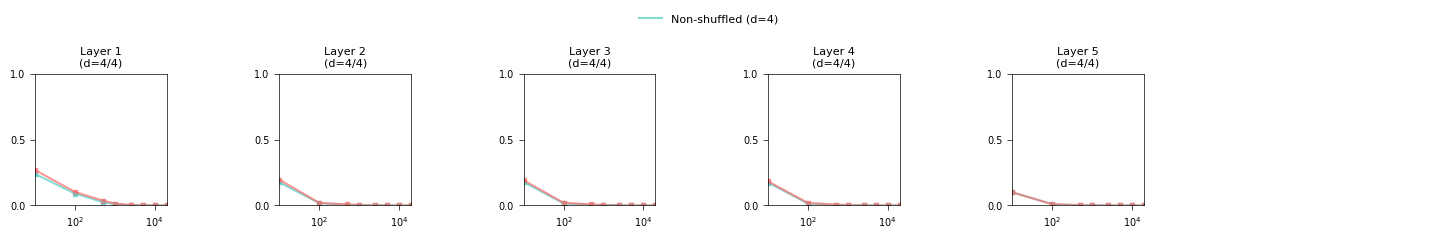

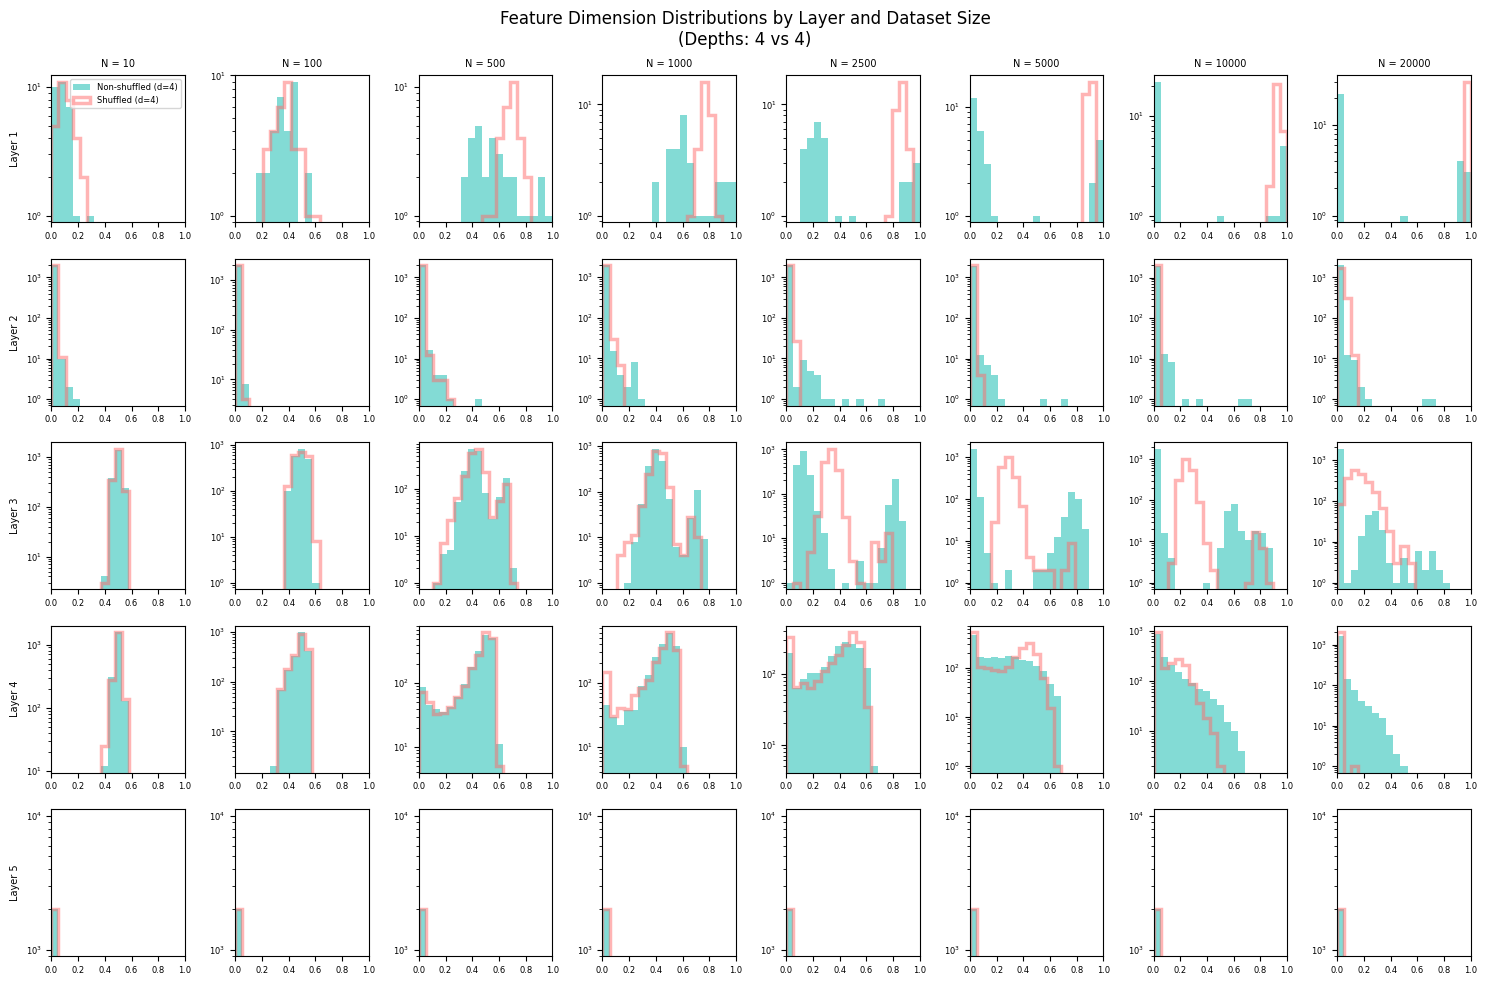

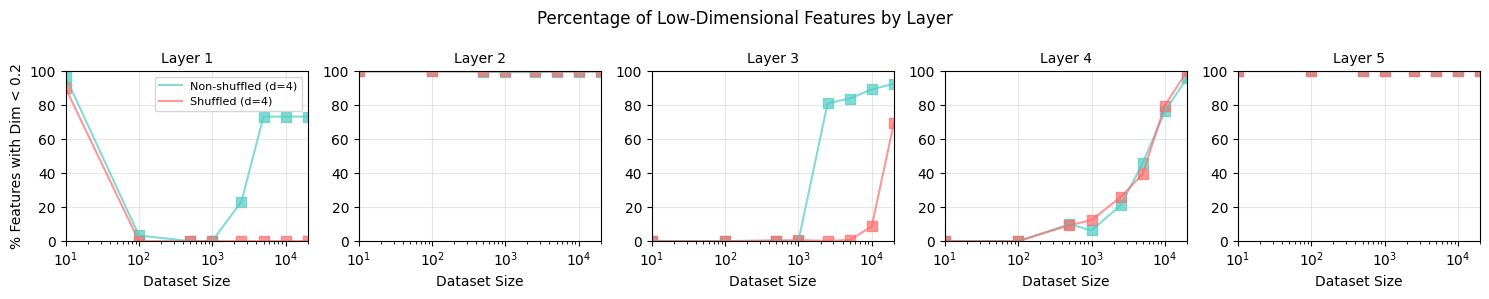

In [11]:
import torch
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard', gamma: float = 1.0):
        super().__init__()
        torch.set_default_dtype(torch.float32)
        self.gamma = gamma
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            layers.extend([linear, torch.nn.ReLU()])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze() / float(self.gamma)

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    gamma = result.get('gamma', 1.0)
    
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_g{gamma}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode, gamma=gamma)
    model.load_state_dict(torch.load(model_path))
    
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    X_train = train_data['X']
    y_train = train_data['y']
    
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float, torch.Tensor]:
    """Compute Anthropic's dimensionality metrics"""
    with torch.no_grad():
        # Sample dimensionality
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std, feature_dims
def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, 
                         timestamp: str, target_lr=None, target_hidden_size=None, target_depth=None):
    """Analyze metrics for specific model configuration"""
    # Filter results by learning rate and model architecture
    filtered_results = results
    if target_lr is not None:
        filtered_results = [r for r in filtered_results if r['learning_rate'] == target_lr]
    if target_hidden_size is not None:
        filtered_results = [r for r in filtered_results if r['hidden_size'] == target_hidden_size]
    if target_depth is not None:
        filtered_results = [r for r in filtered_results if r['depth'] == target_depth]
    
    # Sort by dataset size
    sorted_results = sorted(filtered_results, key=lambda x: x['n_train'])
    
    if not sorted_results:
        raise ValueError(f"No results found for specified configuration: lr={target_lr}, hidden_size={target_hidden_size}, depth={target_depth}")
    
    metrics = {
        'n_train': [],
        'layers': [],
        'raw_feature_dims': []  # Add storage for raw feature dimensions
    }
    
    for result in sorted_results:
        print(f"Processing result: n_train={result['n_train']}, "
              f"hidden_size={result['hidden_size']}, depth={result['depth']}, "
              f"lr={result['learning_rate']}, "
              f"shuffled={result.get('shuffled', False)}")
        
        model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
        layer_metrics = analyze_dimensionality_by_layer(model, X_train)
        
        metrics['n_train'].append(result['n_train'])
        metrics['layers'].append(layer_metrics)
        
        # Store raw feature dimensions for each layer
        raw_dims = []
        for layer_metric in layer_metrics:
            raw_dims.append(layer_metric['anthropic']['feature_dims_raw'])
        metrics['raw_feature_dims'].append(raw_dims)
    
    return metrics

def extract_metrics_array(metrics: Dict) -> Tuple[np.ndarray, List[List[np.ndarray]], List[List[float]]]:
    """Extract metrics into numpy array and list of raw feature dimension arrays with better dimension handling"""
    if not metrics['layers']:
        raise ValueError("No metrics data found")
        
    n_layers = len(metrics['layers'][0])
    n_datapoints = len(metrics['layers'])
    n_dim_types = 4
    
    result = np.zeros((n_dim_types, n_layers, n_datapoints))
    
    # Process regular metrics
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            result[0, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim']
            result[1, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim_std']
            result[2, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim']
            result[3, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim_std']
    
    # Process raw feature dimensions - now properly structured as [dataset][layer]
    raw_feature_dims = []
    for dp_idx in range(n_datapoints):
        layer_dims = []
        for layer_idx in range(n_layers):
            dims = metrics['layers'][dp_idx][layer_idx]['anthropic']['feature_dims_raw']
            layer_dims.append(dims)
        raw_feature_dims.append(layer_dims)
    
    # Calculate percentage of feature dimensions below threshold per layer
    low_dim_percentages = [[] for _ in range(n_layers)]
    for layer_idx in range(n_layers):
        for dp_idx in range(n_datapoints):
            feat_dims = raw_feature_dims[dp_idx][layer_idx]
            low_dims = np.sum(feat_dims < 0.2)
            total_dims = len(feat_dims)
            percentage = (low_dims / total_dims) * 100 if total_dims > 0 else 0
            low_dim_percentages[layer_idx].append(percentage)
    
    return result, raw_feature_dims, low_dim_percentages



def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics for each layer"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue
            
            current_activation = layer(current_activation)
            
            sample_mean, sample_std, feature_mean, feature_std, feature_dims = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': sample_mean,
                    'sample_dim_std': sample_std,
                    'feature_dim': feature_mean,
                    'feature_dim_std': feature_std,
                    'feature_dims_raw': feature_dims.cpu().numpy()
                }
            })
    
    return layer_metrics

def plot_dimensionality_comparison(metrics1, metrics2, raw_dims1, raw_dims2, 
                               low_dim_pct1, low_dim_pct2,
                               label1="Model 1", label2="Model 2",
                               sample_figsize=(15.0, 2.0),
                               hist_figsize=(15, 10),
                               low_dim_figsize=(15, 3),
                               depth1=None, depth2=None):
    """Plot dimensionality analysis comparison between two models with safer array handling"""
    # Get dataset sizes from the metrics
    dataset_sizes = metrics1['n_train']
    n_layers = len(metrics1['layers'][0])
    n_datasets = len(dataset_sizes)
    
    print(f"Debug info:")
    print(f"Number of layers: {n_layers}")
    print(f"Number of datasets: {n_datasets}")
    print(f"Dataset sizes: {dataset_sizes}")
    print(f"Raw dims1 structure: {len(raw_dims1)} x {len(raw_dims1[0]) if raw_dims1 else 0}")
    print(f"Raw dims2 structure: {len(raw_dims2)} x {len(raw_dims2[0]) if raw_dims2 else 0}")
    
    # Sample Dimensionality Plot
    fig1, axs1 = plt.subplots(1, n_layers + 1, figsize=sample_figsize)
    fig1.subplots_adjust(wspace=0.01)
    
    sample_dim1 = metrics1_arr[0]
    sample_dim2 = metrics2_arr[0]
    
    # Set up consistent y-axis limits
    y_min = 0.0
    y_max = 1.0
    
    for layer in range(n_layers):
        ax = axs1[layer]
        
        ax.plot(dataset_sizes, sample_dim1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5)
        ax.plot(dataset_sizes, sample_dim2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5)
        
        ax.scatter(dataset_sizes, sample_dim1[layer], color='#4ECDC4', marker='s', s=10, alpha=0.7)
        ax.scatter(dataset_sizes, sample_dim2[layer], color='#FF6B6B', marker='s', s=10, alpha=0.7)
        
        layer_title = f'Layer {layer+1}'
        if depth1 is not None and depth2 is not None:
            layer_title += f'\n(d={depth1}/{depth2})'
        ax.set_title(layer_title, fontsize=8)
        
        ax.set_ylim(y_min, y_max)
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=7)
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_xticks([1e2, 1e4])
        ax.set_xticklabels(['$10^2$', '$10^4$'], fontsize=7)
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            
        ax.tick_params(width=0.5)
        ax.set_box_aspect(1)
    
    axs1[-1].axis('off')
    
    if depth1 is not None and depth2 is not None:
        label1 = f"{label1} (d={depth1})"
        label2 = f"{label2} (d={depth2})"
    
    lines = axs1[0].get_lines()[::2]
    fig1.legend(lines, [label1, label2],
               loc='upper center',
               bbox_to_anchor=(0.5, 1.2),
               ncol=2,
               fontsize=8,
               frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # Feature Dimensionality Histograms with safer array handling
    fig2, axs2 = plt.subplots(n_layers, n_datasets, figsize=hist_figsize)
    title = 'Feature Dimension Distributions by Layer and Dataset Size'
    if depth1 is not None and depth2 is not None:
        title += f'\n(Depths: {depth1} vs {depth2})'
    fig2.suptitle(title, fontsize=12)
    
    x_min, x_max = 0.0, 1.0
    bins = np.linspace(x_min, x_max, 20)  # Reduced number of bins for thicker bars
    
    # Ensure axs2 is always 2D
    if n_layers == 1:
        axs2 = np.array([axs2])
    if n_datasets == 1:
        axs2 = np.array([axs2]).T
    
    for layer in range(n_layers):
        for idx in range(n_datasets):
            try:
                ax = axs2[layer, idx]
                
                # Safely access raw dimensions
                dims1 = raw_dims1[idx][layer] if idx < len(raw_dims1) and layer < len(raw_dims1[idx]) else []
                dims2 = raw_dims2[idx][layer] if idx < len(raw_dims2) and layer < len(raw_dims2[idx]) else []
                
                if len(dims1) > 0:
                    counts1, bins1, patches1 = ax.hist(dims1, bins=bins, alpha=0.7,  # Increased alpha
                                                     color='#4ECDC4', label=label1, 
                                                     histtype='stepfilled',
                                                     linewidth=2.0)  # Increased line width
                if len(dims2) > 0:
                    counts2, bins2, patches2 = ax.hist(dims2, bins=bins, alpha=0.5,
                                                     color='#FF6B6B', label=label2, 
                                                     histtype='step',
                                                     linewidth=2.5,  # Increased line width
                                                     edgecolor='#FF6B6B')
                
                if (len(dims1) > 0 and np.max(counts1) > 0) or (len(dims2) > 0 and np.max(counts2) > 0):
                    ax.set_yscale('log')
                
                ax.set_xlim(x_min, x_max)
                
                if layer == 0:
                    ax.set_title(f'N = {dataset_sizes[idx]}', fontsize=7)
                if idx == 0:
                    ax.set_ylabel(f'Layer {layer+1}', fontsize=7)
                
                ax.tick_params(labelsize=6)
                if layer == 0 and idx == 0:
                    ax.legend(fontsize=6)
                    
            except Exception as e:
                print(f"Error plotting histogram for layer {layer}, dataset {idx}: {str(e)}")
    
    plt.tight_layout()
    
    # Plot low-dimensional feature percentage per layer with safer array handling
    fig3, axs3 = plt.subplots(1, n_layers, figsize=low_dim_figsize)
    fig3.suptitle('Percentage of Low-Dimensional Features by Layer', fontsize=12)
    
    # Ensure axs3 is an array
    axs3 = np.atleast_1d(axs3)
    
    for layer in range(n_layers):
        ax = axs3[layer] if n_layers > 1 else axs3[0]
        
        try:
            ax.plot(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5, label=label1)
            ax.plot(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5, label=label2)
            
            ax.scatter(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', marker='s', s=50, alpha=0.7)
            ax.scatter(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', marker='s', s=50, alpha=0.7)
        except Exception as e:
            print(f"Error plotting low-dim percentages for layer {layer}: {str(e)}")
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_ylim(0, 100)
        
        ax.set_xlabel('Dataset Size', fontsize=10)
        if layer == 0:
            ax.set_ylabel('% Features with Dim < 0.2', fontsize=10)
        
        ax.set_title(f'Layer {layer+1}', fontsize=10)
        if layer == 0:
            ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



# Add this debug function
def print_metrics_info(metrics, raw_dims, label):
    print(f"\nDebug info for {label}:")
    print(f"Number of training sizes: {len(metrics['n_train'])}")
    print(f"Training sizes: {metrics['n_train']}")
    print(f"Number of layers: {len(metrics['layers'][0])}")
    print(f"Raw dimensions structure:")
    print(f"- Number of datasets: {len(raw_dims)}")
    if raw_dims:
        print(f"- Dimensions per layer: {[len(layer_dims) for layer_dims in raw_dims[0]]}")
    
# Before plotting, add debug info
#print_metrics_info(metrics1, raw_dims1, "Model 1 (Non-shuffled)")
#print_metrics_info(metrics2, raw_dims2, "Model 2 (Shuffled)")

# Example usage
results_dir1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved"
results_dir2 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_1_modelsaved"
timestamp1 = "20250125_153135"  # First model timestamp
timestamp2 = "20250125_153042"  # Second model timestamp
hidden_size = 2000  # The hidden size to analyze
depth = 4 # The depth to analyze
target_lr = 0.005  # The learning rate used in training
gamma = 1  # The gamma value used in training
dataset_sizes = [10, 100, 500, 1000, 5000, 10000, 20000]  # The actual dataset sizes used
# Example usage with added debugging
print("Loading and analyzing first model (non-shuffled)...")
results1, hyperparams1 = load_experiment_data(results_dir1, timestamp1)
metrics1 = analyze_by_dataset_size(
    results1, 
    hyperparams1, 
    results_dir1, 
    results_dir1, 
    timestamp1, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

print("\nLoading and analyzing second model (shuffled)...")
results2, hyperparams2 = load_experiment_data(results_dir2, timestamp2)
metrics2 = analyze_by_dataset_size(
    results2, 
    hyperparams2, 
    results_dir2, 
    results_dir2, 
    timestamp2, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

# Extract arrays with debugging information
print("\nExtracting metrics arrays...")
metrics1_arr, raw_dims1, low_dim_pct1 = extract_metrics_array(metrics1)
metrics2_arr, raw_dims2, low_dim_pct2 = extract_metrics_array(metrics2)

# Additional debugging prints
print(f"\nMetrics shapes:")
print(f"metrics1_arr shape: {metrics1_arr.shape}")
print(f"metrics2_arr shape: {metrics2_arr.shape}")
print(f"Number of dataset sizes: {len(metrics1['n_train'])}")
print(f"Dataset sizes in first model: {metrics1['n_train']}")
print(f"Dataset sizes in second model: {metrics2['n_train']}")

# Plot with additional debugging information
print("\nPlotting comparison...")
plot_dimensionality_comparison(
    metrics1, 
    metrics2, 
    raw_dims1, 
    raw_dims2, 
    low_dim_pct1,
    low_dim_pct2,
    label1="Non-shuffled",
    label2="Shuffled",
    depth1=depth,
    depth2=depth
)

Loading and analyzing first model (non-shuffled)...
Processing result: n_train=10, hidden_size=400, depth=4, lr=0.005, shuffled=False


/tmp/ipykernel_1813533/450046566.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_1813533/450046566.py:77: F

Processing result: n_train=100, hidden_size=400, depth=4, lr=0.005, shuffled=False
Processing result: n_train=500, hidden_size=400, depth=4, lr=0.005, shuffled=False
Processing result: n_train=1000, hidden_size=400, depth=4, lr=0.005, shuffled=False
Processing result: n_train=2500, hidden_size=400, depth=4, lr=0.005, shuffled=False
Processing result: n_train=5000, hidden_size=400, depth=4, lr=0.005, shuffled=False
Processing result: n_train=10000, hidden_size=400, depth=4, lr=0.005, shuffled=False
Processing result: n_train=20000, hidden_size=400, depth=4, lr=0.005, shuffled=False

Loading and analyzing second model (shuffled)...
Processing result: n_train=10, hidden_size=400, depth=4, lr=0.005, shuffled=True
Processing result: n_train=100, hidden_size=400, depth=4, lr=0.005, shuffled=True
Processing result: n_train=500, hidden_size=400, depth=4, lr=0.005, shuffled=True
Processing result: n_train=1000, hidden_size=400, depth=4, lr=0.005, shuffled=True
Processing result: n_train=2500, h

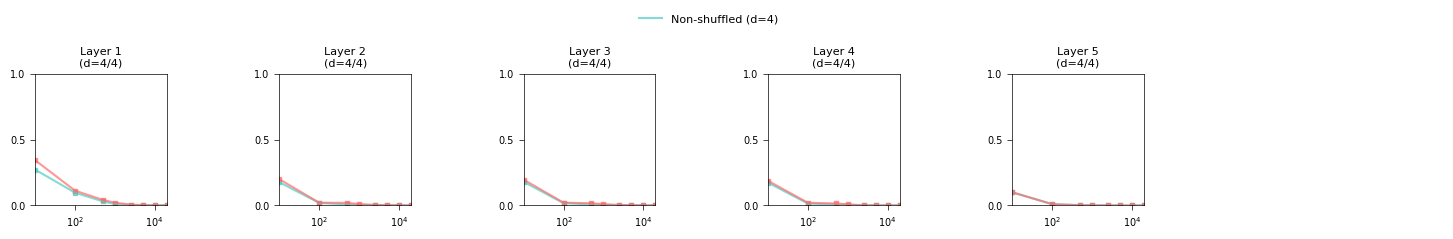

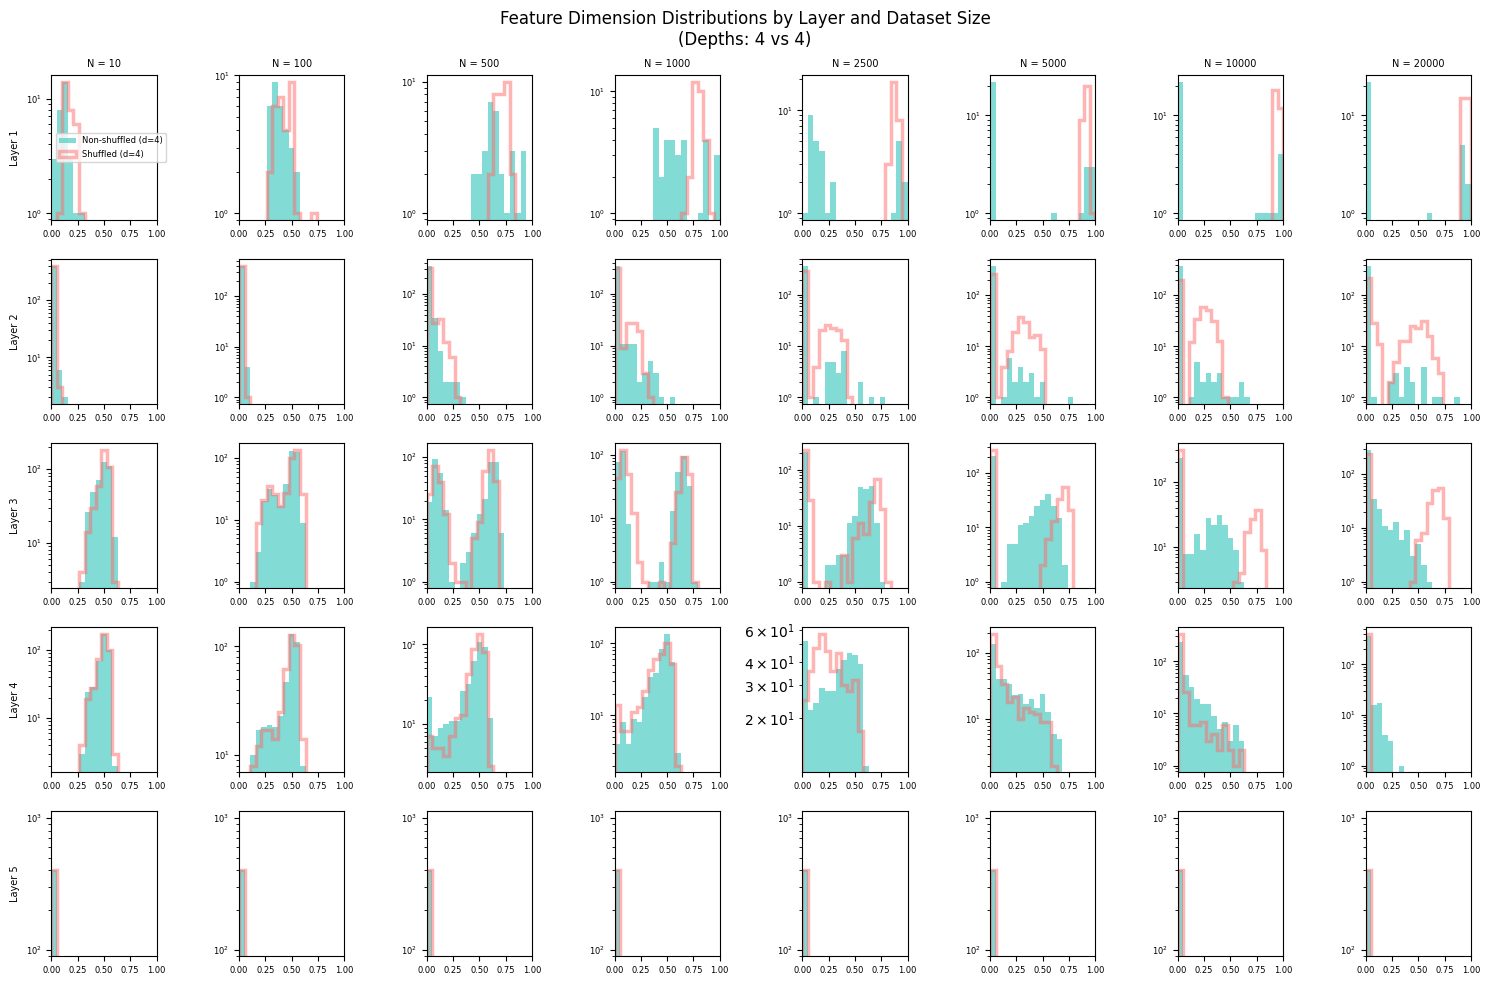

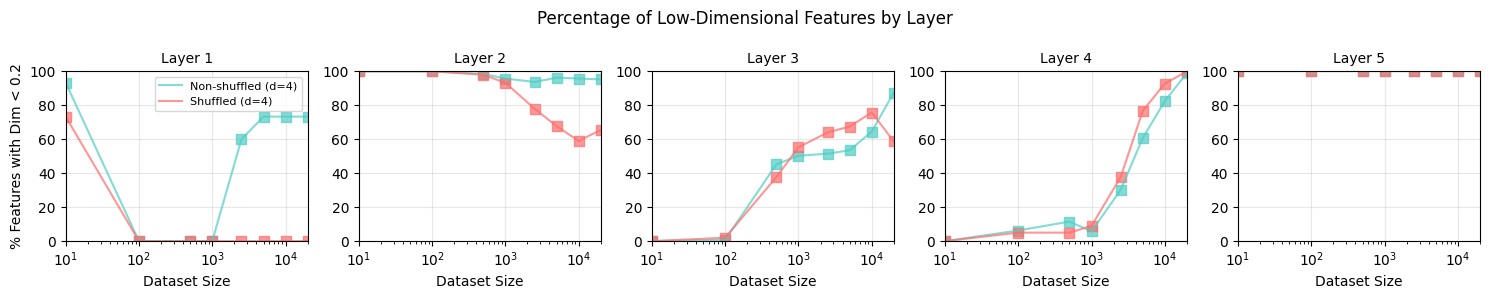

In [4]:
import torch
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard', gamma: float = 1.0):
        super().__init__()
        torch.set_default_dtype(torch.float32)
        self.gamma = gamma
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            layers.extend([linear, torch.nn.ReLU()])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze() / float(self.gamma)

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    gamma = result.get('gamma', 1.0)
    
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_g{gamma}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode, gamma=gamma)
    model.load_state_dict(torch.load(model_path))
    
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    X_train = train_data['X']
    y_train = train_data['y']
    
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float, torch.Tensor]:
    """Compute Anthropic's dimensionality metrics"""
    with torch.no_grad():
        # Sample dimensionality
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std, feature_dims
def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, 
                         timestamp: str, target_lr=None, target_hidden_size=None, target_depth=None):
    """Analyze metrics for specific model configuration"""
    # Filter results by learning rate and model architecture
    filtered_results = results
    if target_lr is not None:
        filtered_results = [r for r in filtered_results if r['learning_rate'] == target_lr]
    if target_hidden_size is not None:
        filtered_results = [r for r in filtered_results if r['hidden_size'] == target_hidden_size]
    if target_depth is not None:
        filtered_results = [r for r in filtered_results if r['depth'] == target_depth]
    
    # Sort by dataset size
    sorted_results = sorted(filtered_results, key=lambda x: x['n_train'])
    
    if not sorted_results:
        raise ValueError(f"No results found for specified configuration: lr={target_lr}, hidden_size={target_hidden_size}, depth={target_depth}")
    
    metrics = {
        'n_train': [],
        'layers': [],
        'raw_feature_dims': []  # Add storage for raw feature dimensions
    }
    
    for result in sorted_results:
        print(f"Processing result: n_train={result['n_train']}, "
              f"hidden_size={result['hidden_size']}, depth={result['depth']}, "
              f"lr={result['learning_rate']}, "
              f"shuffled={result.get('shuffled', False)}")
        
        model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
        layer_metrics = analyze_dimensionality_by_layer(model, X_train)
        
        metrics['n_train'].append(result['n_train'])
        metrics['layers'].append(layer_metrics)
        
        # Store raw feature dimensions for each layer
        raw_dims = []
        for layer_metric in layer_metrics:
            raw_dims.append(layer_metric['anthropic']['feature_dims_raw'])
        metrics['raw_feature_dims'].append(raw_dims)
    
    return metrics

def extract_metrics_array(metrics: Dict) -> Tuple[np.ndarray, List[List[np.ndarray]], List[List[float]]]:
    """Extract metrics into numpy array and list of raw feature dimension arrays with better dimension handling"""
    if not metrics['layers']:
        raise ValueError("No metrics data found")
        
    n_layers = len(metrics['layers'][0])
    n_datapoints = len(metrics['layers'])
    n_dim_types = 4
    
    result = np.zeros((n_dim_types, n_layers, n_datapoints))
    
    # Process regular metrics
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            result[0, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim']
            result[1, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim_std']
            result[2, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim']
            result[3, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim_std']
    
    # Process raw feature dimensions - now properly structured as [dataset][layer]
    raw_feature_dims = []
    for dp_idx in range(n_datapoints):
        layer_dims = []
        for layer_idx in range(n_layers):
            dims = metrics['layers'][dp_idx][layer_idx]['anthropic']['feature_dims_raw']
            layer_dims.append(dims)
        raw_feature_dims.append(layer_dims)
    
    # Calculate percentage of feature dimensions below threshold per layer
    low_dim_percentages = [[] for _ in range(n_layers)]
    for layer_idx in range(n_layers):
        for dp_idx in range(n_datapoints):
            feat_dims = raw_feature_dims[dp_idx][layer_idx]
            low_dims = np.sum(feat_dims < 0.2)
            total_dims = len(feat_dims)
            percentage = (low_dims / total_dims) * 100 if total_dims > 0 else 0
            low_dim_percentages[layer_idx].append(percentage)
    
    return result, raw_feature_dims, low_dim_percentages



def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics for each layer"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue
            
            current_activation = layer(current_activation)
            
            sample_mean, sample_std, feature_mean, feature_std, feature_dims = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': sample_mean,
                    'sample_dim_std': sample_std,
                    'feature_dim': feature_mean,
                    'feature_dim_std': feature_std,
                    'feature_dims_raw': feature_dims.cpu().numpy()
                }
            })
    
    return layer_metrics

def plot_dimensionality_comparison(metrics1, metrics2, raw_dims1, raw_dims2, 
                               low_dim_pct1, low_dim_pct2,
                               label1="Model 1", label2="Model 2",
                               sample_figsize=(15.0, 2.0),
                               hist_figsize=(15, 10),
                               low_dim_figsize=(15, 3),
                               depth1=None, depth2=None):
    """Plot dimensionality analysis comparison between two models with safer array handling"""
    # Get dataset sizes from the metrics
    dataset_sizes = metrics1['n_train']
    n_layers = len(metrics1['layers'][0])
    n_datasets = len(dataset_sizes)
    
    print(f"Debug info:")
    print(f"Number of layers: {n_layers}")
    print(f"Number of datasets: {n_datasets}")
    print(f"Dataset sizes: {dataset_sizes}")
    print(f"Raw dims1 structure: {len(raw_dims1)} x {len(raw_dims1[0]) if raw_dims1 else 0}")
    print(f"Raw dims2 structure: {len(raw_dims2)} x {len(raw_dims2[0]) if raw_dims2 else 0}")
    
    # Sample Dimensionality Plot
    fig1, axs1 = plt.subplots(1, n_layers + 1, figsize=sample_figsize)
    fig1.subplots_adjust(wspace=0.01)
    
    sample_dim1 = metrics1_arr[0]
    sample_dim2 = metrics2_arr[0]
    
    # Set up consistent y-axis limits
    y_min = 0.0
    y_max = 1.0
    
    for layer in range(n_layers):
        ax = axs1[layer]
        
        ax.plot(dataset_sizes, sample_dim1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5)
        ax.plot(dataset_sizes, sample_dim2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5)
        
        ax.scatter(dataset_sizes, sample_dim1[layer], color='#4ECDC4', marker='s', s=10, alpha=0.7)
        ax.scatter(dataset_sizes, sample_dim2[layer], color='#FF6B6B', marker='s', s=10, alpha=0.7)
        
        layer_title = f'Layer {layer+1}'
        if depth1 is not None and depth2 is not None:
            layer_title += f'\n(d={depth1}/{depth2})'
        ax.set_title(layer_title, fontsize=8)
        
        ax.set_ylim(y_min, y_max)
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=7)
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_xticks([1e2, 1e4])
        ax.set_xticklabels(['$10^2$', '$10^4$'], fontsize=7)
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            
        ax.tick_params(width=0.5)
        ax.set_box_aspect(1)
    
    axs1[-1].axis('off')
    
    if depth1 is not None and depth2 is not None:
        label1 = f"{label1} (d={depth1})"
        label2 = f"{label2} (d={depth2})"
    
    lines = axs1[0].get_lines()[::2]
    fig1.legend(lines, [label1, label2],
               loc='upper center',
               bbox_to_anchor=(0.5, 1.2),
               ncol=2,
               fontsize=8,
               frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # Feature Dimensionality Histograms with safer array handling
    fig2, axs2 = plt.subplots(n_layers, n_datasets, figsize=hist_figsize)
    title = 'Feature Dimension Distributions by Layer and Dataset Size'
    if depth1 is not None and depth2 is not None:
        title += f'\n(Depths: {depth1} vs {depth2})'
    fig2.suptitle(title, fontsize=12)
    
    x_min, x_max = 0.0, 1.0
    bins = np.linspace(x_min, x_max, 20)  # Reduced number of bins for thicker bars
    
    # Ensure axs2 is always 2D
    if n_layers == 1:
        axs2 = np.array([axs2])
    if n_datasets == 1:
        axs2 = np.array([axs2]).T
    
    for layer in range(n_layers):
        for idx in range(n_datasets):
            try:
                ax = axs2[layer, idx]
                
                # Safely access raw dimensions
                dims1 = raw_dims1[idx][layer] if idx < len(raw_dims1) and layer < len(raw_dims1[idx]) else []
                dims2 = raw_dims2[idx][layer] if idx < len(raw_dims2) and layer < len(raw_dims2[idx]) else []
                
                if len(dims1) > 0:
                    counts1, bins1, patches1 = ax.hist(dims1, bins=bins, alpha=0.7,  # Increased alpha
                                                     color='#4ECDC4', label=label1, 
                                                     histtype='stepfilled',
                                                     linewidth=2.0)  # Increased line width
                if len(dims2) > 0:
                    counts2, bins2, patches2 = ax.hist(dims2, bins=bins, alpha=0.5,
                                                     color='#FF6B6B', label=label2, 
                                                     histtype='step',
                                                     linewidth=2.5,  # Increased line width
                                                     edgecolor='#FF6B6B')
                
                if (len(dims1) > 0 and np.max(counts1) > 0) or (len(dims2) > 0 and np.max(counts2) > 0):
                    ax.set_yscale('log')
                
                ax.set_xlim(x_min, x_max)
                
                if layer == 0:
                    ax.set_title(f'N = {dataset_sizes[idx]}', fontsize=7)
                if idx == 0:
                    ax.set_ylabel(f'Layer {layer+1}', fontsize=7)
                
                ax.tick_params(labelsize=6)
                if layer == 0 and idx == 0:
                    ax.legend(fontsize=6)
                    
            except Exception as e:
                print(f"Error plotting histogram for layer {layer}, dataset {idx}: {str(e)}")
    
    plt.tight_layout()
    
    # Plot low-dimensional feature percentage per layer with safer array handling
    fig3, axs3 = plt.subplots(1, n_layers, figsize=low_dim_figsize)
    fig3.suptitle('Percentage of Low-Dimensional Features by Layer', fontsize=12)
    
    # Ensure axs3 is an array
    axs3 = np.atleast_1d(axs3)
    
    for layer in range(n_layers):
        ax = axs3[layer] if n_layers > 1 else axs3[0]
        
        try:
            ax.plot(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5, label=label1)
            ax.plot(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5, label=label2)
            
            ax.scatter(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', marker='s', s=50, alpha=0.7)
            ax.scatter(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', marker='s', s=50, alpha=0.7)
        except Exception as e:
            print(f"Error plotting low-dim percentages for layer {layer}: {str(e)}")
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_ylim(0, 100)
        
        ax.set_xlabel('Dataset Size', fontsize=10)
        if layer == 0:
            ax.set_ylabel('% Features with Dim < 0.2', fontsize=10)
        
        ax.set_title(f'Layer {layer+1}', fontsize=10)
        if layer == 0:
            ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



# Add this debug function
def print_metrics_info(metrics, raw_dims, label):
    print(f"\nDebug info for {label}:")
    print(f"Number of training sizes: {len(metrics['n_train'])}")
    print(f"Training sizes: {metrics['n_train']}")
    print(f"Number of layers: {len(metrics['layers'][0])}")
    print(f"Raw dimensions structure:")
    print(f"- Number of datasets: {len(raw_dims)}")
    if raw_dims:
        print(f"- Dimensions per layer: {[len(layer_dims) for layer_dims in raw_dims[0]]}")
    
# Before plotting, add debug info
#print_metrics_info(metrics1, raw_dims1, "Model 1 (Non-shuffled)")
#print_metrics_info(metrics2, raw_dims2, "Model 2 (Shuffled)")

# Example usage
results_dir1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved"
results_dir2 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_1_modelsaved"
timestamp1 = "20250125_153135"  # First model timestamp
timestamp2 = "20250125_153042"  # Second model timestamp
hidden_size = 400  # The hidden size to analyze
depth = 4 # The depth to analyze
target_lr = 0.005  # The learning rate used in training
gamma = 1  # The gamma value used in training
dataset_sizes = [10, 100, 500, 1000, 5000, 10000, 20000]  # The actual dataset sizes used
# Example usage with added debugging
print("Loading and analyzing first model (non-shuffled)...")
results1, hyperparams1 = load_experiment_data(results_dir1, timestamp1)
metrics1 = analyze_by_dataset_size(
    results1, 
    hyperparams1, 
    results_dir1, 
    results_dir1, 
    timestamp1, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

print("\nLoading and analyzing second model (shuffled)...")
results2, hyperparams2 = load_experiment_data(results_dir2, timestamp2)
metrics2 = analyze_by_dataset_size(
    results2, 
    hyperparams2, 
    results_dir2, 
    results_dir2, 
    timestamp2, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

# Extract arrays with debugging information
print("\nExtracting metrics arrays...")
metrics1_arr, raw_dims1, low_dim_pct1 = extract_metrics_array(metrics1)
metrics2_arr, raw_dims2, low_dim_pct2 = extract_metrics_array(metrics2)

# Additional debugging prints
print(f"\nMetrics shapes:")
print(f"metrics1_arr shape: {metrics1_arr.shape}")
print(f"metrics2_arr shape: {metrics2_arr.shape}")
print(f"Number of dataset sizes: {len(metrics1['n_train'])}")
print(f"Dataset sizes in first model: {metrics1['n_train']}")
print(f"Dataset sizes in second model: {metrics2['n_train']}")

# Plot with additional debugging information
print("\nPlotting comparison...")
plot_dimensionality_comparison(
    metrics1, 
    metrics2, 
    raw_dims1, 
    raw_dims2, 
    low_dim_pct1,
    low_dim_pct2,
    label1="Non-shuffled",
    label2="Shuffled",
    depth1=depth,
    depth2=depth
)

Loading and analyzing first model (non-shuffled)...
Processing result: n_train=10, hidden_size=2000, depth=4, lr=0.005, shuffled=False


/tmp/ipykernel_1813533/1649937099.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_1813533/1649937099.py:77:

Processing result: n_train=100, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=500, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=1000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=2500, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=5000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=10000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=20000, hidden_size=2000, depth=4, lr=0.005, shuffled=False

Loading and analyzing second model (shuffled)...
Processing result: n_train=10, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_train=100, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_train=500, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_train=1000, hidden_size=2000, depth=4, lr=0.005, shuffled=True
Processing result: n_tr

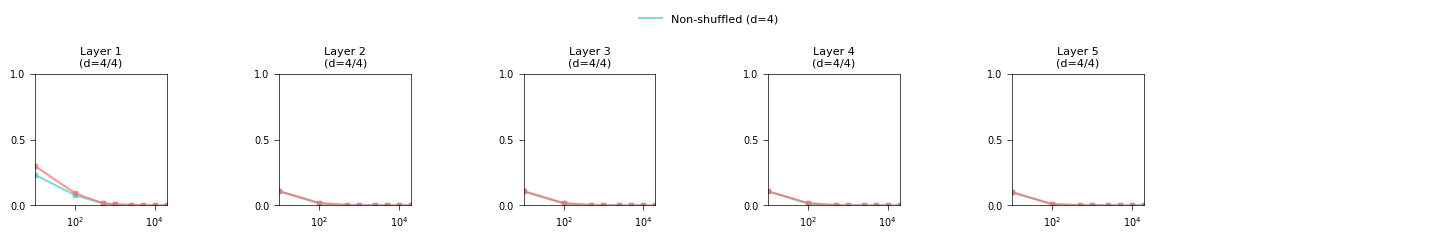

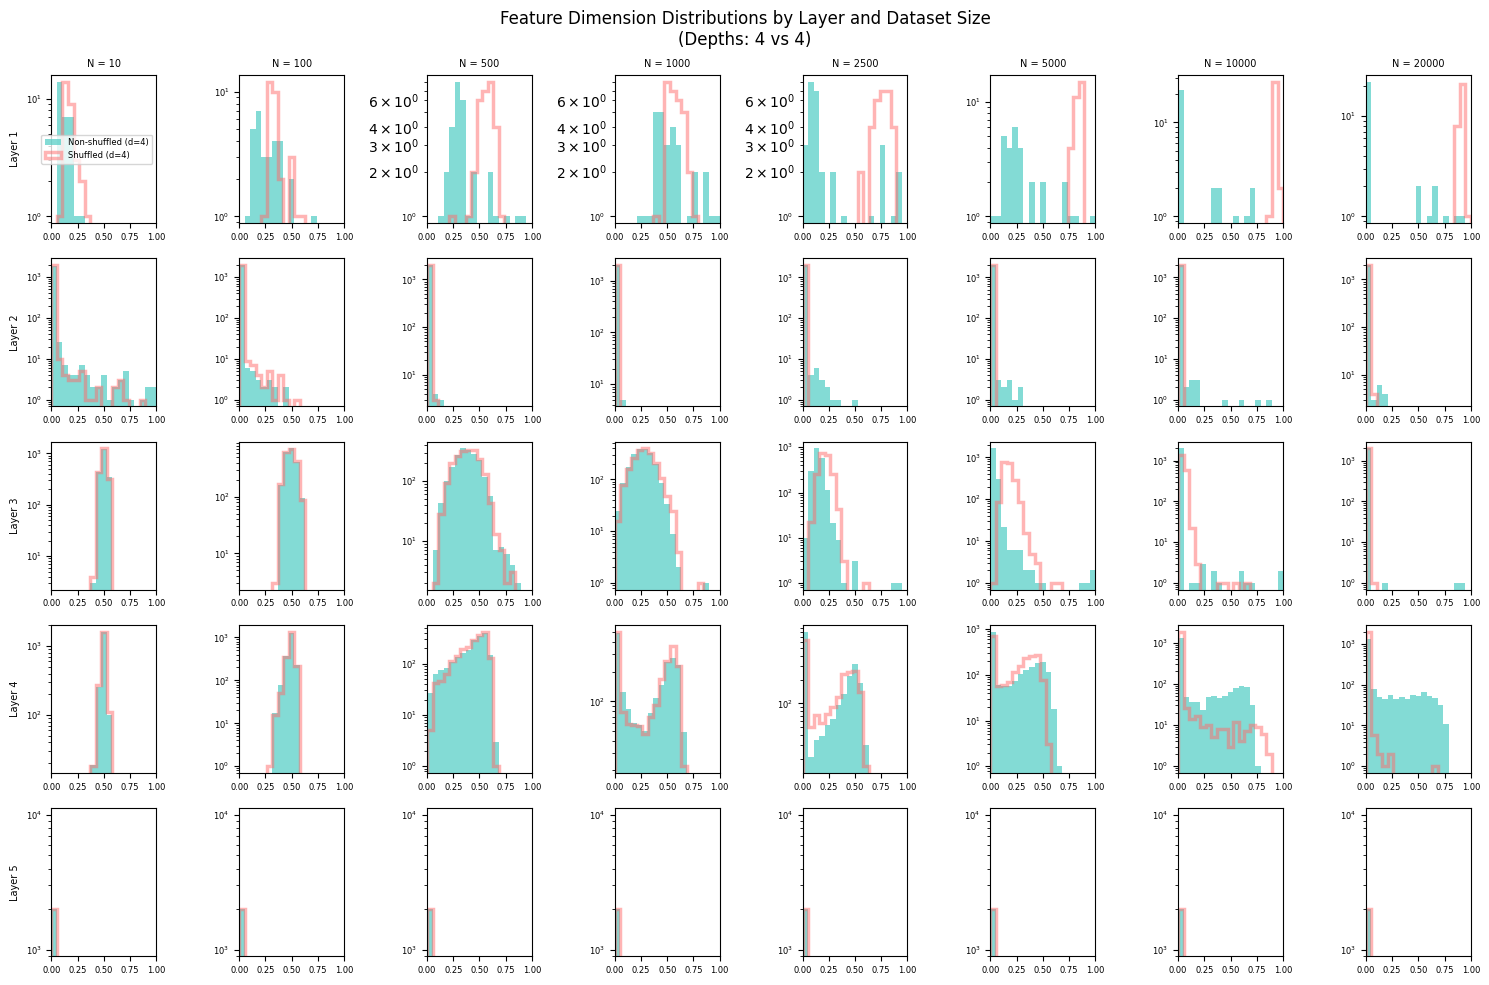

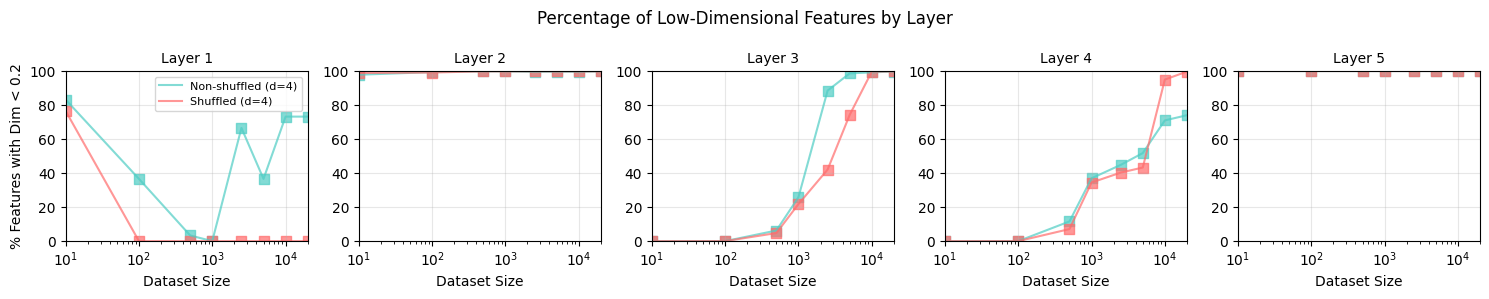

In [3]:
import torch
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard', gamma: float = 1.0):
        super().__init__()
        torch.set_default_dtype(torch.float32)
        self.gamma = gamma
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            layers.extend([linear, torch.nn.ReLU()])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze() / float(self.gamma)

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    gamma = result.get('gamma', 1.0)
    
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_g{gamma}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode, gamma=gamma)
    model.load_state_dict(torch.load(model_path))
    
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    X_train = train_data['X']
    y_train = train_data['y']
    
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float, torch.Tensor]:
    """Compute Anthropic's dimensionality metrics"""
    with torch.no_grad():
        # Sample dimensionality
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std, feature_dims
def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, 
                         timestamp: str, target_lr=None, target_hidden_size=None, target_depth=None):
    """Analyze metrics for specific model configuration"""
    # Filter results by learning rate and model architecture
    filtered_results = results
    if target_lr is not None:
        filtered_results = [r for r in filtered_results if r['learning_rate'] == target_lr]
    if target_hidden_size is not None:
        filtered_results = [r for r in filtered_results if r['hidden_size'] == target_hidden_size]
    if target_depth is not None:
        filtered_results = [r for r in filtered_results if r['depth'] == target_depth]
    
    # Sort by dataset size
    sorted_results = sorted(filtered_results, key=lambda x: x['n_train'])
    
    if not sorted_results:
        raise ValueError(f"No results found for specified configuration: lr={target_lr}, hidden_size={target_hidden_size}, depth={target_depth}")
    
    metrics = {
        'n_train': [],
        'layers': [],
        'raw_feature_dims': []  # Add storage for raw feature dimensions
    }
    
    for result in sorted_results:
        print(f"Processing result: n_train={result['n_train']}, "
              f"hidden_size={result['hidden_size']}, depth={result['depth']}, "
              f"lr={result['learning_rate']}, "
              f"shuffled={result.get('shuffled', False)}")
        
        model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
        layer_metrics = analyze_dimensionality_by_layer(model, X_train)
        
        metrics['n_train'].append(result['n_train'])
        metrics['layers'].append(layer_metrics)
        
        # Store raw feature dimensions for each layer
        raw_dims = []
        for layer_metric in layer_metrics:
            raw_dims.append(layer_metric['anthropic']['feature_dims_raw'])
        metrics['raw_feature_dims'].append(raw_dims)
    
    return metrics

def extract_metrics_array(metrics: Dict) -> Tuple[np.ndarray, List[List[np.ndarray]], List[List[float]]]:
    """Extract metrics into numpy array and list of raw feature dimension arrays with better dimension handling"""
    if not metrics['layers']:
        raise ValueError("No metrics data found")
        
    n_layers = len(metrics['layers'][0])
    n_datapoints = len(metrics['layers'])
    n_dim_types = 4
    
    result = np.zeros((n_dim_types, n_layers, n_datapoints))
    
    # Process regular metrics
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            result[0, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim']
            result[1, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim_std']
            result[2, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim']
            result[3, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim_std']
    
    # Process raw feature dimensions - now properly structured as [dataset][layer]
    raw_feature_dims = []
    for dp_idx in range(n_datapoints):
        layer_dims = []
        for layer_idx in range(n_layers):
            dims = metrics['layers'][dp_idx][layer_idx]['anthropic']['feature_dims_raw']
            layer_dims.append(dims)
        raw_feature_dims.append(layer_dims)
    
    # Calculate percentage of feature dimensions below threshold per layer
    low_dim_percentages = [[] for _ in range(n_layers)]
    for layer_idx in range(n_layers):
        for dp_idx in range(n_datapoints):
            feat_dims = raw_feature_dims[dp_idx][layer_idx]
            low_dims = np.sum(feat_dims < 0.2)
            total_dims = len(feat_dims)
            percentage = (low_dims / total_dims) * 100 if total_dims > 0 else 0
            low_dim_percentages[layer_idx].append(percentage)
    
    return result, raw_feature_dims, low_dim_percentages



def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics for each layer"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue
            
            current_activation = layer(current_activation)
            
            sample_mean, sample_std, feature_mean, feature_std, feature_dims = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': sample_mean,
                    'sample_dim_std': sample_std,
                    'feature_dim': feature_mean,
                    'feature_dim_std': feature_std,
                    'feature_dims_raw': feature_dims.cpu().numpy()
                }
            })
    
    return layer_metrics

def plot_dimensionality_comparison(metrics1, metrics2, raw_dims1, raw_dims2, 
                               low_dim_pct1, low_dim_pct2,
                               label1="Model 1", label2="Model 2",
                               sample_figsize=(15.0, 2.0),
                               hist_figsize=(15, 10),
                               low_dim_figsize=(15, 3),
                               depth1=None, depth2=None):
    """Plot dimensionality analysis comparison between two models with safer array handling"""
    # Get dataset sizes from the metrics
    dataset_sizes = metrics1['n_train']
    n_layers = len(metrics1['layers'][0])
    n_datasets = len(dataset_sizes)
    
    print(f"Debug info:")
    print(f"Number of layers: {n_layers}")
    print(f"Number of datasets: {n_datasets}")
    print(f"Dataset sizes: {dataset_sizes}")
    print(f"Raw dims1 structure: {len(raw_dims1)} x {len(raw_dims1[0]) if raw_dims1 else 0}")
    print(f"Raw dims2 structure: {len(raw_dims2)} x {len(raw_dims2[0]) if raw_dims2 else 0}")
    
    # Sample Dimensionality Plot
    fig1, axs1 = plt.subplots(1, n_layers + 1, figsize=sample_figsize)
    fig1.subplots_adjust(wspace=0.01)
    
    sample_dim1 = metrics1_arr[0]
    sample_dim2 = metrics2_arr[0]
    
    # Set up consistent y-axis limits
    y_min = 0.0
    y_max = 1.0
    
    for layer in range(n_layers):
        ax = axs1[layer]
        
        ax.plot(dataset_sizes, sample_dim1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5)
        ax.plot(dataset_sizes, sample_dim2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5)
        
        ax.scatter(dataset_sizes, sample_dim1[layer], color='#4ECDC4', marker='s', s=10, alpha=0.7)
        ax.scatter(dataset_sizes, sample_dim2[layer], color='#FF6B6B', marker='s', s=10, alpha=0.7)
        
        layer_title = f'Layer {layer+1}'
        if depth1 is not None and depth2 is not None:
            layer_title += f'\n(d={depth1}/{depth2})'
        ax.set_title(layer_title, fontsize=8)
        
        ax.set_ylim(y_min, y_max)
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=7)
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_xticks([1e2, 1e4])
        ax.set_xticklabels(['$10^2$', '$10^4$'], fontsize=7)
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            
        ax.tick_params(width=0.5)
        ax.set_box_aspect(1)
    
    axs1[-1].axis('off')
    
    if depth1 is not None and depth2 is not None:
        label1 = f"{label1} (d={depth1})"
        label2 = f"{label2} (d={depth2})"
    
    lines = axs1[0].get_lines()[::2]
    fig1.legend(lines, [label1, label2],
               loc='upper center',
               bbox_to_anchor=(0.5, 1.2),
               ncol=2,
               fontsize=8,
               frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # Feature Dimensionality Histograms with safer array handling
    fig2, axs2 = plt.subplots(n_layers, n_datasets, figsize=hist_figsize)
    title = 'Feature Dimension Distributions by Layer and Dataset Size'
    if depth1 is not None and depth2 is not None:
        title += f'\n(Depths: {depth1} vs {depth2})'
    fig2.suptitle(title, fontsize=12)
    
    x_min, x_max = 0.0, 1.0
    bins = np.linspace(x_min, x_max, 20)  # Reduced number of bins for thicker bars
    
    # Ensure axs2 is always 2D
    if n_layers == 1:
        axs2 = np.array([axs2])
    if n_datasets == 1:
        axs2 = np.array([axs2]).T
    
    for layer in range(n_layers):
        for idx in range(n_datasets):
            try:
                ax = axs2[layer, idx]
                
                # Safely access raw dimensions
                dims1 = raw_dims1[idx][layer] if idx < len(raw_dims1) and layer < len(raw_dims1[idx]) else []
                dims2 = raw_dims2[idx][layer] if idx < len(raw_dims2) and layer < len(raw_dims2[idx]) else []
                
                if len(dims1) > 0:
                    counts1, bins1, patches1 = ax.hist(dims1, bins=bins, alpha=0.7,  # Increased alpha
                                                     color='#4ECDC4', label=label1, 
                                                     histtype='stepfilled',
                                                     linewidth=2.0)  # Increased line width
                if len(dims2) > 0:
                    counts2, bins2, patches2 = ax.hist(dims2, bins=bins, alpha=0.5,
                                                     color='#FF6B6B', label=label2, 
                                                     histtype='step',
                                                     linewidth=2.5,  # Increased line width
                                                     edgecolor='#FF6B6B')
                
                if (len(dims1) > 0 and np.max(counts1) > 0) or (len(dims2) > 0 and np.max(counts2) > 0):
                    ax.set_yscale('log')
                
                ax.set_xlim(x_min, x_max)
                
                if layer == 0:
                    ax.set_title(f'N = {dataset_sizes[idx]}', fontsize=7)
                if idx == 0:
                    ax.set_ylabel(f'Layer {layer+1}', fontsize=7)
                
                ax.tick_params(labelsize=6)
                if layer == 0 and idx == 0:
                    ax.legend(fontsize=6)
                    
            except Exception as e:
                print(f"Error plotting histogram for layer {layer}, dataset {idx}: {str(e)}")
    
    plt.tight_layout()
    
    # Plot low-dimensional feature percentage per layer with safer array handling
    fig3, axs3 = plt.subplots(1, n_layers, figsize=low_dim_figsize)
    fig3.suptitle('Percentage of Low-Dimensional Features by Layer', fontsize=12)
    
    # Ensure axs3 is an array
    axs3 = np.atleast_1d(axs3)
    
    for layer in range(n_layers):
        ax = axs3[layer] if n_layers > 1 else axs3[0]
        
        try:
            ax.plot(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5, label=label1)
            ax.plot(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5, label=label2)
            
            ax.scatter(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', marker='s', s=50, alpha=0.7)
            ax.scatter(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', marker='s', s=50, alpha=0.7)
        except Exception as e:
            print(f"Error plotting low-dim percentages for layer {layer}: {str(e)}")
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_ylim(0, 100)
        
        ax.set_xlabel('Dataset Size', fontsize=10)
        if layer == 0:
            ax.set_ylabel('% Features with Dim < 0.2', fontsize=10)
        
        ax.set_title(f'Layer {layer+1}', fontsize=10)
        if layer == 0:
            ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



# Add this debug function
def print_metrics_info(metrics, raw_dims, label):
    print(f"\nDebug info for {label}:")
    print(f"Number of training sizes: {len(metrics['n_train'])}")
    print(f"Training sizes: {metrics['n_train']}")
    print(f"Number of layers: {len(metrics['layers'][0])}")
    print(f"Raw dimensions structure:")
    print(f"- Number of datasets: {len(raw_dims)}")
    if raw_dims:
        print(f"- Dimensions per layer: {[len(layer_dims) for layer_dims in raw_dims[0]]}")
    
# Before plotting, add debug info
#print_metrics_info(metrics1, raw_dims1, "Model 1 (Non-shuffled)")
#print_metrics_info(metrics2, raw_dims2, "Model 2 (Shuffled)")

# Example usage
results_dir1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_0001_modelsaved"
results_dir2 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_0001_modelsaved"
timestamp1 = "20250126_043809"  # First model timestamp
timestamp2 = "20250126_043702"  # Second model timestamp
hidden_size = 2000  # The hidden size to analyze
depth = 4 # The depth to analyze
target_lr = 0.005  # The learning rate used in training
gamma = 0.001  # The gamma value used in training
dataset_sizes = [10, 100, 500, 1000, 5000, 10000, 20000]  # The actual dataset sizes used
# Example usage with added debugging
print("Loading and analyzing first model (non-shuffled)...")
results1, hyperparams1 = load_experiment_data(results_dir1, timestamp1)
metrics1 = analyze_by_dataset_size(
    results1, 
    hyperparams1, 
    results_dir1, 
    results_dir1, 
    timestamp1, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

print("\nLoading and analyzing second model (shuffled)...")
results2, hyperparams2 = load_experiment_data(results_dir2, timestamp2)
metrics2 = analyze_by_dataset_size(
    results2, 
    hyperparams2, 
    results_dir2, 
    results_dir2, 
    timestamp2, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

# Extract arrays with debugging information
print("\nExtracting metrics arrays...")
metrics1_arr, raw_dims1, low_dim_pct1 = extract_metrics_array(metrics1)
metrics2_arr, raw_dims2, low_dim_pct2 = extract_metrics_array(metrics2)

# Additional debugging prints
print(f"\nMetrics shapes:")
print(f"metrics1_arr shape: {metrics1_arr.shape}")
print(f"metrics2_arr shape: {metrics2_arr.shape}")
print(f"Number of dataset sizes: {len(metrics1['n_train'])}")
print(f"Dataset sizes in first model: {metrics1['n_train']}")
print(f"Dataset sizes in second model: {metrics2['n_train']}")

# Plot with additional debugging information
print("\nPlotting comparison...")
plot_dimensionality_comparison(
    metrics1, 
    metrics2, 
    raw_dims1, 
    raw_dims2, 
    low_dim_pct1,
    low_dim_pct2,
    label1="Non-shuffled",
    label2="Shuffled",
    depth1=depth,
    depth2=depth
)

In [1]:
import torch
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard', gamma: float = 1.0):
        super().__init__()
        torch.set_default_dtype(torch.float32)
        self.gamma = gamma
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = torch.nn.Linear(prev_dim, hidden_size)
            if mode == 'standard':
                torch.nn.init.xavier_uniform_(linear.weight)
                torch.nn.init.zeros_(linear.bias)
            layers.extend([linear, torch.nn.ReLU()])
            prev_dim = hidden_size
        
        final_layer = torch.nn.Linear(prev_dim, 1)
        if mode == 'standard':
            torch.nn.init.xavier_uniform_(final_layer.weight)
        torch.nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze() / float(self.gamma)

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters from the given directory"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def load_model_and_data(data_dir: str, results_dir: str, result: Dict, timestamp: str) -> Tuple[torch.nn.Module, torch.Tensor, torch.Tensor]:
    """Load the model and its corresponding training data"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    input_dim = hyperparams['d']
    
    hidden_size = result['hidden_size']
    depth = result['depth']
    n_train = result['n_train']
    lr = result['learning_rate']
    mode = result.get('mode', 'standard')
    shuffled = result.get('shuffled', False)
    rank = result.get('worker_rank', 0)
    gamma = result.get('gamma', 1.0)
    
    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_g{gamma}_{mode}'
    if shuffled:
        model_prefix += '_shuffled'
    
    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank{rank}.pt')
    model = DeepNN(input_dim, hidden_size, depth, mode=mode, gamma=gamma)
    model.load_state_dict(torch.load(model_path))
    
    train_dataset_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank{rank}.pt')
    train_data = torch.load(train_dataset_path)
    
    X_train = train_data['X']
    y_train = train_data['y']
    
    device = next(model.parameters()).device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    return model, X_train, y_train

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float, torch.Tensor]:
    """Compute Anthropic's dimensionality metrics"""
    with torch.no_grad():
        # Sample dimensionality
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std, feature_dims
def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, data_dir: str, results_dir: str, 
                         timestamp: str, target_lr=None, target_hidden_size=None, target_depth=None):
    """Analyze metrics for specific model configuration"""
    # Filter results by learning rate and model architecture
    filtered_results = results
    if target_lr is not None:
        filtered_results = [r for r in filtered_results if r['learning_rate'] == target_lr]
    if target_hidden_size is not None:
        filtered_results = [r for r in filtered_results if r['hidden_size'] == target_hidden_size]
    if target_depth is not None:
        filtered_results = [r for r in filtered_results if r['depth'] == target_depth]
    
    # Sort by dataset size
    sorted_results = sorted(filtered_results, key=lambda x: x['n_train'])
    
    if not sorted_results:
        raise ValueError(f"No results found for specified configuration: lr={target_lr}, hidden_size={target_hidden_size}, depth={target_depth}")
    
    metrics = {
        'n_train': [],
        'layers': [],
        'raw_feature_dims': []  # Add storage for raw feature dimensions
    }
    
    for result in sorted_results:
        print(f"Processing result: n_train={result['n_train']}, "
              f"hidden_size={result['hidden_size']}, depth={result['depth']}, "
              f"lr={result['learning_rate']}, "
              f"shuffled={result.get('shuffled', False)}")
        
        model, X_train, y_train = load_model_and_data(data_dir, results_dir, result, timestamp)
        layer_metrics = analyze_dimensionality_by_layer(model, X_train)
        
        metrics['n_train'].append(result['n_train'])
        metrics['layers'].append(layer_metrics)
        
        # Store raw feature dimensions for each layer
        raw_dims = []
        for layer_metric in layer_metrics:
            raw_dims.append(layer_metric['anthropic']['feature_dims_raw'])
        metrics['raw_feature_dims'].append(raw_dims)
    
    return metrics

def extract_metrics_array(metrics: Dict) -> Tuple[np.ndarray, List[List[np.ndarray]], List[List[float]]]:
    """Extract metrics into numpy array and list of raw feature dimension arrays with better dimension handling"""
    if not metrics['layers']:
        raise ValueError("No metrics data found")
        
    n_layers = len(metrics['layers'][0])
    n_datapoints = len(metrics['layers'])
    n_dim_types = 4
    
    result = np.zeros((n_dim_types, n_layers, n_datapoints))
    
    # Process regular metrics
    for dp_idx, layer_metrics in enumerate(metrics['layers']):
        for layer_idx in range(n_layers):
            result[0, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim']
            result[1, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['sample_dim_std']
            result[2, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim']
            result[3, layer_idx, dp_idx] = layer_metrics[layer_idx]['anthropic']['feature_dim_std']
    
    # Process raw feature dimensions - now properly structured as [dataset][layer]
    raw_feature_dims = []
    for dp_idx in range(n_datapoints):
        layer_dims = []
        for layer_idx in range(n_layers):
            dims = metrics['layers'][dp_idx][layer_idx]['anthropic']['feature_dims_raw']
            layer_dims.append(dims)
        raw_feature_dims.append(layer_dims)
    
    # Calculate percentage of feature dimensions below threshold per layer
    low_dim_percentages = [[] for _ in range(n_layers)]
    for layer_idx in range(n_layers):
        for dp_idx in range(n_datapoints):
            feat_dims = raw_feature_dims[dp_idx][layer_idx]
            low_dims = np.sum(feat_dims < 0.2)
            total_dims = len(feat_dims)
            percentage = (low_dims / total_dims) * 100 if total_dims > 0 else 0
            low_dim_percentages[layer_idx].append(percentage)
    
    return result, raw_feature_dims, low_dim_percentages



def analyze_dimensionality_by_layer(model: torch.nn.Module, X: torch.Tensor) -> Dict:
    """Compute dimensionality metrics for each layer"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if hasattr(layer, 'weight'):
                features = layer.weight.data
            else:
                continue
            
            current_activation = layer(current_activation)
            
            sample_mean, sample_std, feature_mean, feature_std, feature_dims = compute_anthropic_dimensionality(
                current_activation, features)
            
            layer_metrics.append({
                'layer': i,
                'anthropic': {
                    'sample_dim': sample_mean,
                    'sample_dim_std': sample_std,
                    'feature_dim': feature_mean,
                    'feature_dim_std': feature_std,
                    'feature_dims_raw': feature_dims.cpu().numpy()
                }
            })
    
    return layer_metrics

def plot_dimensionality_comparison(metrics1, metrics2, raw_dims1, raw_dims2, 
                               low_dim_pct1, low_dim_pct2,
                               label1="Model 1", label2="Model 2",
                               sample_figsize=(15.0, 2.0),
                               hist_figsize=(15, 10),
                               low_dim_figsize=(15, 3),
                               depth1=None, depth2=None):
    """Plot dimensionality analysis comparison between two models with safer array handling"""
    # Get dataset sizes from the metrics
    dataset_sizes = metrics1['n_train']
    n_layers = len(metrics1['layers'][0])
    n_datasets = len(dataset_sizes)
    
    print(f"Debug info:")
    print(f"Number of layers: {n_layers}")
    print(f"Number of datasets: {n_datasets}")
    print(f"Dataset sizes: {dataset_sizes}")
    print(f"Raw dims1 structure: {len(raw_dims1)} x {len(raw_dims1[0]) if raw_dims1 else 0}")
    print(f"Raw dims2 structure: {len(raw_dims2)} x {len(raw_dims2[0]) if raw_dims2 else 0}")
    
    # Sample Dimensionality Plot
    fig1, axs1 = plt.subplots(1, n_layers + 1, figsize=sample_figsize)
    fig1.subplots_adjust(wspace=0.01)
    
    sample_dim1 = metrics1_arr[0]
    sample_dim2 = metrics2_arr[0]
    
    # Set up consistent y-axis limits
    y_min = 0.0
    y_max = 1.0
    
    for layer in range(n_layers):
        ax = axs1[layer]
        
        ax.plot(dataset_sizes, sample_dim1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5)
        ax.plot(dataset_sizes, sample_dim2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5)
        
        ax.scatter(dataset_sizes, sample_dim1[layer], color='#4ECDC4', marker='s', s=10, alpha=0.7)
        ax.scatter(dataset_sizes, sample_dim2[layer], color='#FF6B6B', marker='s', s=10, alpha=0.7)
        
        layer_title = f'Layer {layer+1}'
        if depth1 is not None and depth2 is not None:
            layer_title += f'\n(d={depth1}/{depth2})'
        ax.set_title(layer_title, fontsize=8)
        
        ax.set_ylim(y_min, y_max)
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=7)
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_xticks([1e2, 1e4])
        ax.set_xticklabels(['$10^2$', '$10^4$'], fontsize=7)
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            
        ax.tick_params(width=0.5)
        ax.set_box_aspect(1)
    
    axs1[-1].axis('off')
    
    if depth1 is not None and depth2 is not None:
        label1 = f"{label1} (d={depth1})"
        label2 = f"{label2} (d={depth2})"
    
    lines = axs1[0].get_lines()[::2]
    fig1.legend(lines, [label1, label2],
               loc='upper center',
               bbox_to_anchor=(0.5, 1.2),
               ncol=2,
               fontsize=8,
               frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # Feature Dimensionality Histograms with safer array handling
    fig2, axs2 = plt.subplots(n_layers, n_datasets, figsize=hist_figsize)
    title = 'Feature Dimension Distributions by Layer and Dataset Size'
    if depth1 is not None and depth2 is not None:
        title += f'\n(Depths: {depth1} vs {depth2})'
    fig2.suptitle(title, fontsize=12)
    
    x_min, x_max = 0.0, 1.0
    bins = np.linspace(x_min, x_max, 20)  # Reduced number of bins for thicker bars
    
    # Ensure axs2 is always 2D
    if n_layers == 1:
        axs2 = np.array([axs2])
    if n_datasets == 1:
        axs2 = np.array([axs2]).T
    
    for layer in range(n_layers):
        for idx in range(n_datasets):
            try:
                ax = axs2[layer, idx]
                
                # Safely access raw dimensions
                dims1 = raw_dims1[idx][layer] if idx < len(raw_dims1) and layer < len(raw_dims1[idx]) else []
                dims2 = raw_dims2[idx][layer] if idx < len(raw_dims2) and layer < len(raw_dims2[idx]) else []
                
                if len(dims1) > 0:
                    counts1, bins1, patches1 = ax.hist(dims1, bins=bins, alpha=0.7,  # Increased alpha
                                                     color='#4ECDC4', label=label1, 
                                                     histtype='stepfilled',
                                                     linewidth=2.0)  # Increased line width
                if len(dims2) > 0:
                    counts2, bins2, patches2 = ax.hist(dims2, bins=bins, alpha=0.5,
                                                     color='#FF6B6B', label=label2, 
                                                     histtype='step',
                                                     linewidth=2.5,  # Increased line width
                                                     edgecolor='#FF6B6B')
                
                if (len(dims1) > 0 and np.max(counts1) > 0) or (len(dims2) > 0 and np.max(counts2) > 0):
                    ax.set_yscale('log')
                
                ax.set_xlim(x_min, x_max)
                
                if layer == 0:
                    ax.set_title(f'N = {dataset_sizes[idx]}', fontsize=7)
                if idx == 0:
                    ax.set_ylabel(f'Layer {layer+1}', fontsize=7)
                
                ax.tick_params(labelsize=6)
                if layer == 0 and idx == 0:
                    ax.legend(fontsize=6)
                    
            except Exception as e:
                print(f"Error plotting histogram for layer {layer}, dataset {idx}: {str(e)}")
    
    plt.tight_layout()
    
    # Plot low-dimensional feature percentage per layer with safer array handling
    fig3, axs3 = plt.subplots(1, n_layers, figsize=low_dim_figsize)
    fig3.suptitle('Percentage of Low-Dimensional Features by Layer', fontsize=12)
    
    # Ensure axs3 is an array
    axs3 = np.atleast_1d(axs3)
    
    for layer in range(n_layers):
        ax = axs3[layer] if n_layers > 1 else axs3[0]
        
        try:
            ax.plot(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', alpha=0.7, linewidth=1.5, label=label1)
            ax.plot(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', alpha=0.7, linewidth=1.5, label=label2)
            
            ax.scatter(dataset_sizes, low_dim_pct1[layer], color='#4ECDC4', marker='s', s=50, alpha=0.7)
            ax.scatter(dataset_sizes, low_dim_pct2[layer], color='#FF6B6B', marker='s', s=50, alpha=0.7)
        except Exception as e:
            print(f"Error plotting low-dim percentages for layer {layer}: {str(e)}")
        
        ax.set_xscale('log')
        ax.set_xlim(10, 2e4)
        ax.set_ylim(0, 100)
        
        ax.set_xlabel('Dataset Size', fontsize=10)
        if layer == 0:
            ax.set_ylabel('% Features with Dim < 0.2', fontsize=10)
        
        ax.set_title(f'Layer {layer+1}', fontsize=10)
        if layer == 0:
            ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



# Add this debug function
def print_metrics_info(metrics, raw_dims, label):
    print(f"\nDebug info for {label}:")
    print(f"Number of training sizes: {len(metrics['n_train'])}")
    print(f"Training sizes: {metrics['n_train']}")
    print(f"Number of layers: {len(metrics['layers'][0])}")
    print(f"Raw dimensions structure:")
    print(f"- Number of datasets: {len(raw_dims)}")
    if raw_dims:
        print(f"- Dimensions per layer: {[len(layer_dims) for layer_dims in raw_dims[0]]}")
    
# Before plotting, add debug info
#print_metrics_info(metrics1, raw_dims1, "Model 1 (Non-shuffled)")
#print_metrics_info(metrics2, raw_dims2, "Model 2 (Shuffled)")

# Example usage
results_dir1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_000001_modelsaved"
results_dir2 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_000001_modelsaved"
timestamp1 = "20250127_052129"  # First model timestamp
timestamp2 = "20250127_051749"  # Second model timestamp
hidden_size = 2000  # The hidden size to analyze
depth = 4 # The depth to analyze
target_lr = 0.005  # The learning rate used in training
gamma = 0.00001  # The gamma value used in training
dataset_sizes = [10, 100, 500, 1000, 5000, 10000, 20000]  # The actual dataset sizes used
# Example usage with added debugging
print("Loading and analyzing first model (non-shuffled)...")
results1, hyperparams1 = load_experiment_data(results_dir1, timestamp1)
metrics1 = analyze_by_dataset_size(
    results1, 
    hyperparams1, 
    results_dir1, 
    results_dir1, 
    timestamp1, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

print("\nLoading and analyzing second model (shuffled)...")
results2, hyperparams2 = load_experiment_data(results_dir2, timestamp2)
metrics2 = analyze_by_dataset_size(
    results2, 
    hyperparams2, 
    results_dir2, 
    results_dir2, 
    timestamp2, 
    target_lr=target_lr,
    target_hidden_size=hidden_size,
    target_depth=depth
)

# Extract arrays with debugging information
print("\nExtracting metrics arrays...")
metrics1_arr, raw_dims1, low_dim_pct1 = extract_metrics_array(metrics1)
metrics2_arr, raw_dims2, low_dim_pct2 = extract_metrics_array(metrics2)

# Additional debugging prints
print(f"\nMetrics shapes:")
print(f"metrics1_arr shape: {metrics1_arr.shape}")
print(f"metrics2_arr shape: {metrics2_arr.shape}")
print(f"Number of dataset sizes: {len(metrics1['n_train'])}")
print(f"Dataset sizes in first model: {metrics1['n_train']}")
print(f"Dataset sizes in second model: {metrics2['n_train']}")

# Plot with additional debugging information
print("\nPlotting comparison...")
plot_dimensionality_comparison(
    metrics1, 
    metrics2, 
    raw_dims1, 
    raw_dims2, 
    low_dim_pct1,
    low_dim_pct2,
    label1="Non-shuffled",
    label2="Shuffled",
    depth1=depth,
    depth2=depth
)

Loading and analyzing first model (non-shuffled)...
Processing result: n_train=10, hidden_size=2000, depth=4, lr=0.005, shuffled=False


/tmp/ipykernel_1725435/319805879.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/tmp/ipykernel_1725435/319805879.py:77: F

Processing result: n_train=100, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=500, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=1000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=2500, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=5000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=10000, hidden_size=2000, depth=4, lr=0.005, shuffled=False
Processing result: n_train=20000, hidden_size=2000, depth=4, lr=0.005, shuffled=False

Loading and analyzing second model (shuffled)...


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_000001_modelsaved/final_results_20250127_051749.json'

Loading and analyzing models...
Processing: n_train=100, hidden_size=1000, depth=4, lr=0.005
Processing: n_train=500, hidden_size=1000, depth=4, lr=0.005
Processing: n_train=1000, hidden_size=1000, depth=4, lr=0.005
Processing: n_train=5000, hidden_size=1000, depth=4, lr=0.005
Processing: n_train=20000, hidden_size=1000, depth=4, lr=0.005
Processing: n_train=60000, hidden_size=1000, depth=4, lr=0.005
Processing: n_train=100, hidden_size=1000, depth=4, lr=0.005
Processing: n_train=500, hidden_size=1000, depth=4, lr=0.005
Processing: n_train=1000, hidden_size=1000, depth=4, lr=0.005
Processing: n_train=5000, hidden_size=1000, depth=4, lr=0.005
Processing: n_train=20000, hidden_size=1000, depth=4, lr=0.005
Processing: n_train=60000, hidden_size=1000, depth=4, lr=0.005


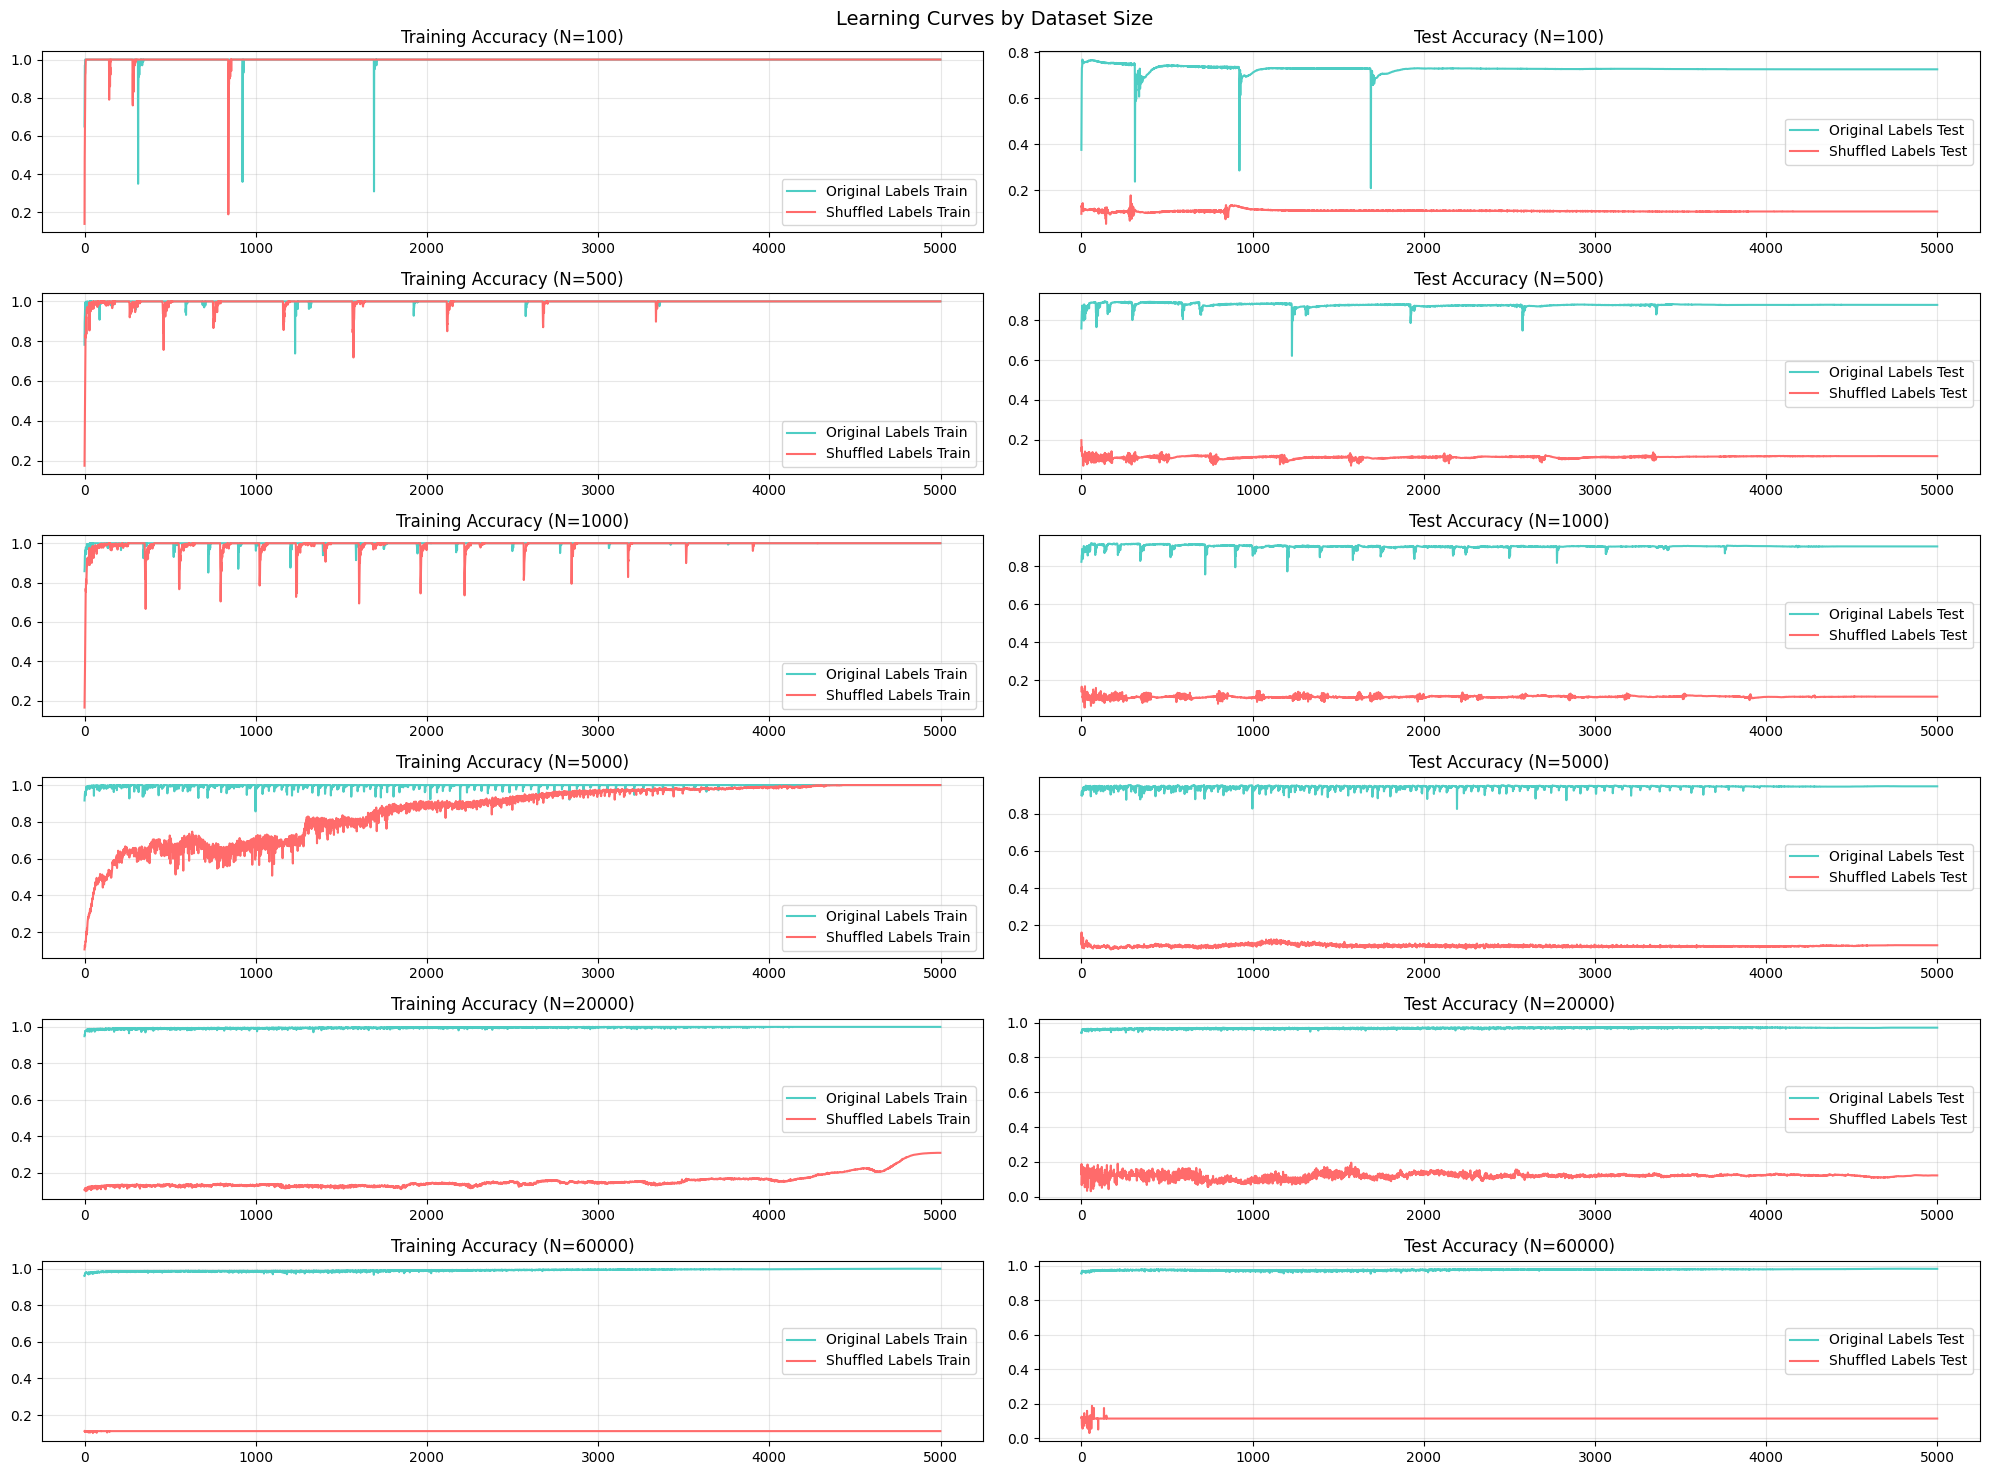

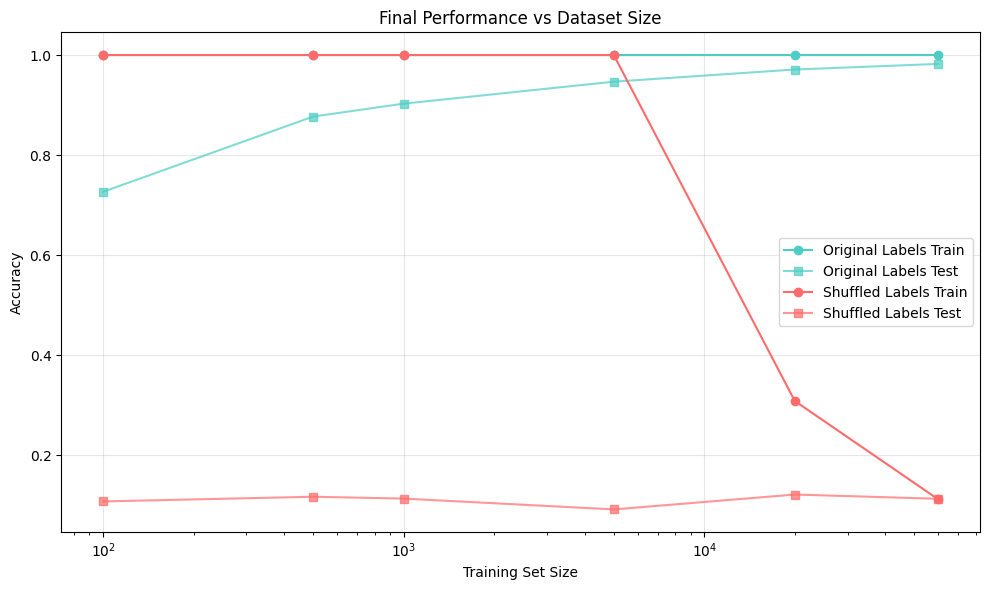

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import json
import os
from torch import nn

class DeepNN(nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'standard', gamma: float = 1.0):
        super().__init__()
        torch.set_default_dtype(torch.float32)
        self.gamma = gamma
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        
        for layer_idx in range(depth):
            linear = nn.Linear(prev_dim, hidden_size)
            if mode == 'standard':
                nn.init.xavier_uniform_(linear.weight)
                nn.init.zeros_(linear.bias)
            layers.extend([linear, nn.ReLU()])
            prev_dim = hidden_size
        
        final_layer = nn.Linear(prev_dim, 10)  # 10 outputs for MNIST
        if mode == 'standard':
            nn.init.xavier_uniform_(final_layer.weight)
        nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x) / float(self.gamma)

def load_experiment_data(results_dir: str, timestamp: str) -> Tuple[List[Dict], Dict]:
    """Load experiment results and hyperparameters"""
    hyperparams_path = os.path.join(results_dir, f'hyperparameters_{timestamp}.json')
    with open(hyperparams_path, 'r') as f:
        hyperparams = json.load(f)
    
    results_path = os.path.join(results_dir, f'final_results_{timestamp}.json')
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return results, hyperparams

def compute_anthropic_dimensionality(hidden: torch.Tensor, features: torch.Tensor) -> Tuple[float, float, float, float, torch.Tensor]:
    """Compute Anthropic's dimensionality metrics"""
    with torch.no_grad():
        # Sample dimensionality
        hidden_norms = torch.norm(hidden, dim=1, keepdim=True)
        normalized_hidden = hidden / (hidden_norms + 1e-8)
        hidden_dots = normalized_hidden @ normalized_hidden.T
        hidden_dots_squared = hidden_dots ** 2
        sample_denominator = torch.sum(hidden_dots_squared, dim=1)
        sample_numerator = torch.sum(hidden * hidden, dim=1)
        sample_dims = sample_numerator / (sample_denominator + 1e-8)
        
        sample_mean = float(torch.mean(sample_dims))
        sample_std = float(torch.std(sample_dims))

        # Feature dimensionality
        feature_norms = torch.norm(features, dim=0, keepdim=True)
        normalized_features = features / (feature_norms + 1e-8)
        feature_dots = normalized_features.T @ normalized_features
        feature_dots_squared = feature_dots ** 2
        feature_denominator = torch.sum(feature_dots_squared, dim=1)
        feature_numerator = torch.sum(features * features, dim=0)
        feature_dims = feature_numerator / (feature_denominator + 1e-8)
        
        feature_mean = float(torch.mean(feature_dims))
        feature_std = float(torch.std(feature_dims))

        return sample_mean, sample_std, feature_mean, feature_std, feature_dims

def analyze_dimensionality_by_layer(model: nn.Module, X: torch.Tensor) -> List[Dict]:
    """Compute dimensionality metrics for each layer"""
    layer_metrics = []
    current_activation = X
    
    with torch.no_grad():
        for i, layer in enumerate(model.network):
            if isinstance(layer, nn.Linear):
                features = layer.weight.data
                current_activation = layer(current_activation)
                
                sample_mean, sample_std, feature_mean, feature_std, feature_dims = compute_anthropic_dimensionality(
                    current_activation, features)
                
                layer_metrics.append({
                    'layer': i,
                    'anthropic': {
                        'sample_dim': sample_mean,
                        'sample_dim_std': sample_std,
                        'feature_dim': feature_mean,
                        'feature_dim_std': feature_std,
                        'feature_dims_raw': feature_dims.cpu().numpy()
                    }
                })
            else:
                current_activation = layer(current_activation)
    
    return layer_metrics

def analyze_by_dataset_size(results: List[Dict], hyperparams: Dict, results_dir: str, 
                          timestamp: str, target_lr=None, target_hidden_size=None, target_depth=None):
    """Analyze metrics for specific model configuration"""
    filtered_results = results
    if target_lr is not None:
        filtered_results = [r for r in filtered_results if r.get('learning_rate', r.get('lr')) == target_lr]
    if target_hidden_size is not None:
        filtered_results = [r for r in filtered_results if r['hidden_size'] == target_hidden_size]
    if target_depth is not None:
        filtered_results = [r for r in filtered_results if r['depth'] == target_depth]
    
    sorted_results = sorted(filtered_results, key=lambda x: x['n_train'])
    
    if not sorted_results:
        raise ValueError(f"No results found for configuration: lr={target_lr}, hidden_size={target_hidden_size}, depth={target_depth}")
    
    metrics = {
        'n_train': [],
        'layers': [],
        'error_history': [],
        'accuracies': []
    }
    
    expected_sizes = [100, 500, 1000, 5000, 20000, 60000]
    
    for result in sorted_results:
        if result['n_train'] not in expected_sizes:
            continue
            
        print(f"Processing: n_train={result['n_train']}, "
              f"hidden_size={result['hidden_size']}, depth={result['depth']}, "
              f"lr={result.get('learning_rate', result.get('lr'))}")
        
        # Load training data
        train_dataset_path = os.path.join(
            results_dir, 
            f'train_dataset_h{result["hidden_size"]}_d{result["depth"]}_n{result["n_train"]}_lr{result.get("learning_rate", result.get("lr"))}_g1_mup_pennington{("_shuffled" if result.get("shuffled", False) else "")}_{timestamp}_rank{result.get("worker_rank", 0)}.pt'
        )
        
        if not os.path.exists(train_dataset_path):
            print(f"Warning: Dataset not found: {train_dataset_path}")
            continue
            
        train_data = torch.load(train_dataset_path, weights_only=True)
        X_train = train_data['X']
        y_train = train_data['y']
        
        metrics['n_train'].append(result['n_train'])
        metrics['error_history'].append(result['error_history'])
        metrics['accuracies'].append({
            'train': result['error_history']['train_acc'][-1],
            'test': result['error_history']['test_acc'][-1]
        })
    
    return metrics

def plot_learning_curves(metrics1, metrics2, 
                        label1="Model 1", label2="Model 2",
                        figsize=(20, 15)):
    """Plot learning curves comparison between two models"""
    n_datasets = len(metrics1['n_train'])
    fig, axs = plt.subplots(n_datasets, 2, figsize=figsize)
    fig.suptitle('Learning Curves by Dataset Size', fontsize=14)
    
    for i, n_train in enumerate(metrics1['n_train']):
        # Training accuracy
        axs[i, 0].plot(metrics1['error_history'][i]['epochs'],
                      metrics1['error_history'][i]['train_acc'],
                      label=f'{label1} Train', color='#4ECDC4')
        axs[i, 0].plot(metrics2['error_history'][i]['epochs'],
                      metrics2['error_history'][i]['train_acc'],
                      label=f'{label2} Train', color='#FF6B6B')
        axs[i, 0].set_title(f'Training Accuracy (N={n_train})')
        axs[i, 0].grid(True, alpha=0.3)
        axs[i, 0].legend()
        
        # Test accuracy
        axs[i, 1].plot(metrics1['error_history'][i]['epochs'],
                      metrics1['error_history'][i]['test_acc'],
                      label=f'{label1} Test', color='#4ECDC4')
        axs[i, 1].plot(metrics2['error_history'][i]['epochs'],
                      metrics2['error_history'][i]['test_acc'],
                      label=f'{label2} Test', color='#FF6B6B')
        axs[i, 1].set_title(f'Test Accuracy (N={n_train})')
        axs[i, 1].grid(True, alpha=0.3)
        axs[i, 1].legend()
    
    plt.tight_layout()
    plt.show()

def plot_final_performance(metrics1, metrics2,
                          label1="Model 1", label2="Model 2",
                          figsize=(10, 6)):
    """Plot final performance metrics comparison"""
    plt.figure(figsize=figsize)
    
    train_acc1 = [m['train'] for m in metrics1['accuracies']]
    test_acc1 = [m['test'] for m in metrics1['accuracies']]
    train_acc2 = [m['train'] for m in metrics2['accuracies']]
    test_acc2 = [m['test'] for m in metrics2['accuracies']]
    
    plt.plot(metrics1['n_train'], train_acc1, 'o-', color='#4ECDC4', label=f'{label1} Train')
    plt.plot(metrics1['n_train'], test_acc1, 's-', color='#4ECDC4', label=f'{label1} Test', alpha=0.7)
    plt.plot(metrics2['n_train'], train_acc2, 'o-', color='#FF6B6B', label=f'{label2} Train')
    plt.plot(metrics2['n_train'], test_acc2, 's-', color='#FF6B6B', label=f'{label2} Test', alpha=0.7)
    
    plt.xscale('log')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Final Performance vs Dataset Size')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
def main():
    # Configuration for MNIST experiments
    results_dir1 = "/mnt/users/goringn/NNs_vs_Kernels/cifar10/results/mnist_mup_gamma_false"
    results_dir2 = "/mnt/users/goringn/NNs_vs_Kernels/cifar10/results/mnist_mup_gamma_true"
    timestamp1 = "20250124_183512"
    timestamp2 = "20250124_183551"
    hidden_size = 1000
    depth = 4
    target_lr = 0.005
    
    print("Loading and analyzing models...")
    # First model (non-shuffled)
    results1, hyperparams1 = load_experiment_data(results_dir1, timestamp1)
    metrics1 = analyze_by_dataset_size(
        results1, 
        hyperparams1, 
        results_dir1, 
        timestamp1, 
        target_lr=target_lr,
        target_hidden_size=hidden_size,
        target_depth=depth
    )
    
    # Second model (shuffled)
    results2, hyperparams2 = load_experiment_data(results_dir2, timestamp2)
    metrics2 = analyze_by_dataset_size(
        results2, 
        hyperparams2, 
        results_dir2, 
        timestamp2, 
        target_lr=target_lr,
        target_hidden_size=hidden_size,
        target_depth=depth
    )
    
    # Generate plots
    plot_learning_curves(
        metrics1, 
        metrics2,
        label1="Original Labels",
        label2="Shuffled Labels"
    )
    
    plot_final_performance(
        metrics1,
        metrics2,
        label1="Original Labels",
        label2="Shuffled Labels"
    )

if __name__ == "__main__":
    main()